In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl
import statsmodels.stats.multicomp as ml

from scipy import stats as spstats
from matplotlib.lines import Line2D

from pipeline.python import utils as putils #.utils import natural_keys, label_figure, convert_range
from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.retinotopy import segment_retinotopy as seg

from pipeline.python.classifications import bootstrap_osi as osi


import matplotlib.patches as mpatches

/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params()


In [4]:
def outline_boxplot(ax):
    # iterate over boxes to make them outlines only
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
        # iterate over whiskers and median lines
        for j in range(6*i,6*(i+1)):
             ax.lines[j].set_color('black')
    return


# Set metadata info

In [5]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir = '/n/coxfs01/2p-data'

#### Preprocessing params
responsive_test = 'nstds'
responsive_thr = 10.0
n_stds = 2.5

#### Fit params
response_type = 'dff'
fit_thr=None

n_bootstrap_iters=1000
n_resamples = 20


#### Get fit description
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test,
                       responsive_thr=responsive_thr, n_stds=n_stds)
print(fit_desc)

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [6]:
#### Set outputdir for current analysis
outdir = os.path.join(aggregate_dir, 'gratings-tuning', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_id = '%s|%s' % (traceid, fit_desc)
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
DATA ID: traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [7]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

# Aggregate all tuning data

In [8]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [9]:
def add_tuned_cells(responsive_cells, gdata, responsive_thr=0.5):

    count_cols = ['visual_area', 'animalid', 'session', 'fov','datakey', 'cell']
    tuned_cells = gdata[gdata['r2comb']>=responsive_thr][count_cols]\
                        .drop_duplicates().groupby(count_cols[0:-1])\
                        .count().reset_index().rename(columns={'cell': 'tuned_cells'})

    updated_counts = pd.merge(responsive_cells, tuned_cells, how='left')
    #print(updated_counts.shape)
    return updated_counts

def update_gof_cells(updated_counts, gdata, gof_thr=0.5, responsive_name='responsive_cells'):
    count_cols = ['visual_area', 'animalid', 'session', 'fov','datakey', 'cell']

    gof_cells = gdata[gdata['gof']>=curr_gof][count_cols]\
                        .drop_duplicates().groupby(count_cols[0:-1])\
                        .count().reset_index().rename(columns={'cell': 'gof_cells'})
    cellcounts = pd.merge(updated_counts, gof_cells, how='left')
    cellcounts['tuned_over_responsive'] = cellcounts['tuned_cells'].astype(float) / cellcounts[responsive_name]
    cellcounts['gof_over_responsive'] = cellcounts['gof_cells'].astype(float) / cellcounts[responsive_name]
    cellcounts['gof_over_tuned'] = cellcounts['gof_cells'].astype(float) / cellcounts['tuned_cells']


    #print(cellcounts.shape)
    return cellcounts.dropna()

In [10]:
#### Get metadata
gratings_filter_by = None #'most_cells'
dsets = aggr.get_metadata(stimulus='gratings',  filter_by=gratings_filter_by, 
                          stimulus_only=True,
                          traceid=traceid, fov_type=fov_type, state=state)
dsets.groupby(['visual_area', 'experiment']).count()


Selecting 35 dsets


animalid  datakey  fov  fovnum  session
visual_area experiment                                         
Li          gratings          18       18   18      18       18
Lm          gratings          10       10   10      10       10
V1          gratings           7        7    7       7        7

In [11]:
response_type='dff'
responsive_test='nstds'
responsive_thr=10
trial_epoch = 'stimulus'

# retino
retino_mag_thr=0.01
retino_pass_criterion='max'
verbose=False


In [12]:
sdata[sdata['datakey']=='20190617_JC099_fov1']

animalid              datakey experiment            fov  fovnum   session  \
54    JC099  20190617_JC099_fov1      rfs10  FOV1_zoom2p0x       1  20190617   
55    JC099  20190617_JC099_fov1   gratings  FOV1_zoom2p0x       1  20190617   
56    JC099  20190617_JC099_fov1      blobs  FOV1_zoom2p0x       1  20190617   
57    JC099  20190617_JC099_fov1     retino  FOV1_zoom2p0x       1  20190617   

   visual_area  
54          Li  
55          Li  
56          Li  
57          Li

In [13]:
# Get all cells
# -------------------------------------------------------------------------
all_rois = seg.get_cells_by_area(sdata)
all_counts = all_rois[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()\
                .rename(columns={'cell': 'total'})

Segmentation: missing 9 dsets


In [14]:
# Get all RESPONSIVE cells
# -------------------------------------------------------------------------
aggr_cells, missing_seg = aggr.get_responsive_all_experiments(sdata,
                                    response_type=response_type, traceid=traceid,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr,
                                    trial_epoch=trial_epoch, retino_mag_thr=retino_mag_thr,
                                    retino_pass_criterion=retino_pass_criterion, return_missing=True)

assert len([k for k in aggr_cells['datakey'].unique() if k in missing_seg])==0, \
"There are included dsets w/ missing seg. Fix this."

# Count all responsive cells       
# -------------------------------------------------------------------------
visual_cells = aggr_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()
visual_counts = visual_cells.groupby(['visual_area', 'datakey']).count().reset_index()


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
Segmentation: missing 5 dsets
(1993, 8)
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
Segmentation: missing 4 dsets
(5499, 8)
Segmentation: missing 3 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4
[AL] Animalid does not exist: JC080 
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC089 
[Ll] Animalid does not exist: JC099 
[PL] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
(29, 8)
Segmentation: missing 9 dsets
(8678, 8)


In [15]:
# Get all cells
# visual_cells2 = aggr.get_ncells_by_experiment(aggr_cells, all_counts, experiment=None)
gratings_cellcounts = aggr.get_ncells_by_experiment(aggr_cells, all_counts, experiment='gratings')

In [16]:
gratings_cellcounts.groupby(['visual_area']).sum()

visual  total  fraction
visual_area                         
AL                2     17  0.117647
Li              314   2074  2.325936
Ll              134    358  0.771185
Lm              720   2084  2.738091
V1              823   2297  3.158393

In [17]:
experiment='gratings'
trial_epoch = 'stimulus'

#### Check for equal trial counts
gratings_meta, gratings_cells, MEANS_gratings = aggr.get_source_data(experiment, equalize_now=True, 
                                    response_type=response_type,
                                    responsive_test=responsive_test, 
                                    responsive_thr=responsive_thr, 
                                    trial_epoch=trial_epoch) 
gratings_cells = gratings_cells[gratings_cells['visual_area'].isin(visual_areas)]
gratings_cells.groupby(['visual_area']).count()


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_gratings_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
---equalizing now---
Segmentation: missing 5 dsets


cell  fov  animalid  session  datakey  fovnum
visual_area                                               
Li            314  314       314      314      314     314
Lm            720  720       720      720      720     720
V1            823  823       823      823      823     823

In [26]:
gratings_cellcounts

visual_area              datakey  visual  total  fraction
0           Li  20190314_JC070_fov1      37    137  0.270073
1           Li  20190315_JC070_fov2       7    102  0.068627
2           Li  20190319_JC067_fov1       9     46  0.195652
3           Li  20190522_JC089_fov1       8     32  0.250000
4           Li  20190527_JC092_fov3       7    118  0.059322
5           Li  20190602_JC091_fov1      65    197  0.329949
6           Li  20190606_JC091_fov1      22    175  0.125714
7           Li  20190607_JC091_fov1      43    280  0.153571
8           Li  20190609_JC099_fov1       8    256  0.031250
9           Li  20190612_JC099_fov1      19    118  0.161017
10          Li  20190614_JC091_fov1      45    299  0.150502
11          Li  20190617_JC099_fov1      10     83  0.120482
12          Li  20191018_JC113_fov1      32     81  0.395062
13          Li  20191111_JC120_fov1       2    151  0.013245
14          Ll  20190319_JC067_fov1     118    211  0.559242
15          Ll  20190522_JC089_fov1       5     52  0.096154
16          Ll  20190612_JC099_fov1      11     95  0.115789
17          Lm  20190306_JC061_fov2      77    219  0.351598
18          Lm  20190314_JC070_fov2      17     67  0.253731
19          Lm  20190512_JC083_fov1     155    271  0.571956
20          Lm  20190513_JC078_fov1     188    278  0.676259
21          Lm  20190525_JC084_fov1      64    237  0.270042
22          Lm  20190603_JC080_fov1      93    271  0.343173
23          Lm  20190618_JC097_fov1      32    203  0.157635
24          Lm  20190627_JC091_fov1      41    304  0.134868
25          PL  20190314_JC070_fov2      45    184  0.244565
26          V1  20190511_JC083_fov1     138    174  0.793103
27          V1  20190512_JC083_fov1      36     86  0.418605
28          V1  20190522_JC084_fov1     115    260  0.442308
29          V1  20190613_JC097_fov1      67    225  0.297778
30          V1  20190616_JC097_fov1     182    429  0.424242
31          V1  20190617_JC097_fov1      86    420  0.204762
32          V1  20190622_JC085_fov1     106    312  0.339744
33          V1  20191006_JC110_fov1      93    391  0.237852

In [59]:
#### Test with 1 dataset first

# animalid = 'JC091'
# session = '20191008'
# fov = 'FOV1_zoom2p0x'
# gof_thr=0.6

# bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
#                                                  traceid, fit_desc)
# rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
# print("%i cells with good fits." % rmetrics.shape[0])

In [60]:
fit_desc

'fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

In [136]:
gof_thr=0.5
no_fits = []
counts_ = []
g_ = []
rerun_responsive=[]
i = 0
for (visual_area, datakey, animalid, session, fov), g in gratings_cells.groupby(['visual_area', 'datakey', 'animalid', 'session', 'fov']):
    skey = '%s_%s' % (visual_area, '-'.join([animalid, session, fov]) )

    # Get all osi results for current dataset
    # bootresults: dict with keys=rois, values=results (dict)
    exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    bootresults_tmp, fitparams = exp.get_tuning(response_type=response_type,
                                           responsive_test=responsive_test,
                                           responsive_thr=responsive_thr,
                                           n_stds=n_stds,
                                           n_bootstrap_iters=n_bootstrap_iters,
                                           n_resamples=n_resamples,
                                           n_processes=1, make_plots=True)
    curr_cells = g['cell'].unique()
    
    # Get cells responsive to anything (visual cells)
    visual_cells_any = visual_cells[(visual_cells['visual_area']==visual_area)
                         & (visual_cells['datakey']==datakey)]['cell']
    
    print("[%s] %s - %i (of %i visual) cells responsive" \
          % (visual_area, datakey, len(curr_cells), len(visual_cells_any)))
    
    # Get OSI results
    bootresults = dict((k, v) for k, v in bootresults_tmp.items() if k in curr_cells)

    # Get fits
    rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=None)
    if rmetrics is None:
        no_fits.append(skey)
        continue
    
    counts_.append(pd.DataFrame({'datakey': datakey,
                                    'visual_area': visual_area,
                                    'animalid': animalid,
                                    'session': session, 
                                    'fov': fov,
                                    'visual_cells': len(visual_cells_any),
                                    'responsive_cells': len(curr_cells)}, index=[i]))
    meandf = rmetrics.copy()
    metainfo = {'visual_area': visual_area, 'animalid': animalid, 
                'session': session, 'fov': fov, 'datakey': datakey}
    meandf = putils.add_meta_to_df(meandf, metainfo)
    g_.append(meandf)
    i += 1
    
responsive_cells = pd.concat(counts_, axis=0)
gdata = pd.concat(g_, axis=0)

print("Datasets with NO fits found:")
for s in no_fits:
    print(s)
    
# Add 'tuned' cells
updated_counts = add_tuned_cells(responsive_cells, gdata, responsive_thr=0.5)

... loading existing fits
[Li] 20190314_JC070_fov1 - 37 (of 118 visual) cells responsive
... 15 (of 37) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190315_JC070_fov2 - 7 (of 47 visual) cells responsive
... 3 (of 7) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190319_JC067_fov1 - 9 (of 46 visual) cells responsive
... 2 (of 9) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190522_JC089_fov1 - 8 (of 24 visual) cells responsive
... 3 (of 8) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190527_JC092_fov3 - 7 (of 81 visual) cells responsive
... 5 (of 7) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190602_JC091_fov1 - 65 (of 172 visual) cells responsive
... 36 (of 65) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190606_JC091_fov1 - 22 (of 147 visual) cells responsive
... 9 (of 21) fitable cells (no GoF thr)
... loading existing fits
[Li] 20190607_JC091_fov1 - 43 (of 239 visual) cells responsive
... 18 (of 

In [34]:
#responsive_cells = pd.concat(counts_, axis=0)
#gdata = pd.concat(g_, axis=0)

In [35]:
# Add 'tuned' cells
#updated_counts = add_tuned_cells(responsive_cells, gdata, responsive_thr=0.5)

In [19]:
curr_gof=0.5

cell_counts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)
cell_counts.groupby(['visual_area']).sum()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        296          1423        136.0       68.0   
Lm                        667          1648        360.0      187.0   
V1                        823          2057        413.0      220.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        5.259943             2.591583        5.356349  
Lm                        4.137374             2.154541        4.240243  
V1                        4.147129             2.264204        4.315775

In [20]:
cell_counts.groupby(['visual_area']).mean()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                  26.909091    129.363636    12.363636   6.181818   
Lm                  83.375000    206.000000    45.000000  23.375000   
V1                 102.875000    257.125000    51.625000  27.500000   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        0.478177             0.235598        0.486941  
Lm                        0.517172             0.269318        0.530030  
V1                        0.518391             0.283026        0.539472

# Debug for 1 fov

In [38]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

In [201]:
visual_area='Li'
animalid = 'JC099'
session = '20190617'
fovnum = 1
datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
fov = 'FOV%i_zoom2p0x' % fovnum

g = gratings_cells[(gratings_cells['visual_area']==visual_area) & (gratings_cells['datakey']==datakey)].copy()

# Get all osi results for current dataset
exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
bootresults_tmp, fitparams = exp.get_tuning(response_type=response_type,
                                       responsive_test=responsive_test,
                                       responsive_thr=responsive_thr,
                                       n_stds=n_stds,
                                       n_bootstrap_iters=n_bootstrap_iters,
                                       n_resamples=n_resamples,
                                       n_processes=1, make_plots=True)

curr_cells = g['cell'].unique()
print("[%s] %s - %i cells responsive" % (visual_area, datakey, len(curr_cells)))
bootresults = dict((k, v) for k, v in bootresults_tmp.items() if k in curr_cells)


[Li] 20190617_JC099_fov1 - 10 cells responsive


In [202]:
len(bootresults.keys())

10

In [203]:
gratings_cells[gratings_cells['datakey']==datakey].shape

(10, 7)

In [204]:
# Get tuning dirs
run_name='combined_gratings_static'
osidir, fit_desc = osi.create_osi_dir(animalid, session, fov, run_name, traceid=traceid,
                                  response_type=response_type, 
                                  responsive_test=responsive_test,
                                  responsive_thr=responsive_thr, 
                                  n_bootstrap_iters=fitparams['n_bootstrap_iters'],
                                  n_resamples=fitparams['n_resamples'])


In [205]:
print(visual_area, datakey)

traceid_dir =  osidir.split('/tuning/')[0] 
data_fpath = os.path.join(traceid_dir, 'data_arrays', 'np_subtracted.npz')
roi_list = gratings_cells[(gratings_cells['visual_area']==visual_area) & (gratings_cells['datakey']==datakey)]['cell'].unique()

df_traces, labels, gdf, sdf = osi.get_experiment_data(data_fpath, add_offset=True, make_equal=False)
rdf_list = [gdf.get_group(roi) for roi in roi_list] # HEREHERE

('Li', '20190617_JC099_fov1')
/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_585a7e_traces001_864059_traces001_9119e0_traces001_eb3372/data_arrays/np_subtracted.npz


In [206]:
len(roi_list)

10

In [207]:
constant_params = ['aspect', 'luminance', 'position', 'stimtype', 'direction', 'xpos', 'ypos']
params = [c for c in sdf.columns if c not in constant_params]
stimdf = sdf[params]
tested_oris = sdf['ori'].unique()

# Get all config sets: Each set is a set of the 8 tested oris at a specific combination of non-ori params
configsets = dict((tuple(round(ki, 1) for ki in k), sorted(cfgs.index.tolist(), key=lambda x: stimdf['ori'][x]) )\
                 for k, cfgs in stimdf.groupby(['sf', 'size', 'speed']) )


In [208]:
# for k, v in test_bootresults.items():
#     print(k, len(v))

passrois = sorted([k for k, v in bootresults.items() if any(v.values())])
print("... %i cells (out of %i) fit at least 1 tuning curve." \
      % (len(passrois), len(bootresults.keys())))

... 10 cells (out of 10) fit at least 1 tuning curve.


In [209]:
rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=None)

... 8 (of 10) fitable cells (no GoF thr)


In [210]:
datakey

'20190617_JC099_fov1'

In [211]:
rmetrics_by_cfg

asi  cell       dsi       gof        r2    r2comb  \
sf-0.10-sz-200-sp-10  0.383007  23.0  0.554584  0.194448  0.530596  0.221954   
sf-0.10-sz-200-sp-20  0.445203  26.0  0.427590  0.517998  0.757556  0.704996   
sf-0.10-sz-200-sp-10  0.447420  26.0  0.363347  0.418058  0.689813  0.668522   
sf-0.10-sz-200-sp-20  0.520635  28.0  0.115046  0.541276  0.778279  0.632558   
sf-0.10-sz-200-sp-10  0.522069  28.0  0.172910  0.489912  0.780630  0.563373   
sf-0.10-sz-30-sp-10   0.365924  29.0  0.489210  0.204627  0.643283  0.204012   
sf-0.10-sz-200-sp-20  0.513090  32.0  0.468011  0.482597  0.740494  0.632132   
sf-0.50-sz-200-sp-10  0.454049  33.0  0.410779  0.225518  0.475498  0.396204   
sf-0.10-sz-200-sp-20  0.630884  33.0  0.561066  0.239125  0.562926  0.343991   
sf-0.10-sz-30-sp-10   0.556143  67.0  0.349178  0.635474  0.827770  0.824158   
sf-0.50-sz-30-sp-10   0.484231  69.0  0.371208  0.149886  0.558290  0.135166   

                      response_null  response_offset  response_pref  \
sf-0.10-sz-200-sp-10       0.026146        -0.016465       0.052472   
sf-0.10-sz-200-sp-20       0.039422        -0.018205       0.066826   
sf-0.10-sz-200-sp-10       0.046301        -0.027357       0.061919   
sf-0.10-sz-200-sp-20       0.083284        -0.033552       0.089634   
sf-0.10-sz-200-sp-10       0.065136        -0.024525       0.075218   
sf-0.10-sz-30-sp-10        0.019611        -0.011959       0.040066   
sf-0.10-sz-200-sp-20       0.030097        -0.004914       0.061760   
sf-0.50-sz-200-sp-10       0.076033        -0.050513       0.098038   
sf-0.10-sz-200-sp-20       0.015776         0.009179       0.036576   
sf-0.10-sz-30-sp-10        0.042077        -0.003731       0.068597   
sf-0.50-sz-30-sp-10        0.036901        -0.016181       0.048706   

                          sigma  theta_pref  
sf-0.10-sz-200-sp-10  61.602981   88.163265  
sf-0.10-sz-200-sp-20  54.939705   51.428571  
sf-0.10-sz-200-sp-10  60.845459   88.163265  
sf-0.10-sz-200-sp-20  49.386308   73.469388  
sf-0.10-sz-200-sp-10  50.263717  257.142857  
sf-0.10-sz-30-sp-10   68.123535   44.081633  
sf-0.10-sz-200-sp-20  44.097098   44.081633  
sf-0.50-sz-200-sp-10  64.476102  132.244898  
sf-0.10-sz-200-sp-20  33.831023  227.755102  
sf-0.10-sz-30-sp-10   39.166713  315.918367  
sf-0.50-sz-30-sp-10   56.892600  132.244898

In [ ]:
Should be in Lm:
    364, 340, 333, 332, 331
    297. 293. 261.
    
    

In [170]:
rid=8
stimparams = bootresults[rid].keys()
print(stimparams)

[(0.1, 30.0, 10.0), (0.5, 30.0, 10.0)]


In [94]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.py'>

In [171]:
stimparam = stimparams[1]
print(stimparam)
bootr = bootresults[rid][stimparam]


(0.5, 30.0, 10.0)


In [172]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.py'>

In [173]:
# Average fit parameters aross boot iters
params = [c for c in bootr['results'].columns if 'stim' not in c]
avg_metrics = osi.average_metrics_across_iters(bootr['results'][params])
    
thetas = bootr['fits']['xv']
avg_metrics

asi  cell       dsi        r2  response_null  response_offset  \
8  0.506686   8.0  0.324248  0.535233       0.029751        -0.012395   

   response_pref      sigma  theta_pref  
8        0.04906  59.519063   36.734694

In [196]:
orig_ = bootr['data']['responses'].mean(axis=0)
#orig_data = np.abs(orig_ - np.mean(orig_))
orig_data = (orig_ - orig_.min()) #- (orig_ - orig_.mean()).min()
origr = osi.interp_values(orig_data)

fitvs = bootr['fits']['fitv'].mean(axis=1)


In [194]:
cpopt = avg_metrics[['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']].values[0]
#cpopt[0]=cpopt[0] - cpopt[-1]
cpopt[1]=cpopt[0]
cpopt=tuple(cpopt)
fitr = osi.double_gaussian( thetas, *cpopt)


<IPython.core.display.Javascript object>


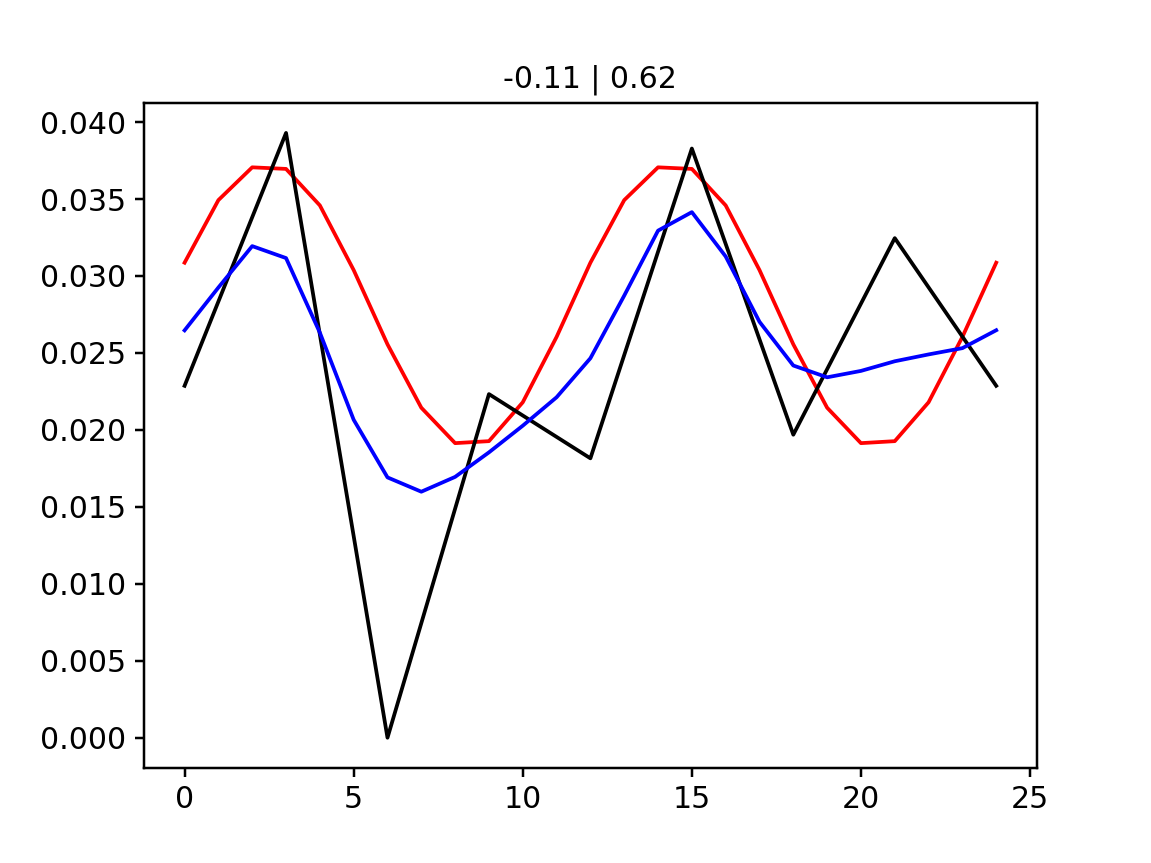

Text(0.5,1,u'-0.11 | 0.62')

In [200]:
pl.figure()
pl.plot(fitr, 'r')
pl.plot(origr, 'k')
pl.plot(fitvs, 'b')
r2_comb, _ = osi.coeff_determination(origr, fitr)
r2_comb_avg, _ = osi.coeff_determination(origr, fitvs)

pl.title('%.2f | %.2f' % (r2_comb, r2_comb_avg))

In [96]:
cnts, bns = np.histogram(bootr['results']['theta_pref'] % 360., bins=np.linspace(thetas[0], thetas[-1], len(thetas)*2.))
pref_th = float(bns[np.where(cnts==max(cnts))[0]])


In [177]:
r2comb, gof, fitr = osi.evaluate_fits(bootr, interp=True)
print(r2comb, gof)

(-0.7201204898661409, nan)


In [117]:
responses_df = bootr['data']['responses']
responses_df.shape

(20, 8)

In [119]:
# Bootstrap distN of responses (rand w replacement):
bootdf_tmp = pd.concat([responses_df.sample(n_resamples, replace=True).mean(axis=0) \
                        for ni in range(n_bootstrap_iters)], axis=1)
bootdf_tmp.index = [sdf['ori'][c] for c in bootdf_tmp.index]
#bootdf = np.abs((bootdf_tmp - bootdf_tmp.mean()))
bootdf = (bootdf_tmp-bootdf_tmp.min()) #- (bootdf_tmp-bootdf_tmp.mean()).min()
bootdf.shape

(8, 1000)

In [128]:
bootdf.head()

0         1         2         3         4         5         6    \
0    0.015150  0.026062  0.055492  0.034061  0.005021  0.007636  0.020756   
45   0.052177  0.031790  0.053943  0.045748  0.059432  0.003580  0.055251   
90   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
135  0.016048  0.032683  0.034721  0.026436  0.019525  0.004011  0.028074   
180  0.028368  0.019663  0.034771  0.017751  0.021884  0.006167  0.019979   

          7         8         9      ...          990       991       992  \
0    0.019131  0.016559  0.003641    ...     0.016137  0.044636  0.032253   
45   0.036307  0.037767  0.021677    ...     0.045905  0.046237  0.029858   
90   0.000000  0.000000  0.017659    ...     0.003462  0.000000  0.000000   
135  0.024934  0.031616  0.024754    ...     0.000000  0.047538  0.029563   
180  0.010511  0.007063  0.023878    ...     0.016369  0.025009  0.022633   

          993       994       995       996       997       998       999  
0    0.015722  0.006346  0.032963  0.033298  0.031975  0.030345  0.019032  
45   0.034718  0.035339  0.036097  0.047913  0.034285  0.040071  0.050424  
90   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
135  0.008109  0.020275  0.048391  0.023956  0.026920  0.031786  0.042134  
180  0.024439  0.023566  0.026841  0.018637  0.011679  0.025115  0.027312  

[5 rows x 1000 columns]

In [137]:
ys = bootdf[0]
ys.loc[360] = ys.loc[0]
ys

0      0.015150
45     0.052177
90     0.000000
135    0.016048
180    0.028368
225    0.029764
270    0.022409
315    0.026367
360    0.015150
Name: 0, dtype: float64

In [155]:
R1 = ys.max()

max_ix = ys[ys==ys.max()].index[0]

R2 = max(ys.loc[max_ix-45], ys.loc[max_ix+45])
R3 = min(ys.loc[max_ix-45], ys.loc[max_ix+45])

R2_ix = ys[ys==R2].index[0]
R3_ix = ys[ys==R3].index[0]

if R2_ix < max_ix:
    R4_ix = (R2_ix - 45.) % 360.
    R12_ix = R2_ix - (45/2.)
else:
    R4_ix = (R2_ix + 45.) % 360.
R4 = ys.loc[R4_ix]

print("max: %i, R1=%i, R4=%i, R3=%i" % (max_ix, R2_ix, R4_ix, R3_ix))

interp_R12 = (R1-R2)/2. + (1-(R1-R2)/(R1-R3))*((R1-R3) + (R2-R4))/6.
add_peak = (1/6.)*((R1-R3)+(R2-R4))

max: 45, R1=0, R4=315, R3=90


In [167]:
thetas

[0.0,
 15.0,
 30.0,
 45.0,
 60.0,
 75.0,
 90.0,
 105.0,
 120.0,
 135.0,
 150.0,
 165.0,
 180.0,
 195.0,
 210.0,
 225.0,
 240.0,
 255.0,
 270.0,
 285.0,
 300.0,
 315.0,
 330.0,
 345.0,
 360.0]

<IPython.core.display.Javascript object>


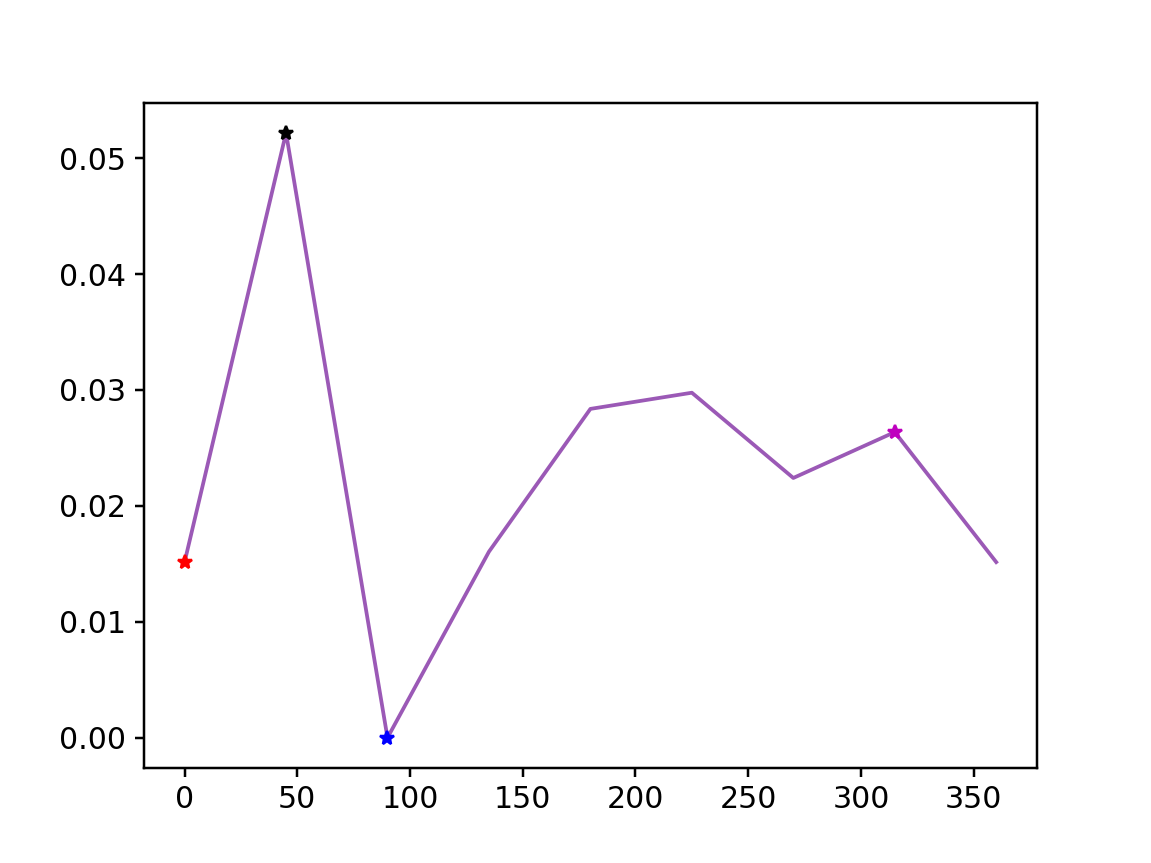

In [165]:
pl.figure()
pl.plot(ys)
pl.plot(max_ix, R1, 'k*')
pl.plot(R2_ix, R2, 'r*')
pl.plot(R3_ix, R3, 'b*')
pl.plot(R4_ix, R4, 'm*')

pl.plot((max_ixinterp_R12, )

In [161]:
(R2-R1)/2.

-0.01851353981246301

<IPython.core.display.Javascript object>


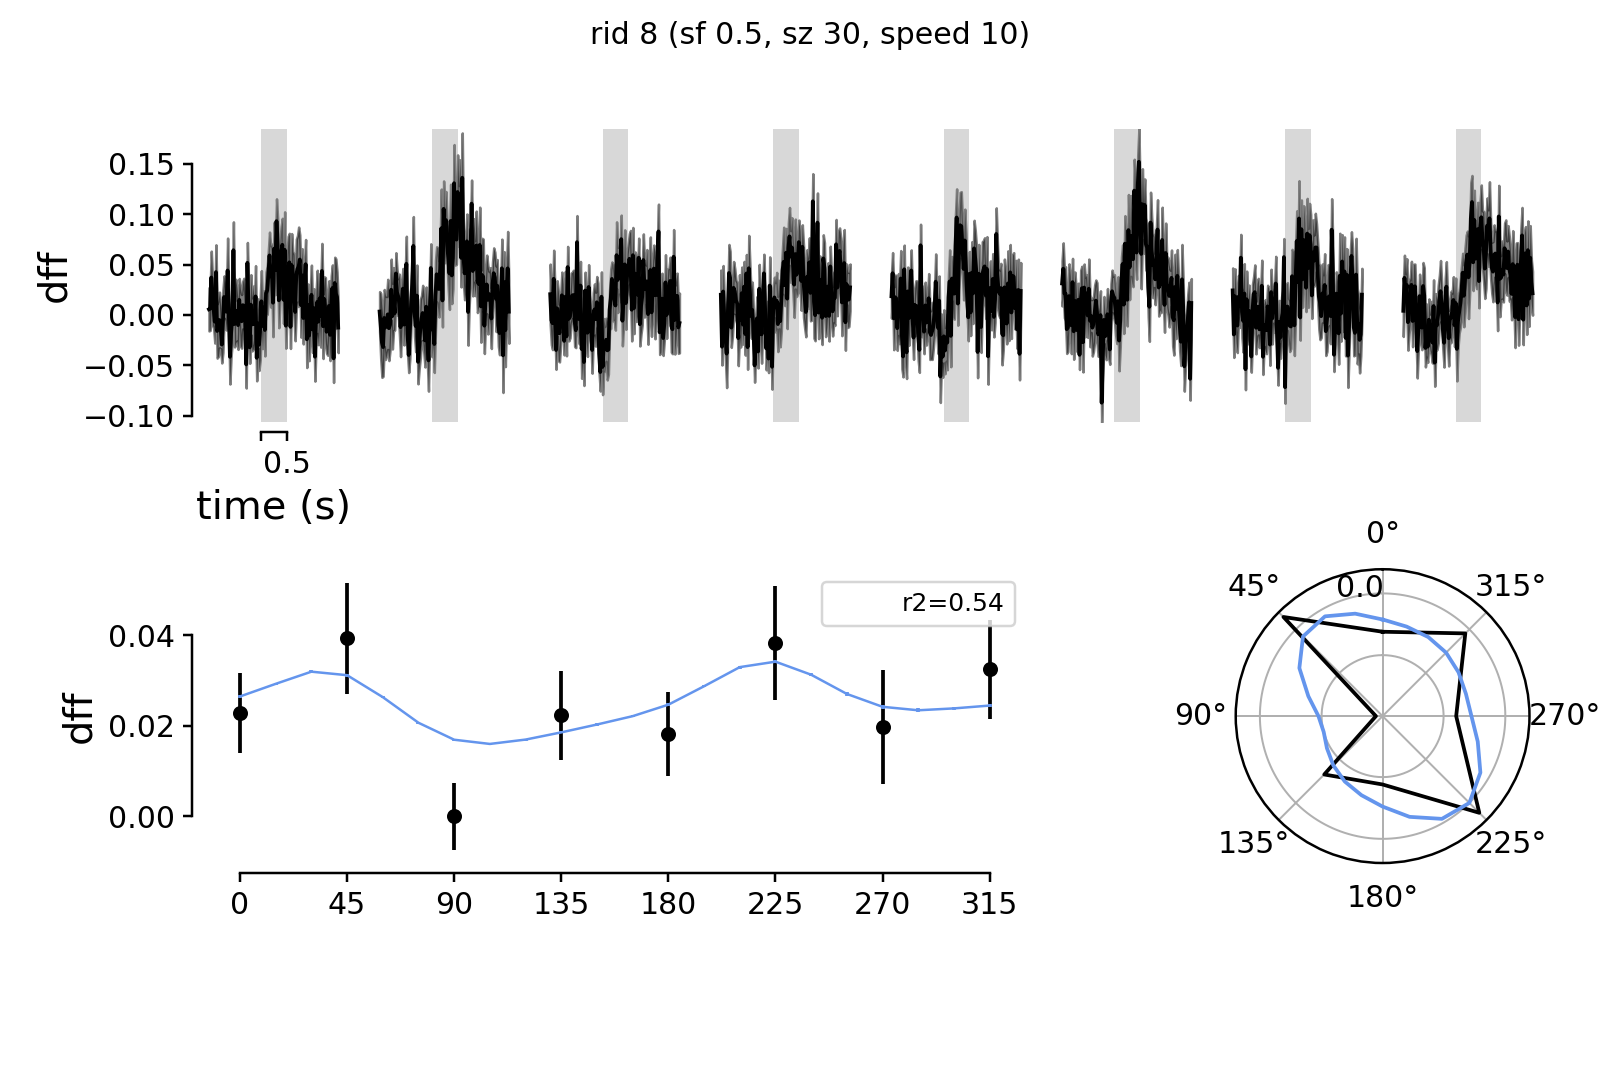

plotting roi 8


In [168]:
fig, stimkey = osi.plot_tuning_bootresults(rid, bootr, df_traces, labels, sdf, trace_type='dff')

In [70]:
bootr['results'].median()['theta_pref'] % 180.

26.818705973908493

In [71]:
206.-180.

26.0

In [110]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

<IPython.core.display.Javascript object>


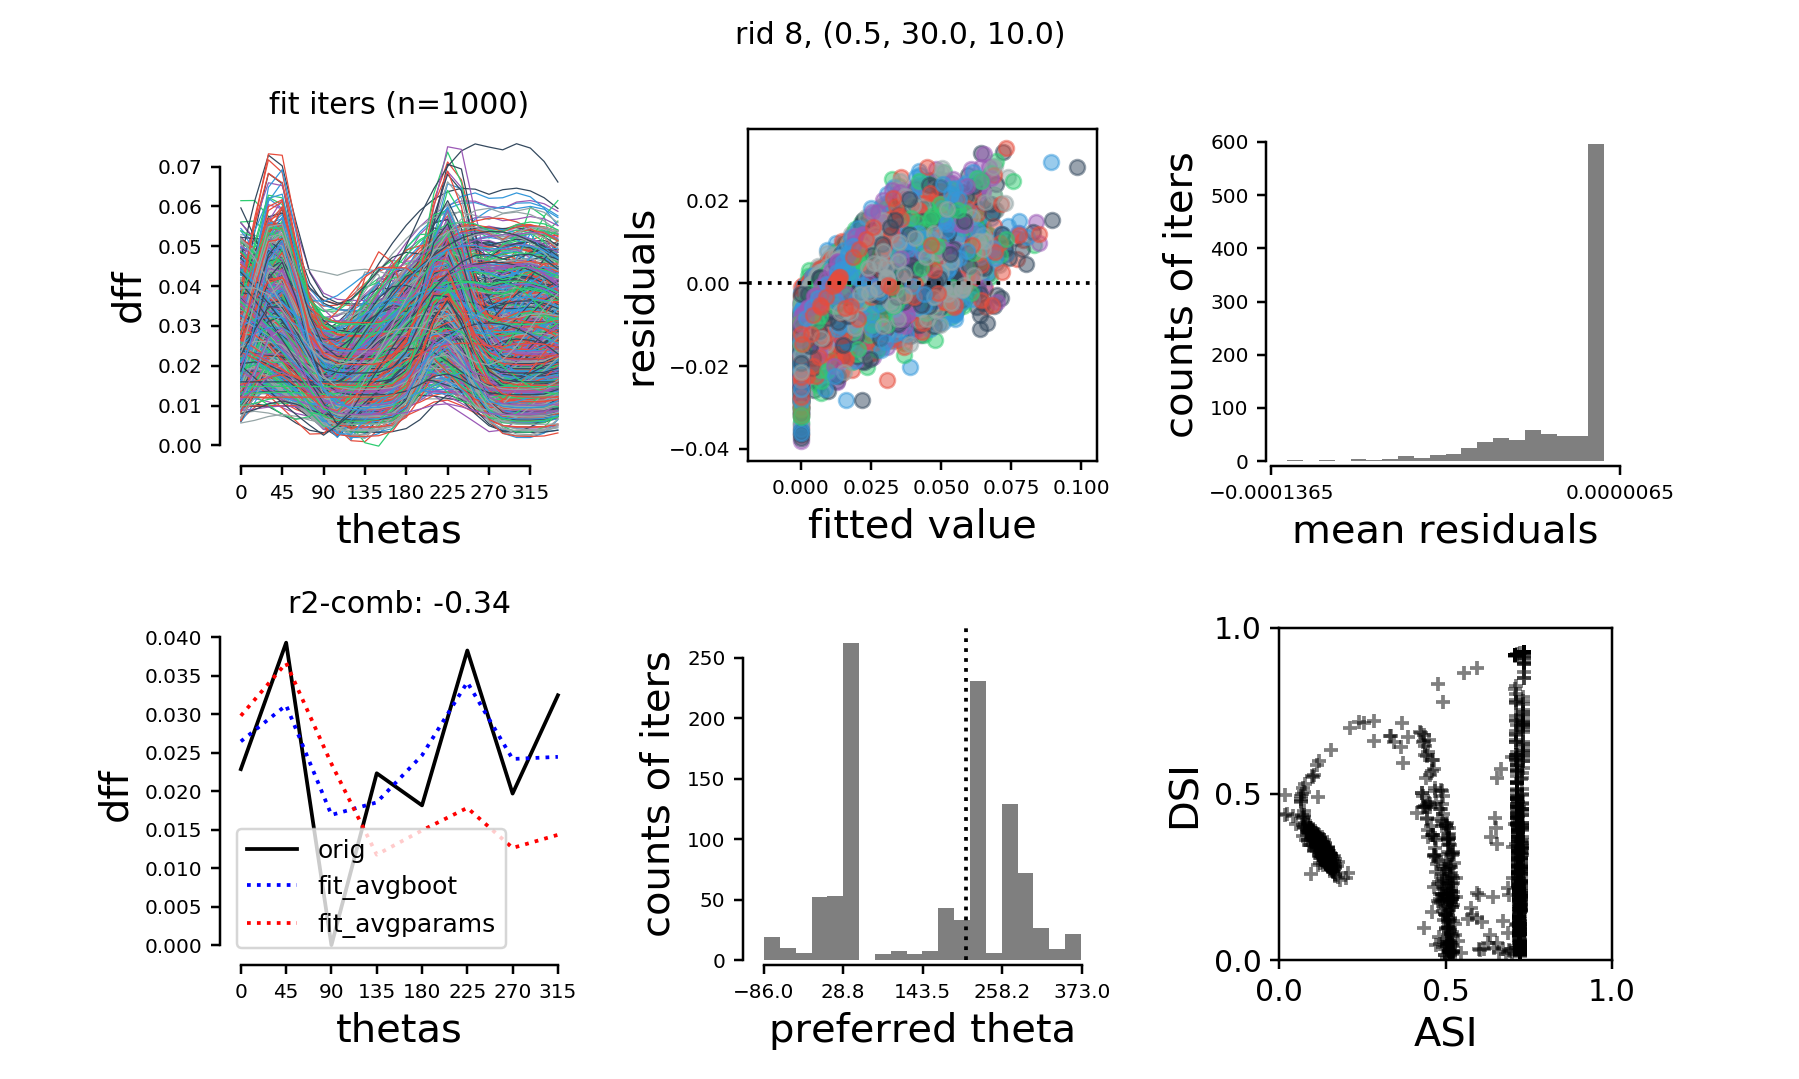

In [111]:
fig = osi.evaluate_fit_roi(rid, bootr, fitparams, response_type=response_type, param_str=str(stimparam))

In [47]:
responses_df = bootr['data']['responses']
#responses_df

<IPython.core.display.Javascript object>


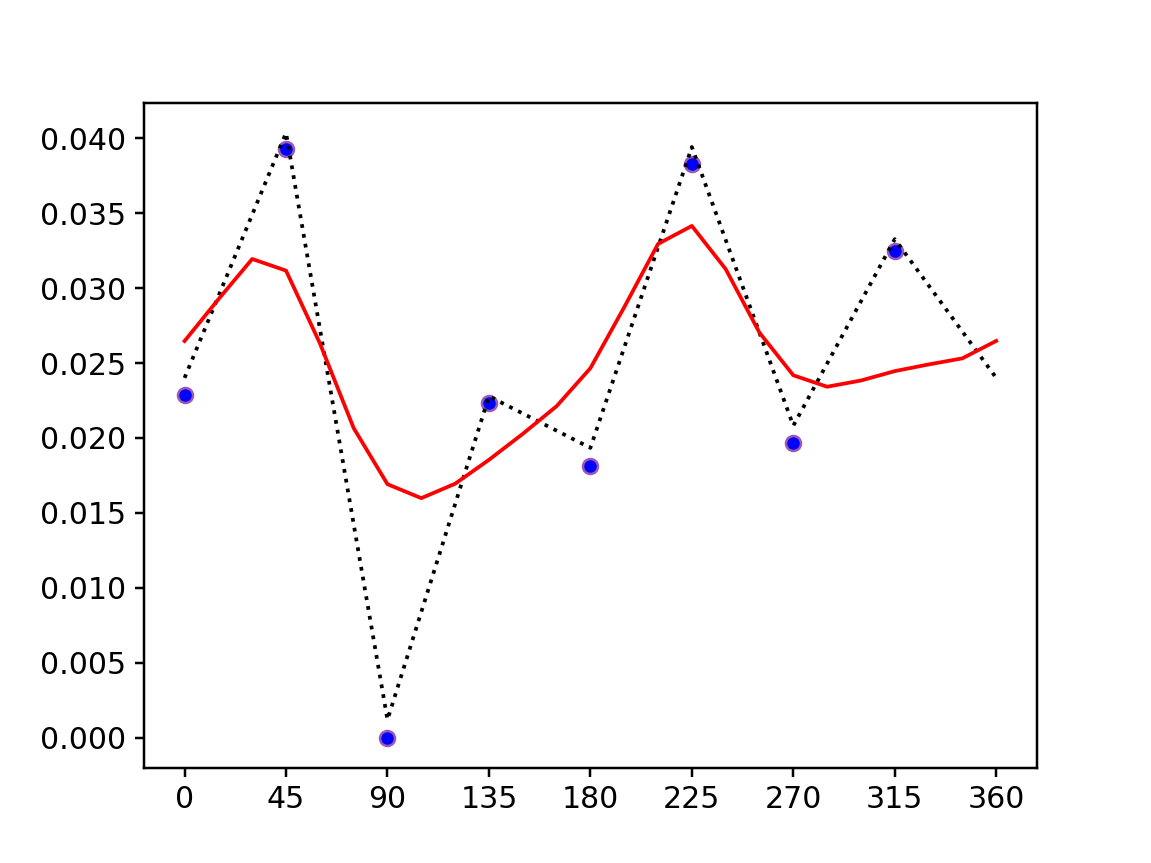

In [109]:
fig, ax = pl.subplots()
xvs = bootr['fits']['xv']
yvs = bootr['fits']['yv'].mean(axis=1)
fitvs = bootr['fits']['fitv'].mean(axis=1)

n_intervals_interp = bootr['fits']['n_intervals_interp']
meas_xvs = xvs[0::n_intervals_interp][0:-1]

meas_responses = responses_df.mean(axis=0)
sem_responses = responses_df.sem(axis=0)

adj_responses =(meas_responses-meas_responses.mean()) - (meas_responses-meas_responses.mean()).min()
adj_responses2 = meas_responses-meas_responses.min()

ax.plot(meas_xvs, adj_responses, markerfacecolor='b', marker='o', lw=0)
#ax.errorbar(meas_xvs, adj_responses, yerr=sem_responses, color='k', marker='o')
ax.plot(xvs, yvs, color='k', linestyle=':')
ax.plot(xvs, fitvs, color='r')

ax.set_xticks(np.arange(0, 360+45, 45))

In [55]:
len(fitvs[0::3][0])

9

In [24]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

In [361]:
# rmetrics, rmetrics_by_cfg = osi.evaluate_tuning(animalid, session, fov, run_name,
#                                             traceid=traceid, fit_desc=fit_desc, gof_thr=0.5,
#                                             create_new=True, rootdir=rootdir, plot_metrics=True)

<IPython.core.display.Javascript object>


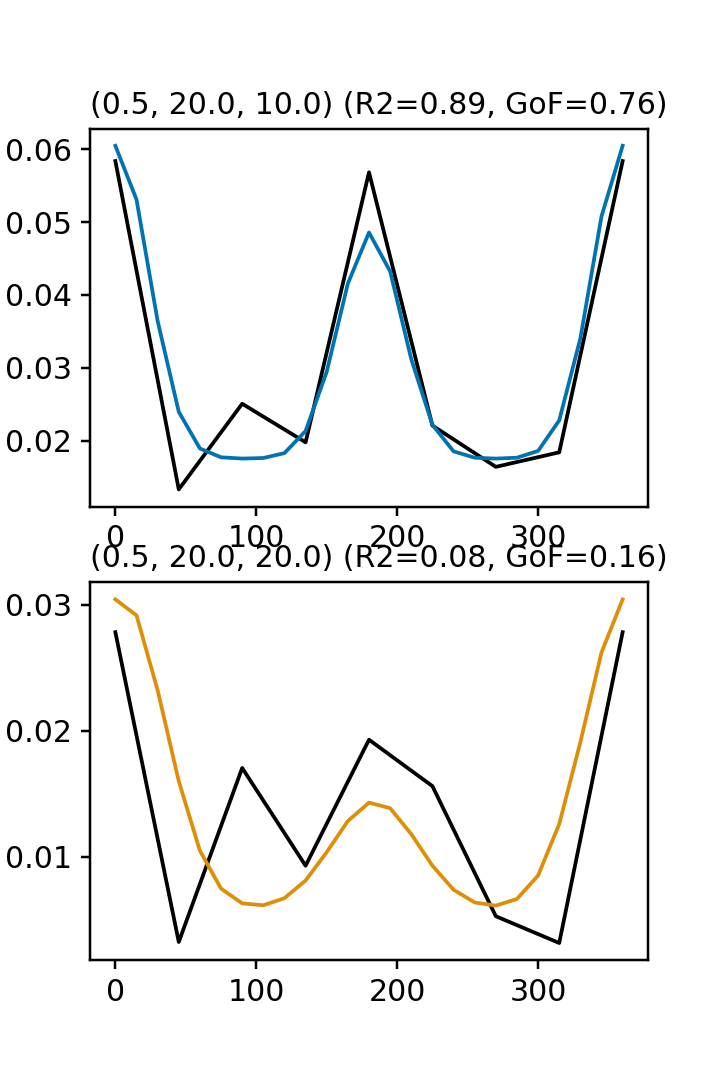

R2: 0.89, GoF:0.76
R2: 0.08, GoF:0.16


In [28]:
f, axn = pl.subplots(len(stimparams), 1, figsize=(4, 6))
# stimparam = (0.1, 200.0, 20.0)
roi=91

colors=sns.color_palette(palette='colorblind', n_colors=5)
#ax.plot(thetas, origr, color='k')
for si, stimparam in enumerate(stimparams):
    bootr = bootresults[roi][stimparam].copy()
    ax=axn.flat[si]
    orig_ = bootr['data']['responses'].mean(axis=0)
    orig_data = np.abs(orig_ - np.mean(orig_))
    orig_r = osi.interp_values(orig_data)
    ax.plot(xvs, orig_r, color='k')
    
    r2comb, gof, fitr = osi.evaluate_fits(bootr, interp=True)
    print('R2: %.2f, GoF:%.2f' % (r2comb, gof))
    
    ax.plot(xvs, fitr, color=colors[si])
    ax.set_title('%s (R2=%.2f, GoF=%.2f)' % (str(stimparam), r2comb, gof), loc='left', fontsize=12)
    
    pl.subplots_adjust(wspace=0.5)

In [336]:
# params = [c for c in bootr['results'].columns if 'stim' not in c]
# avg_metrics = osi.average_metrics_across_iters(bootr['results'][params])

# orig_ = bootr['data']['responses'].mean(axis=0)
# orig_data = np.abs(orig_ - np.mean(orig_))

# origr = osi.interp_values(orig_data)
# thetas = bootr['fits']['xv']


# cpopt = tuple(avg_metrics[['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']].values[0])
# fitr = osi.double_gaussian( thetas, *cpopt)
# r2_comb, _ = osi.coeff_determination(origr, fitr)

# print(r2_comb)

0.2418513676326346


In [34]:
stimparams

[(0.5, 20.0, 10.0), (0.5, 20.0, 20.0)]

<IPython.core.display.Javascript object>


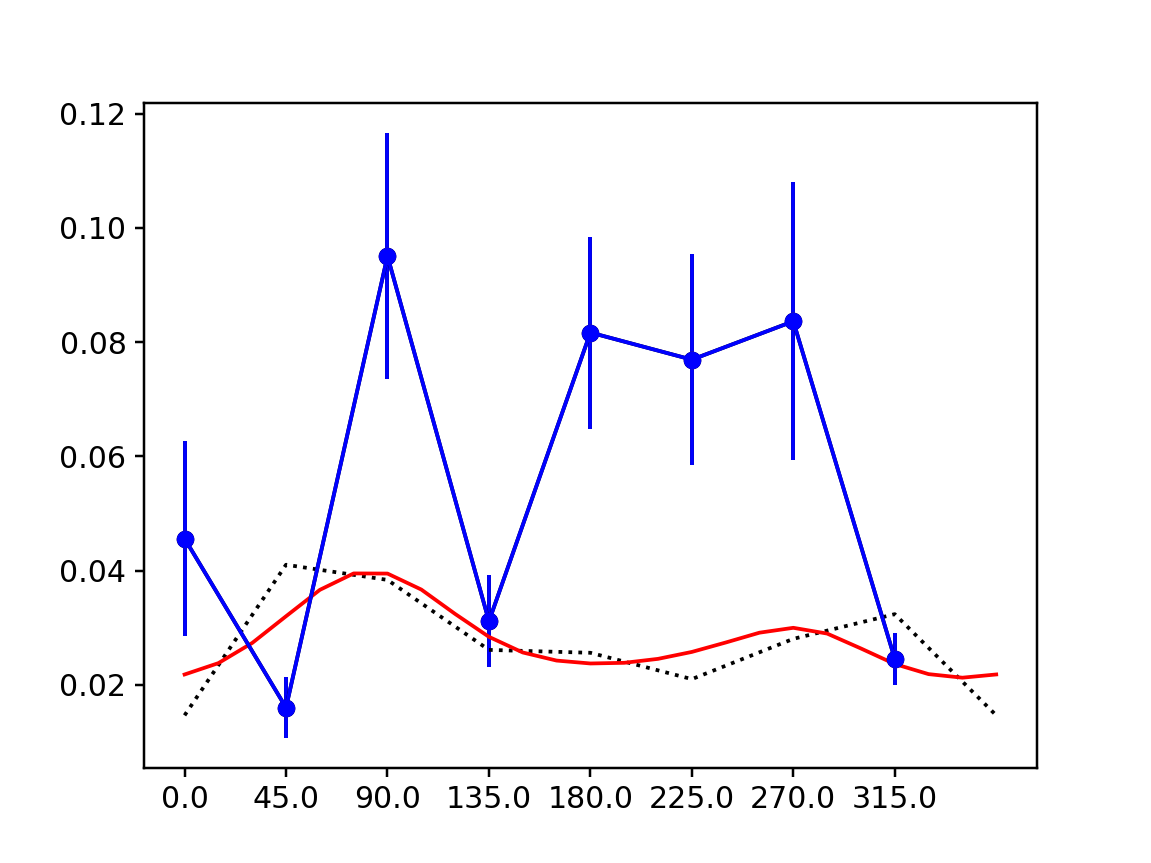

[Text(0,0,u'0.0'),
 Text(0,0,u'45.0'),
 Text(0,0,u'90.0'),
 Text(0,0,u'135.0'),
 Text(0,0,u'180.0'),
 Text(0,0,u'225.0'),
 Text(0,0,u'270.0'),
 Text(0,0,u'315.0')]

In [826]:
roi=151 # 91 #91
roi_df = gdf.get_group(roi) #rdf_list[roi]

stimparam = bootresults[roi].keys()[1] #0.5, 20.0, 20.0)
#stimparam = (0.1, 20.0, 10.0)
currcfgs = configsets[stimparam]

# Get all trials of current set of cfgs:
rdf = roi_df[roi_df['config'].isin(currcfgs)][['config', 'trial', response_type]]
responses_df = pd.concat([pd.Series(g[response_type], name=c).reset_index(drop=True)\
                          for c, g in rdf.groupby(['config'])], axis=1)
datadict = {'responses': responses_df,
            'tested_values': tested_oris}

bootr = bootresults[roi][stimparam].copy()
orig_ = bootr['data']['responses'].mean(axis=0)
orig_data = np.abs(orig_ - np.mean(orig_))
orig_r = osi.interp_values(orig_data)
    
fig, ax = pl.subplots()
xvs = bootr['fits']['xv']
yvs = bootr['fits']['yv'].mean(axis=1)
fitvs = bootr['fits']['fitv'].mean(axis=1)

n_intervals_interp = bootr['fits']['n_intervals_interp']
meas_xvs = xvs[0::n_intervals_interp][0:-1]
meas_responses = responses_df.mean(axis=0)
sem_responses = responses_df.sem(axis=0)

adj_responses = np.abs(meas_responses-meas_responses.mean())

ax.plot(meas_xvs, orig_, markerfacecolor='k', marker='o', lw=0)
ax.errorbar(meas_xvs, orig_, yerr=sem_responses, color='k', marker='o')
ax.errorbar(meas_xvs, meas_responses, yerr=sem_responses, color='b', marker='o')
ax.plot(xvs, yvs, color='k', linestyle=':')
ax.plot(xvs, fitvs, color='r')

ax.set_xticks(meas_xvs)
ax.set_xticklabels(meas_xvs)

<IPython.core.display.Javascript object>


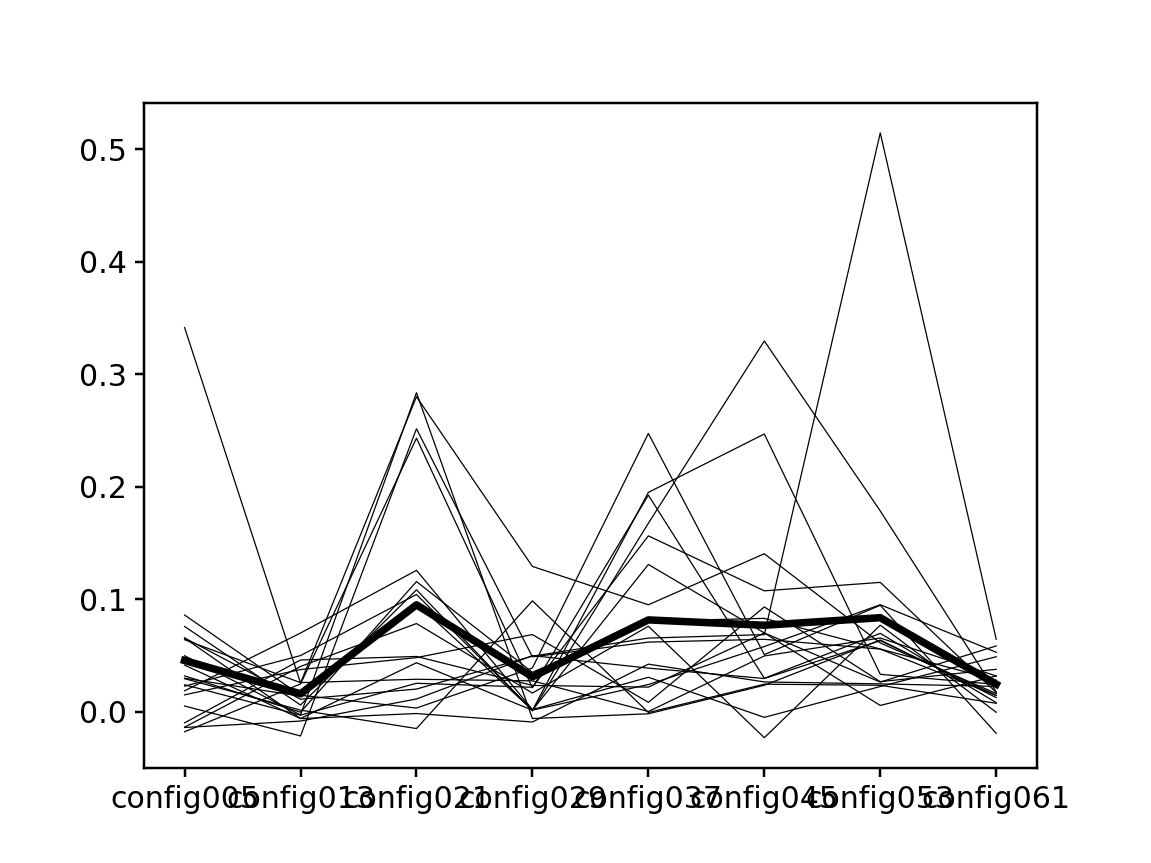

In [827]:
pl.figure()
for i in np.arange(0, responses_df.shape[0]):
    pl.plot(responses_df.iloc[i], 'k', lw=0.5)
pl.plot(responses_df.mean(axis=0), 'k', lw=3)

In [788]:
# responses_df = pd.concat([g[response_type].rename(columns={response_type: c}) \
#                for c, g in rdf.groupby(['config'])], axis=1)\
#     .rename(columns=dict((i, c) for i, (c, g) in enumerate(rdf.groupby(['config']))))


In [828]:
# Get all trials of current set of cfgs:
# rdf = roi_df[roi_df['config'].isin(currcfgs)][['config', 'trial', response_type]]
# responses_df = pd.concat([pd.Series(g[response_type], name=c).reset_index(drop=True)\
#                           for c, g in rdf.groupby(['config'])], axis=1)


In [829]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.pyc'>

In [830]:
# Bootstrap distN of responses (rand w replacement):
bootdf_tmp = pd.concat([responses_df.sample(n_resamples, replace=True).mean(axis=0) \
                        for ni in range(n_bootstrap_iters)], axis=1)
bootdf_tmp.index = [sdf['ori'][c] for c in bootdf_tmp.index]
bootdf = np.abs((bootdf_tmp - bootdf_tmp.mean()))

<IPython.core.display.Javascript object>


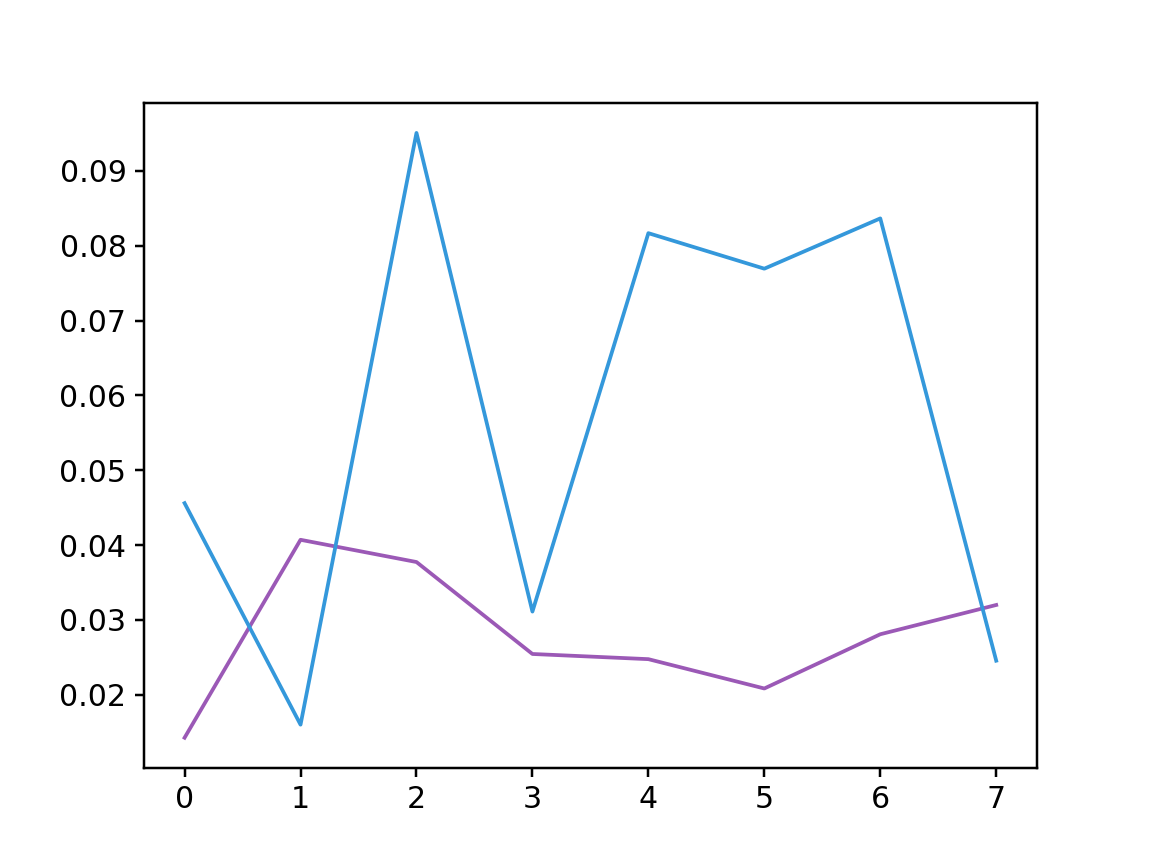

In [831]:
pl.figure()
pl.plot(bootdf.mean(axis=1).values)
pl.plot(np.arange(0,8), responses_df.mean(axis=0))

In [792]:
# bootv_df = bootr['fits']['yv'].copy()
# fitv_df = bootr['fits']['fitv'].copy()
# fitv_df.head()


In [832]:

responsedf = bootdf[0].copy()
resps_interp = osi.interp_values(responsedf, 
                                 n_intervals=n_intervals_interp, wrap_value=responsedf[0])

# initial params
init_params = osi.get_init_params(responsedf)
r_pref, r_null, theta_pref, sigma, r_offset = init_params
init_bounds = ([0, 0, -np.inf, sigma/2., -r_pref], [3*r_pref, 3*r_pref, np.inf, np.inf, r_pref])

rfit, fitv = osi.fit_osi_params(oris_interp, resps_interp, init_params, bounds=init_bounds)

rfit

{'pcov': array([[ 7.98108189e-02,  8.22118636e-02,  5.53649734e-02,
          3.65971321e+01, -8.78869055e-02],
        [ 8.22118636e-02,  8.47169506e-02,  5.77123069e-02,
          3.77132596e+01, -9.05508925e-02],
        [ 5.53649734e-02,  5.77123069e-02,  1.90533004e+02,
          2.45761339e+01, -6.14326121e-02],
        [ 3.65971321e+01,  3.77132596e+01,  2.45761339e+01,
          1.68878285e+04, -4.03468515e+01],
        [-8.78869055e-02, -9.05508925e-02, -6.14326121e-02,
         -4.03468515e+01,  9.68098946e-02]]),
 'popt': array([1.88172853e-02, 3.71359331e-02, 6.59334104e+01, 6.64946788e+01,
        4.10746976e-03]),
 'success': True}

25
360.0
0.2682582107214202
0.7199626245282119


<IPython.core.display.Javascript object>


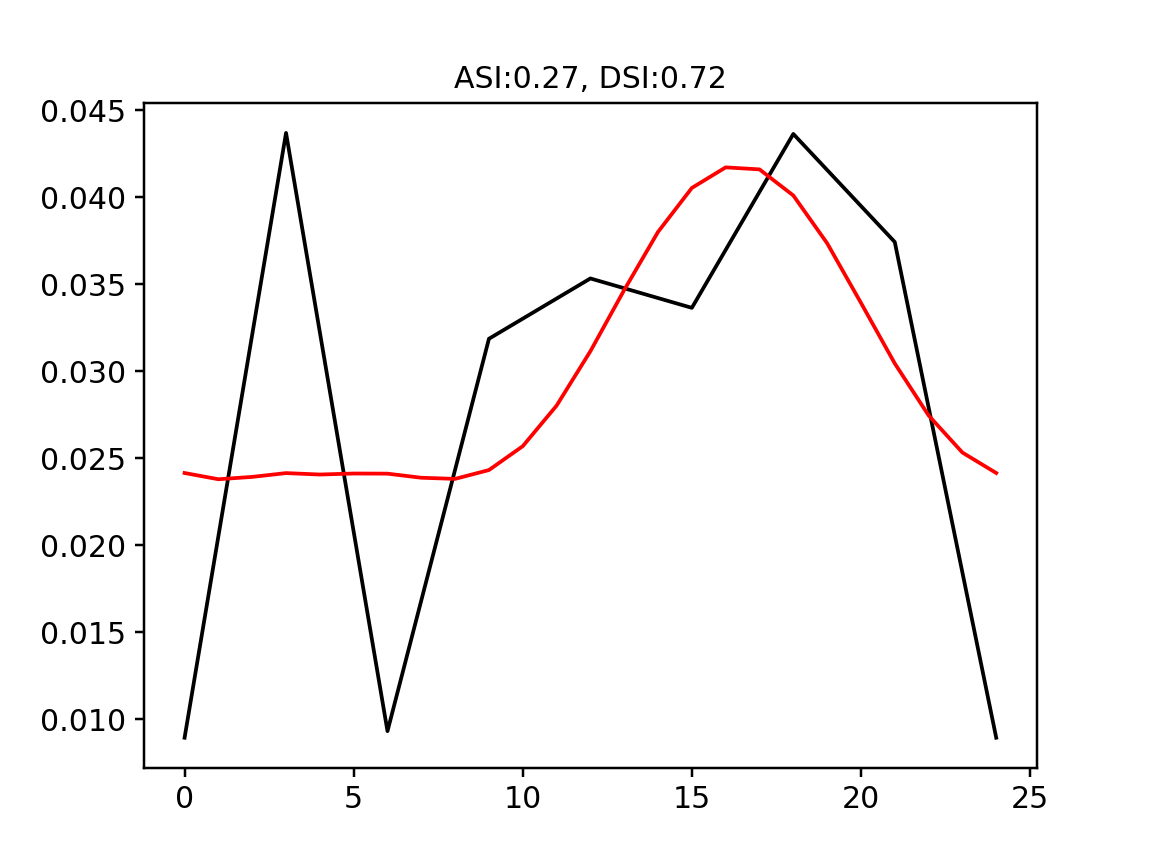

In [833]:
rvec = fitv.copy()

response_vector = putils.convert_range(rvec, oldmin=rvec.min(), oldmax=rvec.max(), 
                    newmin=0, newmax=1)

print(len(response_vector))
thetas = copy.copy(oris_interp)
print(max(thetas))

if np.max(thetas) > np.pi:
    thetas = [np.deg2rad(th) for th in thetas]
        
# asi = np.abs(np.sum([theta_resp * np.exp((2j*(2.*np.pi)*theta_val) / (2.*np.pi))\
#                     for theta_resp, theta_val \
#                     in zip(response_vector, thetas)]))/np.sum(np.abs(response_vector))
# print(asi)


# dsi = np.abs(np.sum([theta_resp * np.exp((1j*(2.*np.pi)*theta_val) / (2.*np.pi))\
#                     for theta_resp, theta_val \
#                     in zip(response_vector, thetas)]))/np.sum(np.abs(response_vector))
# print(dsi)

asi=osi.get_ASI(response_vector, oris_interp)
dsi=osi.get_DSI(response_vector, oris_interp)
print(asi)
print(dsi)


pl.figure()
pl.title("ASI:%.2f, DSI:%.2f" % (asi, dsi))
pl.plot(resps_interp, 'k')
pl.plot(fitv, 'r')
#pl.plot(test_trace, 'r')

In [804]:
print(osi.get_ASI(response_vector, oris_interp))
print(osi.get_DSI(response_vector, oris_interp))


0.536977029508975
0.03527375166775683


In [820]:
reload(osi)

<module 'pipeline.python.classifications.bootstrap_osi' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.py'>

In [834]:
fitp = bootdf.apply(osi.fit_ori_tuning, args=[n_intervals_interp], axis=0) # Get fit params

In [835]:
fitp.T

asi       dsi  response_null  response_offset  response_pref  \
0    0.268258  0.719963   3.713593e-02         0.004107       0.018817   
1    0.541293  0.707119   4.688924e-03         0.011811       0.040165   
2    0.726727  0.641676   4.680472e-03         0.025851       0.025794   
3    0.567557  0.859024   3.383391e-04         0.013908       0.044494   
4    0.475047  0.299473   2.615474e-02         0.007110       0.036142   
5    0.573931  0.708488   6.660343e-03         0.018138       0.056054   
6    0.482862  0.197003   9.303581e-02        -0.051270       0.084382   
7    0.580399  0.872298   4.874259e-19         0.030784       0.021362   
8    0.589528  0.875624   3.892698e-08         0.015352       0.056011   
9    0.502579  0.405048   1.452630e-02         0.020341       0.032361   
10   0.460850  0.364130   3.048146e-02        -0.001502       0.038770   
11   0.579495  0.349943   1.109729e-02         0.009800       0.024509   
12   0.418976  0.516236   4.478918e-02        -0.014482       0.070965   
13   0.540002  0.452559   1.315332e-02         0.012600       0.036600   
14   0.734603  0.925791   1.966982e-18         0.017246       0.023247   
15   0.498868  0.176317   3.164198e-02        -0.000799       0.040208   
16   0.480523  0.241674   6.947726e-02        -0.040885       0.078127   
17   0.421156  0.806867   3.971754e-15         0.024036       0.021569   
18   0.734336  0.925657   2.721201e-09         0.031309       0.018846   
19   0.550207  0.605170   1.043688e-02         0.015897       0.051083   
20   0.648699  0.168910   3.330125e-02         0.014376       0.048383   
21   0.410310  0.441512   6.333252e-02        -0.041408       0.070466   
22   0.503625  0.842232   3.577781e-38         0.012895       0.027049   
23   0.486202  0.217686   8.162079e-02        -0.043220       0.095891   
24   0.457037  0.350918   6.809141e-02        -0.034321       0.087082   
25   0.666158  0.903192   7.996903e-27         0.012807       0.058500   
26   0.459983  0.458988   2.130512e-02         0.000687       0.047167   
27   0.475606  0.648970   4.848928e-03         0.013429       0.027099   
28   0.072964  0.448163   6.912876e-02        -0.048839       0.086681   
29   0.553785  0.861904   1.008191e-20         0.018221       0.025933   
..        ...       ...            ...              ...            ...   
970  0.673027  0.604728   1.454849e-02         0.018803       0.002962   
971  0.455820  0.397404   7.205748e-02        -0.047565       0.091885   
972  0.048729  0.437693   5.709537e-02        -0.049283       0.082528   
973  0.490460  0.301225   8.011117e-02        -0.041549       0.107560   
974  0.662552  0.902205   1.612801e-18         0.031142       0.022931   
975  0.431361  0.810053   9.016694e-40         0.019925       0.027846   
976  0.725183  0.922529   1.582125e-14         0.018683       0.023111   
977  0.613137  0.724125   3.909198e-03         0.020932       0.036391   
978  0.022240  0.455254   4.421930e-02        -0.041764       0.073044   
979  0.558076  0.863572   2.088544e-18         0.013135       0.057789   
980  0.234568  0.412355   5.221213e-02        -0.033079       0.055547   
981  0.643608  0.895274   9.281334e-40         0.022498       0.035862   
982  0.728472  0.176295   1.215153e-02         0.029210       0.017736   
983  0.449111  0.438809   2.438329e-02         0.010830       0.039619   
984  0.548747  0.663342   2.720193e-03         0.016307       0.020338   
985  0.464833  0.312073   8.795757e-02        -0.055754       0.106098   
986  0.537912  0.546256   9.177290e-03         0.020895       0.035271   
987  0.482293  0.269395   8.446710e-02        -0.047761       0.075528   
988  0.475354  0.227312   7.689376e-02        -0.043186       0.069196   
989  0.548853  0.862043   5.845837e-10         0.020273       0.036810   
990  0.709067  0.554815   5.270373e-03         0.035091       0.026857   
991  0.610151  0.883262   3.753339e-40         0.015076       0.038073   
992  0.135652 

In [836]:
fitv = fitp.apply(osi.fit_from_params, args=[tested_oris], axis=0)
# Interpolate boot responses
yvs = bootdf.apply(osi.interp_values, args=[n_intervals_interp, True], axis=0, reduce=True)
xvs = osi.interp_values(tested_oris, n_intervals=n_intervals_interp, wrap_value=360)
fitdict = {'xv': xvs, 'yv': yvs, 'fitv': fitv, 'n_intervals_interp': n_intervals_interp}
# Create dataframe of all fit params
fitp = fitp.T
fitp['r2'] = osi.get_r2(fitv, yvs) # Calculate coeff of deterim
fitp['cell'] = [roi for _ in range(n_bootstrap_iters)]

oridict = {'results': fitp,
             'fits': fitdict,
             'data': datadict,
             'stimulus_configs': currcfgs}

In [837]:
bootr= {'results': fitp,
             'fits': fitdict,
             'data': datadict,
             'stimulus_configs': currcfgs}

In [839]:
r2comb, gof, fitr = osi.evaluate_fits(bootr, interp=True)
print(r2comb, gof, fitr)

(0.10585892621269999, 0.14069804908411931, array([0.01297068, 0.01648838, 0.02257848, 0.03023274, 0.03778854,
       0.0433157 , 0.04525288, 0.04306183, 0.03735393, 0.02973503,
       0.02213564, 0.01618526, 0.01284554, 0.012343  , 0.01427203,
       0.01774149, 0.02154989, 0.02444292, 0.02545554, 0.02430902,
       0.02132524, 0.01750015, 0.01409424, 0.012296  , 0.01297068]))


In [767]:
# num=[]
# num2=[]
# for theta_resp, theta_val in zip(response_vector, thetas):

#     val = theta_resp * np.exp((2j*360.*theta_val)/360.)
#     val2 = theta_resp * np.exp((1j*360.*theta_val)/360.)
#     print('%.1f, %.2f, %.2f' % (theta_val, abs(val), abs(val2)))
#     num.append(val)
#     num2.append(val2)

In [768]:
t1s=[]
t2s=[]
#for resp, theta_val in zip(response_vector, thetas):
theta_rads = [np.deg2rad(theta_val) for theta_val in thetas]

t1_vals = [resp*np.sin(2.*theta) for resp, theta_val in zip(response_vector, theta_rads)]
t2_vals = [resp*np.cos(2.*theta) for resp, theta_val in zip(response_vector, theta_rads)]

num1 = np.sum(t1_vals)**2 + np.sum(t2_vals)**2
print(np.sqrt(num1), np.sum(response_vector))
asi = np.sqrt(np.sum(t1_vals)**2 + np.sum(t2_vals)**2) / np.sum(response_vector)
print(asi)
# for t1, t2, resp in zip(t1s, t2s, response_vector):
#     osi = np.sqrt((t1+t2)) / np.sum([r for r in resp])

(4.431217921883826, 4.431217921883826)
1.0


<IPython.core.display.Javascript object>


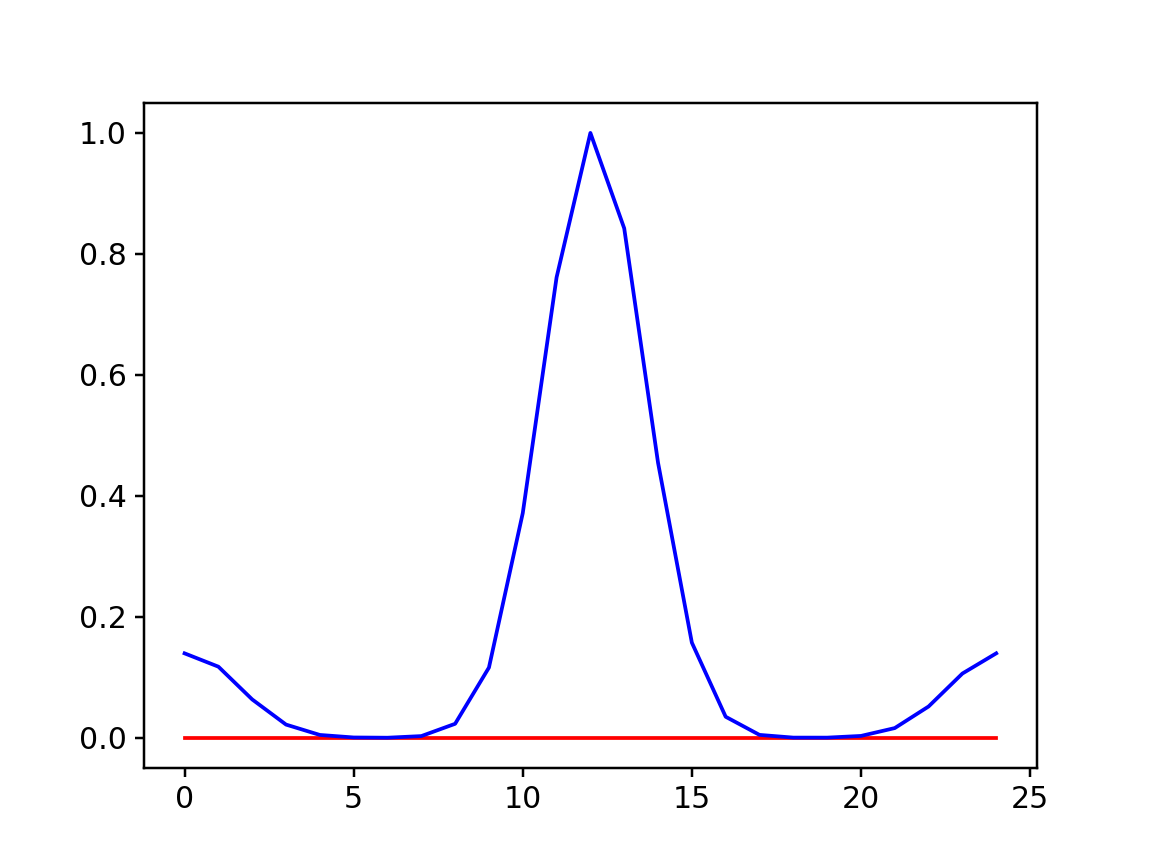

In [769]:
pl.figure()
#pl.plot([np.cos(2*theta) for theta in theta_rads])
#pl.plot([np.sin(2*theta) for theta in theta_rads])

pl.plot(t1_vals,color='r')
pl.plot(t2_vals, color='b')

In [770]:
osi.get_ASI(response_vector, oris_interp) #[0:])

0.7441435258710177

<IPython.core.display.Javascript object>


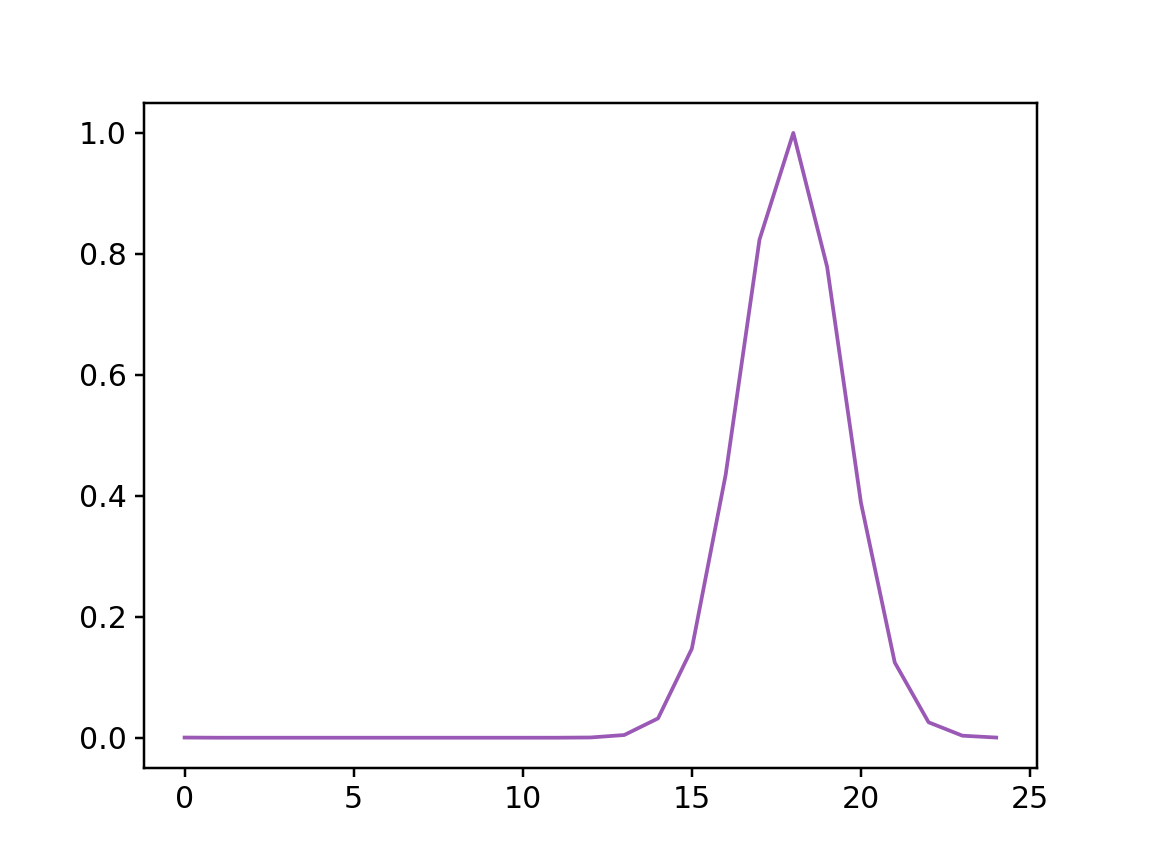

In [717]:
pl.figure()
pl.plot(response_vector)

<IPython.core.display.Javascript object>


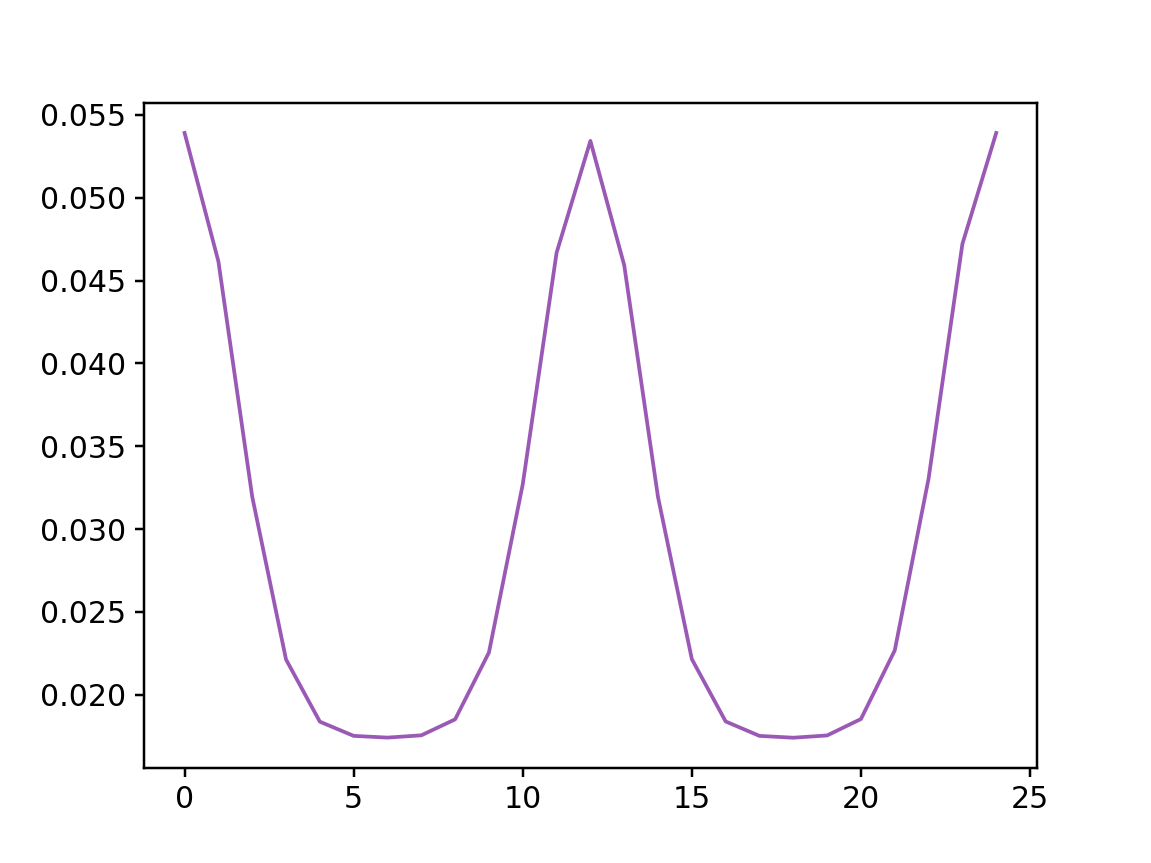

In [557]:
pl.figure()
pl.plot(fitv_df.mean(axis=1))


In [420]:
fitp = bootdf.apply(fit_ori_tuning, args=[n_intervals_interp], axis=0) # Get fit params

NameError: name 'bootdf' is not defined

In [397]:
osi.get_ASI(fitv_df[0], oris_interp[0:])

0.9953668845278751

<IPython.core.display.Javascript object>


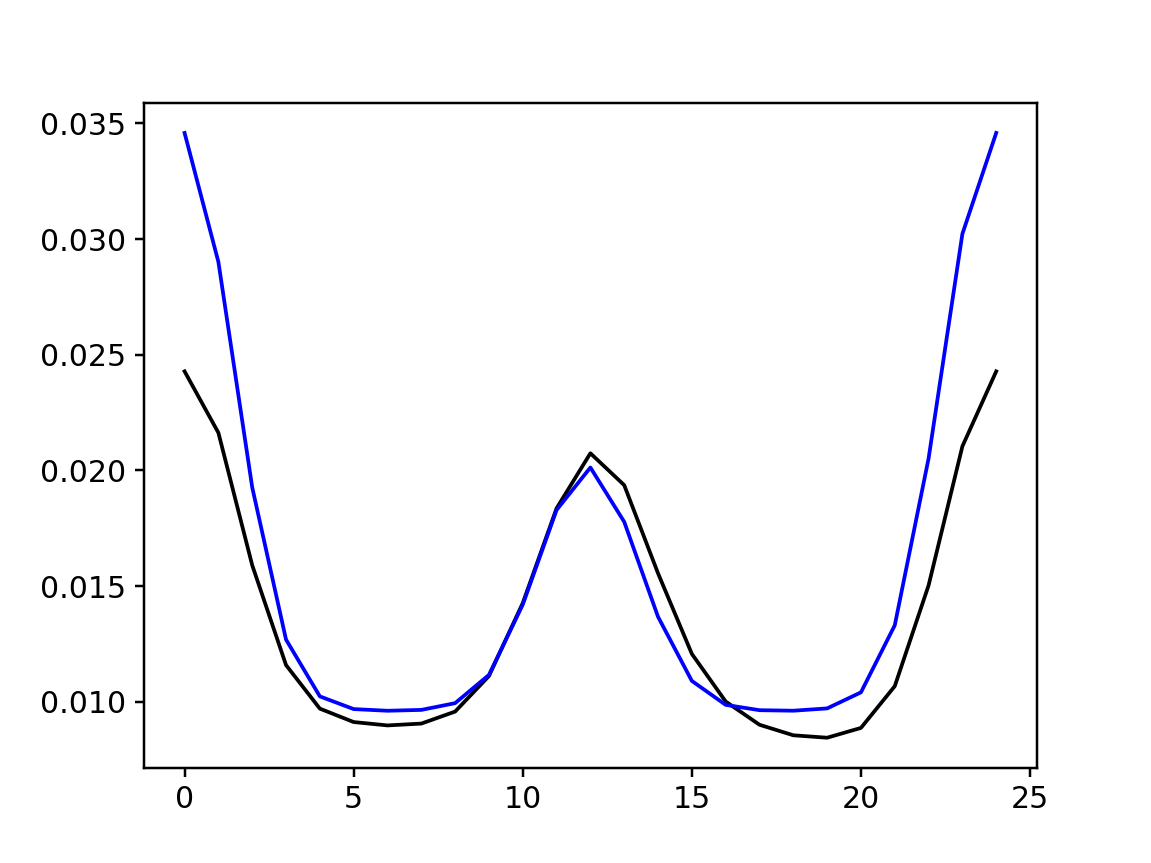

In [408]:
pl.figure()
pl.plot(fitvs, color='k')
pl.plot(fitv_df[0], 'b')

In [152]:

if len(roidfs) > 0:
    rmetrics = pd.concat(roidfs, axis=0)
    # rename indices to rois
    new_ixs = [int(i) for i in rmetrics['cell'].values]
    rmetrics.index = new_ixs
    rmetrics_by_cfg = pd.concat(metrics_by_config, axis=0)

print("... %i of %i cells pass GoF thr %.2f" % (len(goodrois), len(passrois), gof_thr))


... 3 of 4 cells pass GoF thr 0.10


In [571]:
roi = 5
roi_df = rdf_list[roi]
roi = roi_df.index[0]
print(roi)

5


In [573]:
statdf[220].max()

7

In [574]:
for ckey, currcfgs in configsets.items():
    print(ckey, len(np.where(statdf[roi].loc[currcfgs] >= min_nframes_above)[0]) >= min_cfgs_above)

((0.1, 200.0, 20.0), False)
((0.5, 20.0, 20.0), True)
((0.5, 200.0, 20.0), False)
((0.1, 20.0, 20.0), False)
((0.1, 20.0, 10.0), False)
((0.5, 200.0, 10.0), False)
((0.5, 20.0, 10.0), False)
((0.1, 200.0, 10.0), False)


<IPython.core.display.Javascript object>


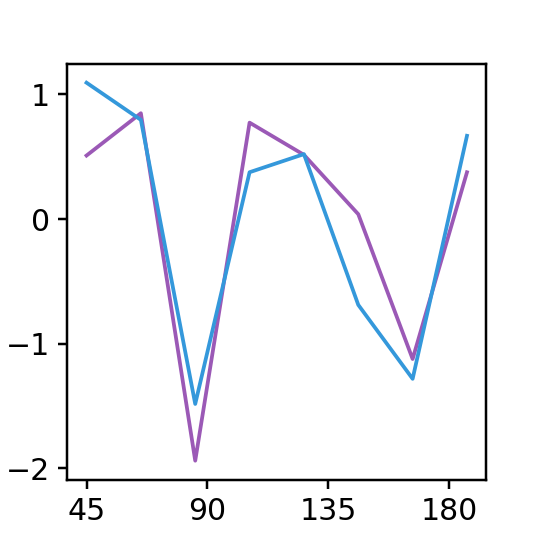

In [593]:
#ckey = (0.1, 20.0, 20.0)

fig, ax = pl.subplots(figsize=(3,3))

for ckey in configsets.keys():
    if ckey not in bootresults[0].keys():
        continue
    ticks = [sdf['ori'][cfg] for cfg in bootresults[0][ckey]['data']['responses'].columns]
    meanvals = bootresults[0][ckey]['data']['responses'].mean(axis=0)
    vals = (meanvals - meanvals.mean())/meanvals.std()
    ax.plot(ticks, vals)
    ax.set_xticklabels(ticks)

In [390]:
[sdf['ori'][cfg] for cfg in bootresults[0][ckey]['data']['responses'].columns]

[0, 45, 90, 135, 180, 225, 270, 315]

In [577]:
ckey = (0.5, 20.0, 20.0)
currcfgs = configsets[ckey]

# Get all trials of current set of cfgs:
rdf = roi_df[roi_df['config'].isin(currcfgs)][['config', 'trial', response_type]]
responses_df = pd.concat([pd.Series(g[response_type], name=c).reset_index(drop=True)\
                          for c, g in rdf.groupby(['config'])], axis=1)
datadict = {'responses': responses_df,
            'tested_values': tested_oris}

# Bootstrap distN of responses (rand w replacement):
bootdf = pd.concat([responses_df.sample(n_resamples, replace=True).mean(axis=0) for ni in range(n_bootstrap_iters)], axis=1)
bootdf.index = [sdf['ori'][c] for c in bootdf.index]

In [578]:
bootdf.head()

0         1         2         3         4         5         6    \
0    0.026166  0.026309  0.031667  0.009155  0.026252  0.023505  0.037891   
45   0.011159  0.004318  0.010068  0.008775  0.014631  0.006741  0.007272   
90   0.006648  0.011585  0.003816  0.007973  0.008127  0.001838  0.004224   
135  0.008434  0.015034  0.021968  0.013756  0.007786  0.009800  0.007843   
180  0.013294  0.009860  0.009047  0.008030  0.010488  0.007728  0.005013   

          7         8         9      ...          990       991       992  \
0    0.016867  0.012783  0.021465    ...     0.019351  0.023283  0.022423   
45   0.015010  0.017098  0.011133    ...     0.007705  0.014296  0.008389   
90   0.008845 -0.001229  0.006868    ...     0.009322  0.003887  0.002784   
135  0.014259  0.017371  0.012926    ...     0.014293  0.008844  0.009200   
180 -0.001054  0.006983  0.008148    ...     0.005380  0.004012  0.012189   

          993       994       995       996       997       998       999  
0    0.029972  0.027268  0.022619  0.026314  0.031795  0.023209  0.032971  
45   0.007309  0.011616  0.013026  0.007279  0.010921  0.008000  0.012239  
90   0.006259  0.003621  0.010335  0.009436  0.010371  0.007226  0.001998  
135  0.006625  0.003396  0.015514  0.019367  0.008958  0.018478  0.019480  
180  0.015306  0.014861  0.006959  0.005728  0.013013  0.009066  0.009784  

[5 rows x 1000 columns]

In [579]:
#bootdf_f = bootdf.copy()
bootdf_f = abs((bootdf - bootdf.mean()))

In [580]:
n_intervals_interp=3
fitp = bootdf_f.apply(osi.fit_ori_tuning, args=[n_intervals_interp], axis=0) # Get fit params

In [581]:
print(fitp.dropna().shape[0] == 0)
fitv = fitp.apply(osi.fit_from_params, args=[tested_oris], axis=0)
yvs = bootdf_f.apply(osi.interp_values, args=[n_intervals_interp, True], axis=0, reduce=True)
xvs = osi.interp_values(tested_oris, n_intervals=n_intervals_interp, wrap_value=360)

False


<IPython.core.display.Javascript object>


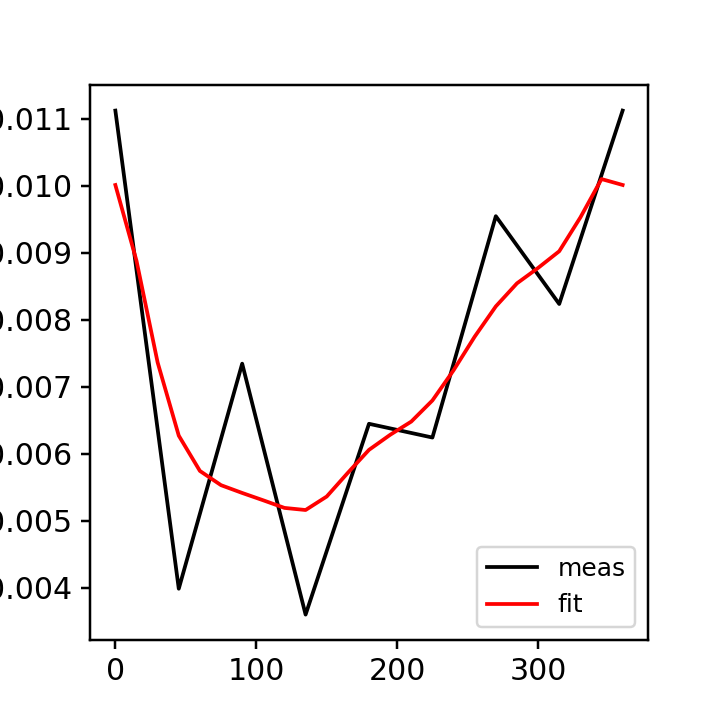

In [582]:
fit_means = fitv.T.mean()
meas_means = yvs.T.mean()
fig, ax = pl.subplots(figsize=(4,4))
ax.plot(xvs, meas_means, color='k', label='meas')
ax.plot(xvs, fit_means, color='r', label='fit')
ax.legend()

In [583]:
fitp.shape

(7, 1000)

In [584]:
fitp = fitp.T
fitp['r2'] = osi.get_r2(fitv, yvs) # Calculate coeff of deterim
fitp['cell'] = [roi for _ in range(n_bootstrap_iters)]
fitp.head()

asi       dsi  response_null  response_offset  response_pref  \
0  0.053131  0.326327   1.526190e-02        -0.015384       0.024732   
1  0.130055  0.414058   1.938381e-03         0.000135       0.011818   
2  0.197103  0.229088   7.385167e-38         0.006261       0.008755   
3  0.096753  0.073065   9.746392e-04         0.002249       0.002100   
4  0.050562  0.254236   1.419992e-02        -0.013414       0.021505   

       sigma  theta_pref        r2  cell  
0  81.731144  308.659350  0.509625     5  
1  65.670114  -13.376144  0.906017     5  
2  22.500000    3.243599  0.608097     5  
3  22.515052  283.375721  0.589081     5  
4  83.641646  305.488426  0.421918     5

<IPython.core.display.Javascript object>


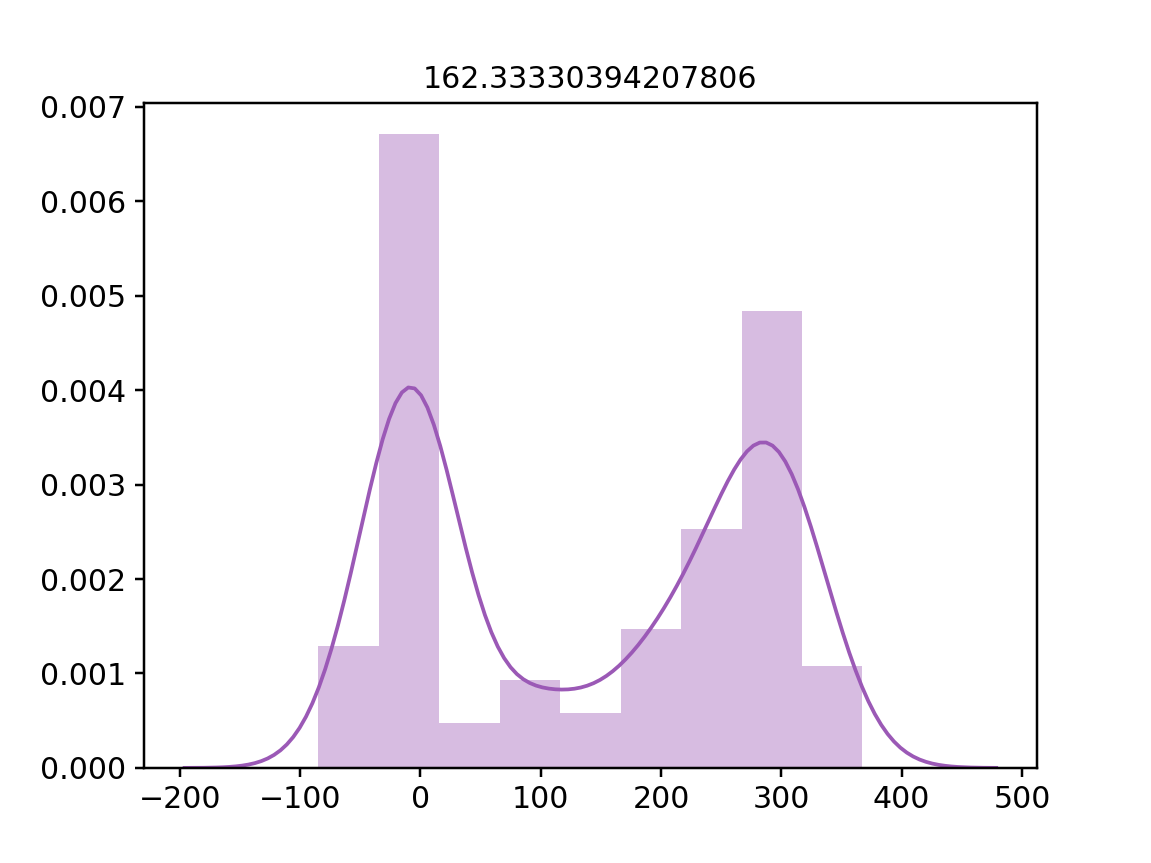

Text(0.5,1,u'162.33330394207806')

In [585]:
vs = fitp.dropna()['theta_pref'].values.astype(float)

f, ax = pl.subplots()
sns.distplot(vs, ax=ax)
ax.set_title(np.median(vs))


<IPython.core.display.Javascript object>


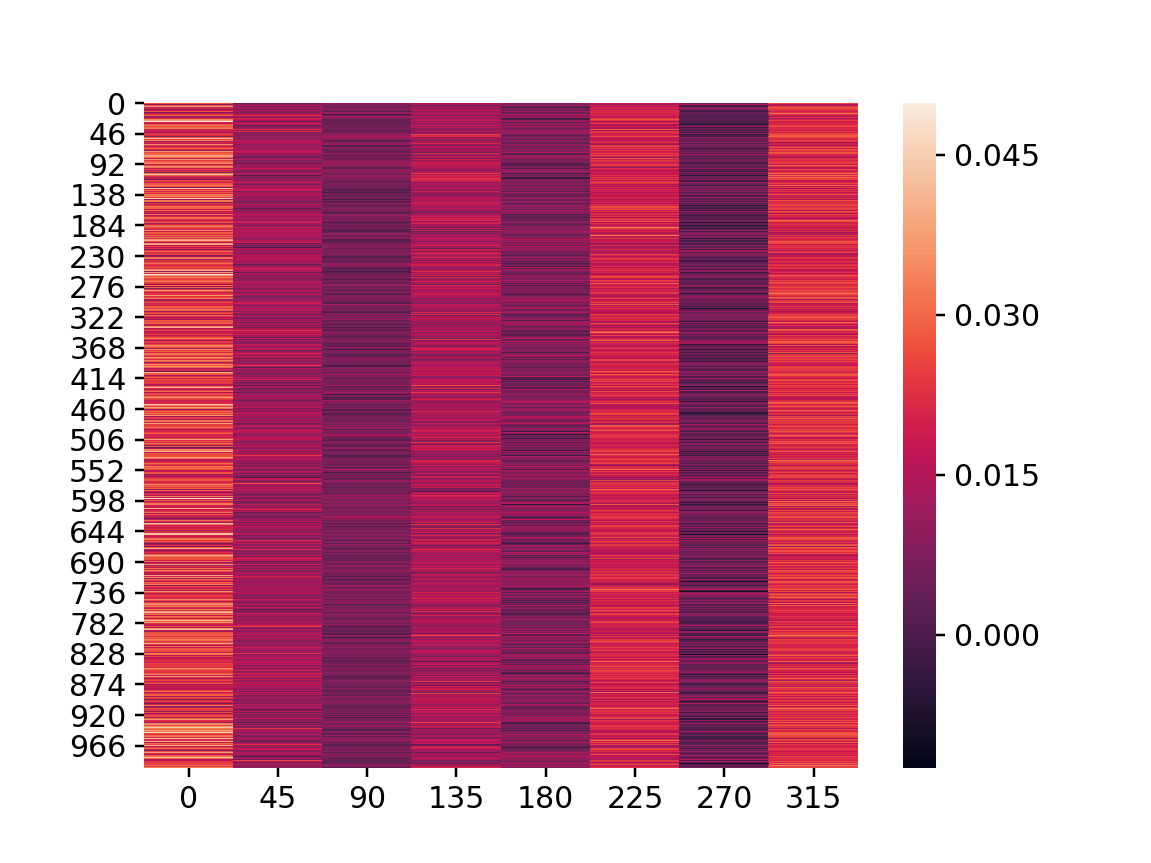

In [586]:
pl.figure()
sns.heatmap(bootdf.T)

#### Test loading new

In [35]:
 bootresults, fitparams = osi.load_tuning_results(traceid_dir=traceid_dir,
                                                        fit_desc=fit_desc)

... loading existing fits


In [36]:
traceid_dir

'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e'

In [37]:
print(len(bootresults.keys()))
rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=0.)


115
... 98 (of 113) fitable cells pass GoF thr 0.00


In [44]:
gof_thr=0.6
fitdf = osi.aggregate_all_iters(bootresults, fitparams, gof_thr=gof_thr)

... aggregating (113 cells attempted)
... aggregating (98 cells fit at least 1 tuning curve).


In [41]:
data_identifier = '%s\n%s' % ('|'.join([animalid, session, fov, run_name]), fit_desc)
data_identifier

'JC084|20190522|FOV1_zoom2p0x|combined_gratings_static\nfit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

In [51]:
# osi.plot_top_asi_and_dsi(fitdf, fitparams, fit_metric='gof', fit_thr=gof_thr, 
#                      topn=10, data_identifier=data_identifier)

fit_metric='gof'
fit_thr=gof_thr
topn=10

# Sort cells by ASi and DSi
df, top_asi_cells, top_dsi_cells = osi.sort_by_selectivity(fitdf, 
                                    fit_metric=fit_metric, fit_thr=fit_thr, topn=topn)
#% Set color palettes:
palette = sns.color_palette('cubehelix', len(top_asi_cells))
main_alpha = 0.8
sub_alpha = 0.01
asi_colordict = dict(( str(roi), palette[i]) for i, roi in enumerate(top_asi_cells))
for k, v in asi_colordict.items():
    asi_colordict[k] = (v[0], v[1], v[2], main_alpha)

dsi_colordict = dict(( str(roi), palette[i]) for i, roi in enumerate(top_dsi_cells))
for k, v in dsi_colordict.items():
    dsi_colordict[k] = (v[0], v[1], v[2], main_alpha)

asi_colordict.update({ str(-10): (0.8, 0.8, 0.8, sub_alpha)})
dsi_colordict.update({ str(-10): (0.8, 0.8, 0.8, sub_alpha)})



23 out of 98 fitable cells pass (gof=0.60)


<IPython.core.display.Javascript object>


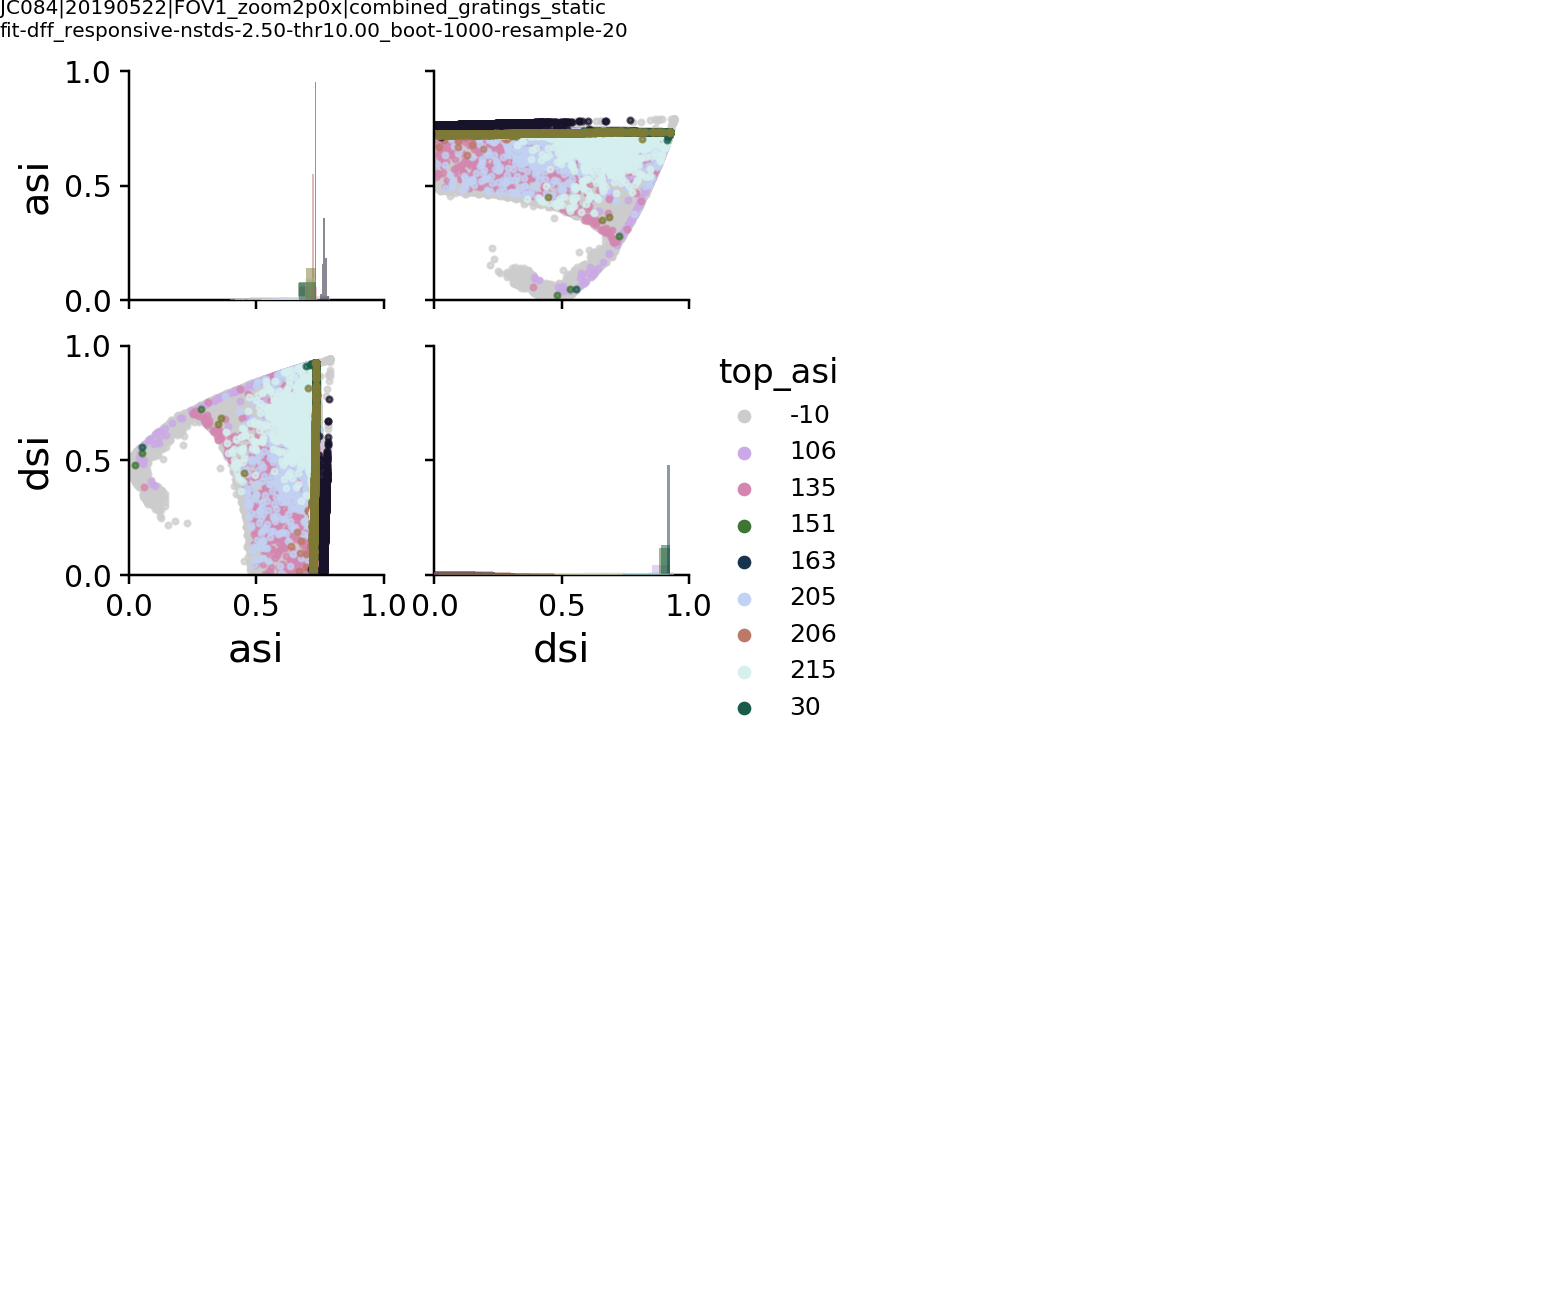

In [52]:
#% PLOT by ASI:
roi_fitdir = fitparams['directory']
n_bootstrap_iters = fitparams['n_bootstrap_iters']
nrois_fit = len(fitdf['cell'].unique())
nrois_pass = len(df['cell'].unique())

color_by = 'asi'
palette = asi_colordict if color_by=='asi' else dsi_colordict

fig = osi.compare_topn_selective(df, color_by=color_by, palette=palette)
putils.label_figure(fig, data_identifier)

figname = 'sort-by-%s_top%i_tuning-fit-thr%.2f_bootstrap-%iiters_%iof%i' % (color_by, topn, fit_thr, n_bootstrap_iters, nrois_pass, nrois_fit)

pl.savefig(os.path.join(roi_fitdir, '%s.svg' % figname))

In [54]:
rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=0.6)

... 23 (of 113) fitable cells pass GoF thr 0.60


In [58]:
rmetrics.head()

asi cell       dsi       gof        r2    r2comb response_null  \
30  0.734415   30  0.924851  0.846483  0.912242  0.920572   4.04628e-05   
51  0.593109   51  0.633836  0.637488  0.824164  0.835262    0.00604683   
65  0.552238   65  0.504818  0.642665  0.814598  0.883156     0.0196945   
75  0.513512   75  0.291964  0.664867  0.807911  0.817145     0.0893345   
91  0.766787   91  0.188526  0.759407  0.876644  0.886509     0.0310593   

   response_offset response_pref    sigma            stimulus theta_pref  
30       0.0169933     0.0887791  22.5002   (0.1, 20.0, 20.0)    271.104  
51      0.00334492     0.0274035  33.0353   (0.5, 20.0, 20.0)    167.528  
65     -0.00123384     0.0437136  38.5256  (0.1, 200.0, 10.0)    104.115  
75      -0.0468997       0.10722  53.6684  (0.1, 200.0, 10.0)    25.5413  
91       0.0175445     0.0429631  22.5099   (0.5, 20.0, 10.0)    1.13717

In [60]:
rmetrics_by_cfg[rmetrics_by_cfg['cell']==151]

asi   cell       dsi      gof        r2   r2comb  \
sf-0.10-sz-20-sp-20  0.732373  151.0  0.920924  0.74925  0.854975  0.86193   

                     response_null  response_offset  response_pref      sigma  \
sf-0.10-sz-20-sp-20       0.000118         0.012436       0.060858  22.634609   

                              stimulus  theta_pref  
sf-0.10-sz-20-sp-20  (0.1, 20.0, 20.0)   91.322666

In [61]:
bootresults[151].keys()

[(0.1, 20.0, 20.0), (0.1, 20.0, 10.0), (0.1, 200.0, 10.0)]

In [87]:
#rid=151
rid=91

curr_bootdict = bootresults[rid]
for stimparam, v in curr_bootdict.items():
    print(stimparam, v['results'].mean()[['r2comb', 'gof']])

((0.5, 20.0, 10.0), r2comb    0.886509
gof       0.759407
dtype: float64)
((0.5, 20.0, 20.0), r2comb    0.082628
gof       0.155328
dtype: float64)


In [89]:
paramdf = pd.concat([pd.Series(data=v['results'].mean(), name=str(stimparam)) \
           for stimparam, v in curr_bootdict.items()], axis=1)

print('rid: %i' % rid)
paramdf

rid: 91


(0.5, 20.0, 10.0)  (0.5, 20.0, 20.0)
asi                       0.766787           0.693317
dsi                       0.188526           0.526714
response_null             0.031059           0.008654
response_offset           0.017544           0.005725
response_pref             0.042963           0.024953
sigma                    22.509873          30.627908
theta_pref               78.467950          72.733491
r2                        0.876644           0.706854
cell                     91.000000          91.000000
r2comb                    0.886509           0.082628
gof                       0.759407           0.155328

# Aggregate all data

In [39]:
gdata.groupby(['visual_area', 'datakey']).count()

asi  cell  dsi  gof   r2  r2comb  \
visual_area datakey                                                 
Li          20190314_JC070_fov1   24    24   24   24   24      24   
            20190315_JC070_fov2    7     7    7    7    7       7   
            20190319_JC067_fov1    2     2    2    2    2       2   
            20190522_JC089_fov1    7     7    7    7    7       7   
            20190527_JC092_fov3    4     4    4    4    4       4   
            20190602_JC091_fov1   56    56   56   56   56      56   
            20190606_JC091_fov1   16    16   16   16   16      16   
            20190607_JC091_fov1   29    29   29   29   29      29   
            20190609_JC099_fov1    6     6    6    6    6       6   
            20190612_JC099_fov1   15    15   15   15   15      15   
            20190614_JC091_fov1   36    36   36   36   36      36   
            20190617_JC099_fov1    6     6    6    6    6       6   
            20191018_JC113_fov1   19    19   19   19   19      19   
            20191111_JC120_fov1    2     2    2    2    2       2   
Lm          20190306_JC061_fov2   44    44   44   44   44      44   
            20190314_JC070_fov2   16    16   16   16   16      16   
            20190512_JC083_fov1  129   129  129  129  129     129   
            20190513_JC078_fov1  170   170  170  170  170     170   
            20190525_JC084_fov1   51    51   51   51   51      51   
            20190603_JC080_fov1   78    78   78   78   78      78   
            20190618_JC097_fov1   25    25   25   25   25      25   
            20190627_JC091_fov1   33    33   33   33   33      33   
V1          20190511_JC083_fov1  120   120  120  120  120     120   
            20190512_JC083_fov1   27    27   27   27   27      27   
            20190522_JC084_fov1   95    95   95   95   95      95   
            20190613_JC097_fov1   57    57   57   57   57      57   
            20190616_JC097_fov1   91    91   91   91   91      91   
            20190617_JC097_fov1   68    68   68   68   68      68   
            20190622_JC085_fov1   84    84   84   84   84      84   
            20191006_JC110_fov1   71    71   71   71   71      71   

                                 response_null  response_offset  \
visual_area datakey                                               
Li          20190314_JC070_fov1             24               24   
            20190315_JC070_fov2              7                7   
            20190319_JC067_fov1              2                2   
            20190522_JC089_fov1              7                7   
            20190527_JC092_fov3              4                4   
            20190602_JC091_fov1             56               56   
            20190606_JC091_fov1             16               16   
            20190607_JC091_fov1             29               29   
            20190609_JC099_fov1              6                6   
            20190612_JC099_fov1             15               15   
            20190614_JC091_fov1             36               36   
            20190617_JC099_fov1              6                6   
            20191018_JC113_fov1             19               19   
            20191111_JC120_fov1              2                2   
Lm          20190306_JC061_fov2             44               44   
            20190314_JC070_fov2             16               16   
            20190512_JC083_fov1            129              129   
            20190513_JC078_fov1            170              170   
            20190525_JC084_fov1             51               51   
            20190603_JC080_fov1             78               78   
            20190618_JC097_fov1             25               25   
            20190627_JC091_fov1             33               33   
V1          20190511_JC083_fov1            120              120   
            20190512_JC083_fov1             27               27   
            20190522_JC084_fov1             95               95   
            201

In [40]:
# fracs = []
# for visual_area in visual_areas:
    
#     sk = [k for k, v in cellcounts.items() if k.split('_')[0]==visual_area \
#          and '-'.join(k.split('_')[1].split('-')[0:2]) not in excluded_sessions]
#     total = np.sum([cellcounts[k][0] for k in sk])
#     print "%s: %i" % (visual_area, total)
    
#     fvs = [float(v[0])/float(v[1]) for k, v in cellcounts.items() if k.split('_')[0]==visual_area]
#     fracs.append(pd.DataFrame({'fraction': fvs,
#                   'visual_area': [visual_area for _ in range(len(fvs))]}))
# fracs = pd.concat(fracs)

# Output dir

In [41]:
dstdir = os.path.join(outdir, 'general_stats')
if not os.path.exists(dstdir):
    os.makedirs(dstdir)
print("saving figures to:\n%s" % dstdir)

saving figures to:
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats


# Counts by dataset/visual area

In [42]:
curr_gof=0.5
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)
cellcounts.groupby(['visual_area']).sum()


responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                        296          1423        136.0       69.0   
Lm                        667          1645        360.0      187.0   
V1                        823          2057        413.0      220.0   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        5.259943             2.691583        5.689683  
Lm                        4.137374             2.154541        4.240243  
V1                        4.147129             2.264204        4.315775

In [43]:
cols = [k for k in cellcounts.columns if 'over' not in k and k not in ['animalid', 'session', 'fov']]
grouped_counts = cellcounts[cols]\
                    .melt(id_vars=['visual_area', 'datakey'], 
                          var_name='type', value_name='n_cells')


<IPython.core.display.Javascript object>


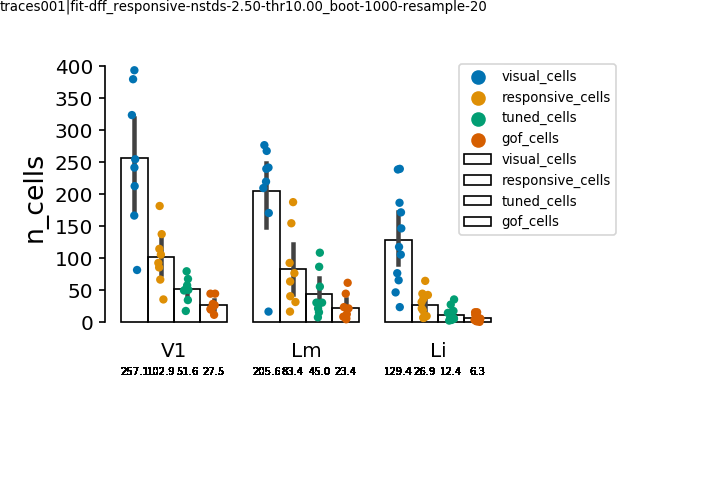

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'cell_counts_gof-0.50')


In [44]:
fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
sns.stripplot(x='visual_area', y='n_cells', hue='type',data=grouped_counts, ax=ax, 
             palette='colorblind', dodge=True, 
              hue_order=['visual_cells', 'responsive_cells', 'tuned_cells', 'gof_cells'],
              order=visual_areas, marker='o', s=5)

sns.barplot(x='visual_area', y='n_cells', hue='type',data=grouped_counts, ax=ax, 
             dodge=True, 
            hue_order=['visual_cells', 'responsive_cells', 'tuned_cells', 'gof_cells'],
            order=visual_areas, edgecolor=('k', 'k', 'k'), facecolor='none')
ax.set_xlabel('')
grouped_counts.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=6, 
                     fontcolor='k', xytext=(0, -30), fmt='%.1f')

 
putils.label_figure(fig, data_id)
sns.despine(bottom=True, trim=True, offset=2)

pl.subplots_adjust(left=0.15, right=0.7, bottom=0.3)
ax.legend(bbox_to_anchor=(1.3, 1), fontsize=8)
ax.tick_params(which='both', axis='x', size=0)

figname = 'cell_counts_gof-%.2f' % (curr_gof)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

In [36]:
cellcounts.groupby(['visual_area']).mean()

responsive_cells  visual_cells  tuned_cells  gof_cells  \
visual_area                                                           
Li                  26.909091     70.909091    12.363636   6.272727   
Lm                  83.375000    145.625000    45.000000  23.375000   
V1                 102.875000    198.875000    51.625000  27.500000   

             tuned_over_responsive  gof_over_responsive  gof_over_tuned  
visual_area                                                              
Li                        0.478177             0.244689        0.517244  
Lm                        0.517172             0.269318        0.530030  
V1                        0.518391             0.283026        0.539472

In [81]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

# Fraction tuned 

In [45]:
responsive_name='visual_cells'
curr_gof=0.5
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof, 
                              responsive_name='visual_cells')
currdata = gdata[gdata['gof'] >= curr_gof].copy().dropna()
#currdata = gdata[gdata['r2comb'] >= curr_gof].copy()

<IPython.core.display.Javascript object>


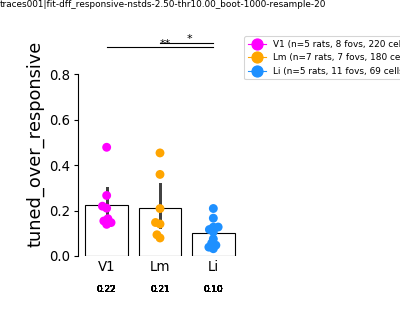

********* [tuned_over_responsive] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.226 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.005 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.043 (fdr_bh), reject H0=True
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'fraction_tuned_over_responsive_gof-0.50_all')


In [47]:
#fraction_plot = 'gof_over_responsive'
fraction_plot = 'tuned_over_responsive'
#fraction_plot = 'gof_over_tuned'

min_ncells=20

plotdf = cellcounts[cellcounts[responsive_name]>=min_ncells].copy().dropna()
multi_comp_test = 'fdr_bh'

ylim = 0.5 if 'gof' in fraction_plot else 1.0

fig, ax = pl.subplots(figsize=(5,4))
ax = sns.barplot(x="visual_area", y=fraction_plot, data=plotdf, #fliersize=0,
                 edgecolor=('k', 'k', 'k'), facecolor='none', ax=ax, order=visual_areas) #, alpha=0.7) #,\
plotdf.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=8, fontcolor='k', xytext=(0, -30))

sns.swarmplot(x='visual_area', y=fraction_plot, data=plotdf, ax=ax, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

# Legend.
leg = aggr.get_counts_for_legend(currdata[currdata['datakey']\
                                          .isin(plotdf['datakey'].unique())],
                                          area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.,1), fontsize=8)

# Stats
stats_fraction_tuned, ax = aggr.plot_mannwhitney(plotdf, metric=fraction_plot, ax=ax, 
                                                multi_comp_test=multi_comp_test, 
                                                 y_loc=ylim-0.1, offset=0.02)

# Formatting
sns.despine(bottom=True, trim=True, offset=2)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(top=0.9, left=0.2, bottom=0.2, right=0.6)


# Save
putils.label_figure(fig, data_id)
figname = 'fraction_%s_gof-%.2f_all' % (fraction_plot, curr_gof)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

#### Stats

In [48]:
c1 = cellcounts[cellcounts['visual_area']=='V1'][fraction_plot].values
c2 = cellcounts[cellcounts['visual_area']=='Lm'][fraction_plot].values
c3 = cellcounts[cellcounts['visual_area']=='Li'][fraction_plot].values

# Shapiro-Wilk normality test 
print("Shapiro-Wilk normality:", spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) )

# Levene variance test  
print(spstats.levene(c1, c2, c3))

F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                    ['Lm' for _ in range(len(c2))],
                    ['Li' for _ in range(len(c3))]])

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

('Shapiro-Wilk normality:', (0.7478983402252197, 0.007742543239146471), (0.8571469783782959, 0.11244698613882065), (0.9380653500556946, 0.49802854657173157))
LeveneResult(statistic=2.6579506520395317, pvalue=0.0906349896697677)
F statistic = 4.697 and probability p = 0.019
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.144    0.0143 0.2737  True 
  Li     V1    0.1223  -0.0074 0.252  False 
  Lm     V1   -0.0217  -0.1613 0.1179 False 
--------------------------------------------


# Visualize

In [49]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))

    for visual_area, tmpd in df.groupby(['visual_area']):
        if 'animalid' in tmpd.columns:
            nrats = len(tmpd['animalid'].unique())
        else:
            if 'datakey' in tmpd.columns:
                ratnames = [s.split('_')[1] for s in tmpd['datakey']]
                nrats = len(ratnames)
            
        if 'datakey' in tmpd.columns:
            nfovs = len(tmpd['datakey'].unique())
        if 'cell' in tmpd.columns or 'roi' in tmpd.columns:
            roistr = 'cell' if 'cell' in tmpd.columns else 'roi'
            ncells_total = len(tmpd[roistr].unique()) #.shape[0]
            label='%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells_total)
        else:
            label='%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf, label=label,
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

In [50]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

In [51]:
def plot_strip_and_bar(metric, df, use_median=False, order=['V1', 'Lm', 'Li'], ax=None,
                       area_colors=None, point_size=10, marker='o', use_bar=False, bar_scale=3,
                      annotate=True, fontsize=12, fontcolor='k', xytext=(0, -30)):
    '''
    Makes super standard plot of visual area (points=fov distributions or cells),
    and barplot shows mean or median.
    '''
    if ax is None:
        fig, ax = pl.subplots()

    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax, zorder=0, 
                  s=point_size, marker=marker, order=visual_areas, palette=area_colors)
    sns.barplot(x="visual_area", y=metric, data=currdata, 
                estimator=np.median if use_median else np.mean,
                edgecolor=('k', 'k', 'k') if use_bar else 'none', 
                facecolor='none', ax=ax, order=visual_areas)
    if not use_bar:
        sns.pointplot(x="visual_area", y=metric, data=df, 
                        ax=ax, order=visual_areas, ci=95,
                        markers='_', join=False, capsize=0., dodge=True,
                        scale=bar_scale, color='k')

    if annotate:
        df.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=fontsize, fontcolor=fontcolor, xytext=xytext)

    return ax


<IPython.core.display.Javascript object>


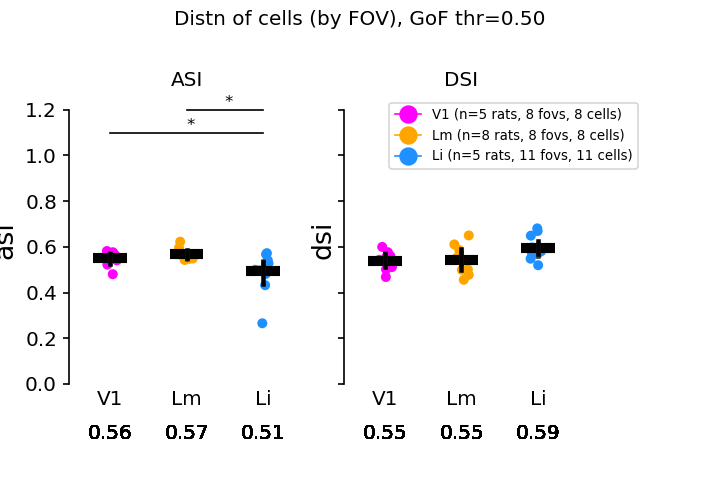

********* [asi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.396 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.032 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.014 (fdr_bh), reject H0=True
****************************
********* [dsi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.479 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.053 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.095 (fdr_bh), reject H0=False
****************************


Text(0.5,0.98,u'Distn of cells (by FOV), GoF thr=0.50')

In [52]:
use_gof=True
fit_thr=0.5

cdf = True
alpha = 1

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=fit_thr)
if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 

means_by_fov = currdata.groupby(['visual_area', 'datakey']).mean().reset_index()


fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
ax = plot_strip_and_bar('asi', means_by_fov, use_median=False, use_bar=False, ax=ax,
                    area_colors=area_colors, point_size=6, marker='o', bar_scale=3,
                    annotate=True, fontsize=12, xytext=(0, -30))


# Stats
stats_dsi, ax = aggr.plot_mannwhitney(means_by_fov, metric='asi', ax=ax, multi_comp_test=multi_comp_test, 
                                    y_loc=1, offset=0.1)
ax = axes[1]
ax.set_title('DSI')
ax = plot_strip_and_bar('dsi', means_by_fov, use_median=False, use_bar=False, ax=ax,
                    area_colors=area_colors, point_size=6, marker='o', bar_scale=3,
                    annotate=True, fontsize=12, xytext=(0, -30))
# Stats
stats_dsi, ax = aggr.plot_mannwhitney(means_by_fov, metric='dsi', ax=ax, multi_comp_test=multi_comp_test, 
                                    y_loc=1, offset=0.1)


# formatting
pl.subplots_adjust(wspace=0.2, right=0.8, top=0.8, bottom=0.2, left=0.1)
for ax in axes:
    sns.despine(ax=ax, bottom=True, offset=2, trim=True)
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xlabel('')

# Legend.
leg = aggr.get_counts_for_legend(means_by_fov, area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.3, 1), fontsize=8)


fig.suptitle("Distn of cells (by FOV), %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)

# for ax in axes:
#     ax.set_xlim([0, 1])
#     ax.set_xticks([0, 0.5, 1])
#     ax.set_yticks([0, 0.5, 1])
#     sns.despine(ax=ax, trim=True, offset=2)
    
    

## DistN ASI/DSI

<IPython.core.display.Javascript object>


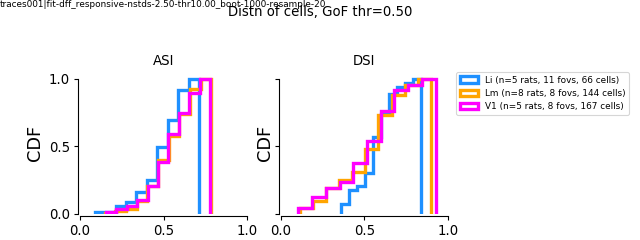

asi-dsi_best-config_gof-0.50__cdf_all


In [53]:
use_gof=True
fit_thr=0.5

cdf = True
alpha = 1

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=fit_thr)
if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 


fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
ax.set_title('ASI')
compare_tuning_metric(currdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(currdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)
ax.set_title('DSI')

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)

fig.suptitle("Distn of cells, %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)

for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
putils.label_figure(fig, data_id)
figname = 'asi-dsi_best-config_%s__%s_all' % (thr_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print figname

In [94]:
currdata.groupby(['visual_area']).mean()

asi        cell       dsi       gof        r2    r2comb  \
visual_area                                                                 
Li           0.511383  141.536232  0.586095  0.590663  0.796518  0.814293   
Lm           0.565136  128.957219  0.551166  0.610860  0.801900  0.814219   
V1           0.557908  147.809091  0.548032  0.615619  0.804479  0.816979   

             response_null  response_offset  response_pref      sigma  \
visual_area                                                             
Li                0.017302        -0.001747       0.046966  42.768771   
Lm                0.015005         0.002921       0.038786  38.658663   
V1                0.017980         0.002937       0.044962  38.716021   

             theta_pref  
visual_area              
Li           163.831922  
Lm           147.050591  
V1           168.219002

In [54]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.pyc'>

<IPython.core.display.Javascript object>


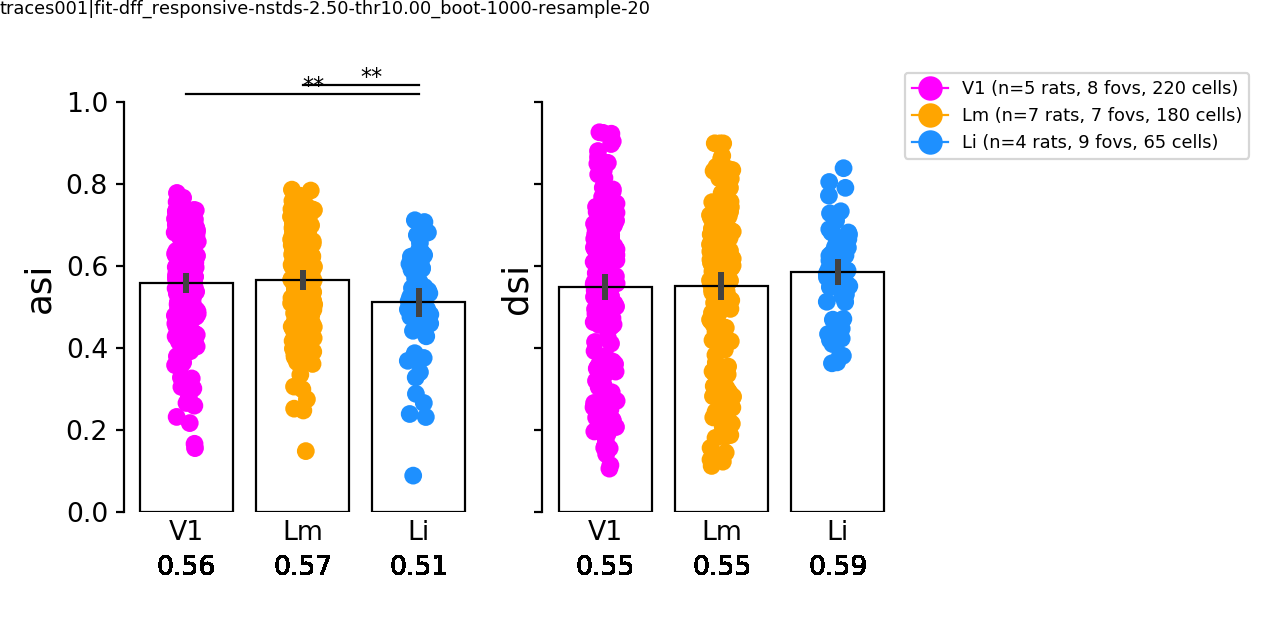

********* [asi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.318 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.005 (fdr_bh), reject H0=True
[('Lm', 'Li')] p=0.004 (fdr_bh), reject H0=True
****************************
********* [dsi] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.424 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.338 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.338 (fdr_bh), reject H0=False
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'ASI_DSI_allcells_gof-0.50')


In [96]:
use_gof=True
fit_thr=0.5

cdf = True
alpha = 1

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=fit_thr)
if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 


fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,4))
fig.patch.set_alpha(1)

# asi ---
ax=axes[0]
sns.stripplot(x='visual_area', y='asi', data=currdata, ax=ax, zorder=0, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
sns.barplot(x="visual_area", y='asi', data=currdata, ax=ax, 
                 edgecolor=('k', 'k', 'k'), facecolor='none', order=visual_areas)
currdata.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', xytext=(0, -25))
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')
# Stats
stats_asi, ax = aggr.plot_mannwhitney(currdata, metric='asi', ax=ax, 
                                                multi_comp_test=multi_comp_test, 
                                                 y_loc=1, offset=0.02)

# dsi ----
ax=axes[1]
sns.stripplot(x='visual_area', y='dsi', data=currdata, ax=ax, zorder=0, 
              color='k', s=8, marker='o',order=visual_areas, palette=area_colors)
sns.barplot(x="visual_area", y='dsi', data=currdata, #fliersize=0,
                 edgecolor=('k', 'k', 'k'), facecolor='none', ax=ax, order=visual_areas) #, alpha=0.7) #,\
currdata.apply(aggr.annotateBars, ax=ax, axis=1, fontsize=12, fontcolor='k', xytext=(0, -25))

ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

# Stats
stats_dsi, ax = aggr.plot_mannwhitney(currdata, metric='dsi', ax=ax, 
                                                multi_comp_test=multi_comp_test, 
                                                 y_loc=1, offset=0.02)


# Legend.
leg = aggr.get_counts_for_legend(currdata[currdata['datakey']\
                                          .isin(plotdf['datakey'].unique())],
                                          area_colors=area_colors, marker='o')
ax.legend(handles=leg, bbox_to_anchor=(1.,1), fontsize=8)


# Formatting
sns.despine(bottom=True, trim=True, offset=2)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(top=0.9, left=0.1, bottom=0.2, right=0.7)


# Save
putils.label_figure(fig, data_id)
figname = 'ASI_DSI_allcells_%s' % (thr_str)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

# Set output dir for aggregate figures

## Preferred theta

In [55]:
import matplotlib.patches as mpatches

In [56]:
def make_polar_legend(fig, widths, radii, ylim=None, yticks=None):
    # Legends
    leg = fig.add_axes([0.6, 0.7, 0.5, .2], polar=True)
    leg.set_theta_zero_location("N")
    
    bars = leg.bar(widths, radii, width=.2, bottom=0.0, lw=2)
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.7)
    leg.set_theta_zero_location("N")

    if ylim is not None:
        leg.set_ylim([0, ylim])
    else:
        ylim = leg.get_ylim()[-1]
    if yticks is not None:
        leg.set_yticks(yticks)
        leg.set_yticklabels(yticks)
    return leg

<IPython.core.display.Javascript object>


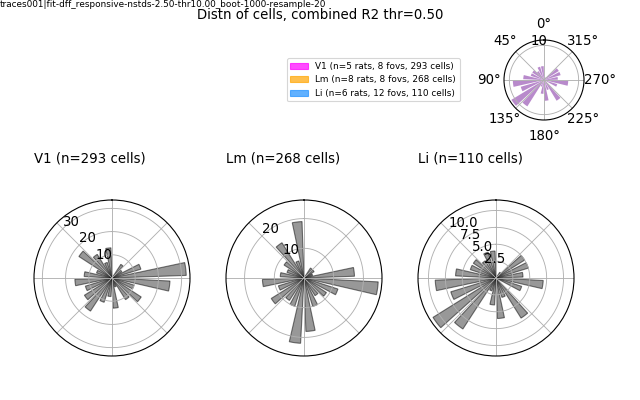

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_preferred_thetas_r2comb-0.50_dsi-0.50')


In [59]:
use_gof=False

filter_dsi=True

dsi_thr=0.5
fit_thr=0.5
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)

if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 

bin_size = 15
bins = np.arange(0, 360+bin_size, bin_size)

if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
polar_legend=True
fig = pl.figure(figsize=(8,5))
fig.patch.set_alpha(1)
bar_width = 10
lbs=[]
#yticks = np.linspace(0, ylim, nradii)
#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    tmpg = currdata.groupby(['visual_area']).get_group(visual_area).copy()
    
    degrees = tmpg['theta_pref'].values
    radians = np.rad2deg(degrees)
    
    ax = pl.subplot(1,3,vi+1, projection='polar')
    a, b = np.histogram(degrees, bins=bins)
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])

    ax = pl.subplot(1,3,vi+1, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    #ax.set_theta_direction(-1)

    ax.set_rlabel_position(45)
    ax.set_xticklabels([])
    #ax.set_ylim([0, 30])
    ax.set_title('%s (n=%i cells)' % (visual_area, tmpg.shape[0]), loc='left', fontsize=12, y=1.2)

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(wspace=0.2, top=0.8, left=0.05, right=0.9)


#for ax in fig.axes:
#ylim = max([ax.get_ylim() for ax in fig.axes])
    
if polar_legend:
    pl.subplots_adjust(wspace=0.2, top=0.5, left=0.05, right=0.9)
    ylim = None
    leg = make_polar_legend(fig, centers, a, ylim=ylim, yticks=None)


legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.7)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(-0.5, .5), loc='right', ncol=1, handles=legend_handles, fontsize=8)


fig.suptitle("Distn of cells, %s thr=%.2f" % ('GoF' if use_gof else 'combined R2', 
                                              fit_thr)) #curr_gof)
putils.label_figure(fig, data_id)

figname = 'polar_distn_preferred_thetas_%s' % thr_str
print(dstdir, figname)
pl.savefig(os.path.join(dstdir, '%s.svg' % figname))

In [87]:
currdata[currdata['datakey']=='20190522_JC084_fov1'].sort_values(by='dsi')

asi   cell       dsi       gof        r2    r2comb  response_null  \
98   0.595570   98.0  0.112420  0.744269  0.867533  0.876976       0.026848   
135  0.735287  135.0  0.135509  0.820356  0.900279  0.921092       0.073031   
91   0.766686   91.0  0.191354  0.752994  0.872534  0.881872       0.030578   
206  0.722037  206.0  0.223453  0.621803  0.788113  0.816852       0.023210   
232  0.712673  232.0  0.299944  0.730319  0.855392  0.889561       0.027919   
75   0.514057   75.0  0.300033  0.666737  0.808680  0.821545       0.087740   
125  0.539109  125.0  0.315235  0.514993  0.733637  0.734085       0.038399   
93   0.727109   93.0  0.364414  0.685340  0.813818  0.844795       0.023528   
136  0.565690  136.0  0.389502  0.648690  0.816332  0.862682       0.024490   
137  0.408438  137.0  0.502290  0.508744  0.751168  0.802102       0.029640   
177  0.464044  177.0  0.505653  0.586959  0.777014  0.900609       0.013214   
65   0.549056   65.0  0.524932  0.651415  0.820993  0.870074       0.019825   
55   0.549696   55.0  0.543516  0.604463  0.791755  0.786589       0.018539   
242  0.481929  242.0  0.547682  0.510824  0.753779  0.813960       0.006941   
205  0.680853  205.0  0.553360  0.731685  0.849136  0.857172       0.013022   
134  0.399649  134.0  0.581321  0.588154  0.787946  0.899128       0.014735   
0    0.375743    0.0  0.581361  0.500770  0.731655  0.800259       0.003201   
132  0.633494  132.0  0.589284  0.557175  0.848906  0.621296       0.011742   
17   0.698706   17.0  0.599067  0.523341  0.708746  0.692823       0.012288   
166  0.410185  166.0  0.609504  0.536976  0.773928  0.697926       0.010923   
216  0.490926  216.0  0.611412  0.525532  0.755527  0.713599       0.031022   
215  0.671792  215.0  0.626650  0.734894  0.853596  0.900104       0.006971   
57   0.326129   57.0  0.627216  0.549860  0.757418  0.796701       0.006354   
231  0.366289  231.0  0.640142  0.515822  0.770248  0.714390       0.009488   
255  0.674017  255.0  0.640223  0.870902  0.932759  0.947120       0.009655   
235  0.449839  235.0  0.645072  0.522455  0.750392  0.791686       0.017431   
203  0.383484  203.0  0.653752  0.608057  0.785145  0.904263       0.015488   
51   0.587629   51.0  0.654553  0.651721  0.832557  0.843665       0.005986   
179  0.585395  179.0  0.664249  0.674831  0.841494  0.862959       0.009050   
67   0.545474   67.0  0.667648  0.523715  0.789483  0.741292       0.008642   
59   0.458451   59.0  0.680952  0.513765  0.763908  0.772450       0.005593   
148  0.555184  148.0  0.695578  0.723922  0.868979  0.919647       0.006257   
45   0.582571   45.0  0.734326  0.611626  0.805361  0.858436       0.006237   
33   0.560842   33.0  0.742678  0.559555  0.795610  0.723587       0.005422   
119  0.559457  119.0  0.748830  0.541447  0.782412  0.794892       0.004926   
168  0.654217  168.0  0.752601  0.639415  0.804322  0.825005       0.003596   
107  0.506528  107.0  0.762923  0.556172  0.788158  0.723308       0.003786   
44   0.689931   44.0  0.781766  0.526031  0.781455  0.797662       0.004712   
144  0.596014  144.0  0.793800  0.701802  0.854266  0.870855       0.003697   
106  0.673791  106.0  0.821842  0.718378  0.858495  0.867766       0.004345   
156  0.583559  156.0  0.843714  0.567575  0.755453  0.709547       0.000546   
147  0.692661  147.0  0.897972  0.825721  0.914480  0.925733       0.000584   
151  0.732046  151.0  0.921954  0.748559  0.855346  0.861370       0.000212   
30   0.734430   30.0  0.924078  0.849024  0.913927  0.920232       0.000076   
163  0.734152  163.0  0.925497  0.772097  0.868158  0.873148       0.000009   

     response_offset  response_pref      sigma  theta_pref   session  \
98          0.002857       0.031315  33.071669  211.872616  20190522   
135         0.040635       0.097718  22.558950  266.404236  20190522   
91          0.017531       0.043036  22.508458    1.313660  20190522   
206         0.014762       0.037351  22.531939   48.061589  20190522   
232         0.0

In [101]:
[ax.get_ylim() for ax in fig.axes]

[(0.0, 29.4), (0.0, 19.95), (0.0, 9.45), (0.0, 9.45)]

## Preferred theta, scale radius by response value(dff)

<IPython.core.display.Javascript object>


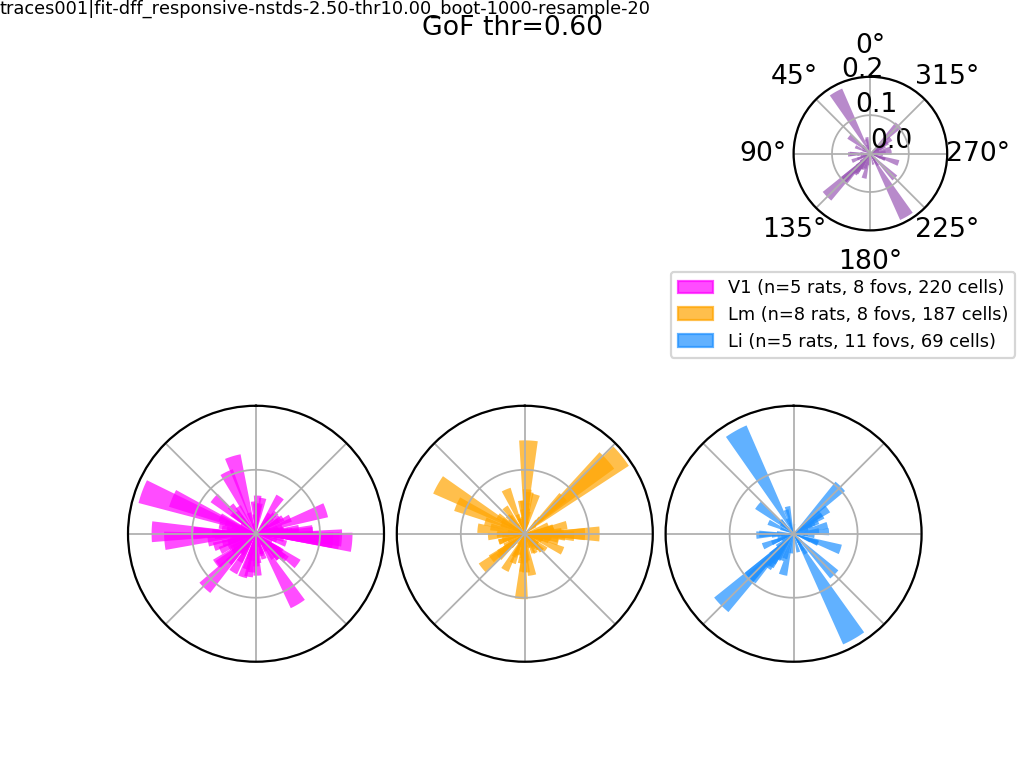

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_preferred_thetas_scale-dff_gof-0.50')


In [102]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
ylim = .2 #8 #.0

#ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    g = currdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )


    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area], lw=2)
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.7)
        
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    
    ax.set_ylim([0, ylim])
    yticks = np.linspace(0, ylim, 3)
    ax.set_yticks(yticks)
    #ax.set_yticks([0, 1.0, 1.5, 2.0])
    ax.set_yticklabels(['', '', ''])
    #ax.set_ylabel('dff')
    

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))


pl.subplots_adjust(top=0.5, wspace=0.05)
leg = make_polar_legend(fig, widths, radii, ylim=ylim, yticks=yticks)


legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.7)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(1.5, -0.55), loc='right', ncol=1, handles=legend_handles, fontsize=8)

putils.label_figure(fig, data_id)
fig.suptitle("GoF thr=%.2f" % curr_gof)
#ax.set_ylabel('dff')
figname = 'polar_distn_preferred_thetas_scale-%s_%s' % (response_type, thr_str)

#pl.savefig(os.path.join(dstdir, '%s.svg' % figname))
print(dstdir, figname)

## Distn of preferred theta if axis-selective

<IPython.core.display.Javascript object>


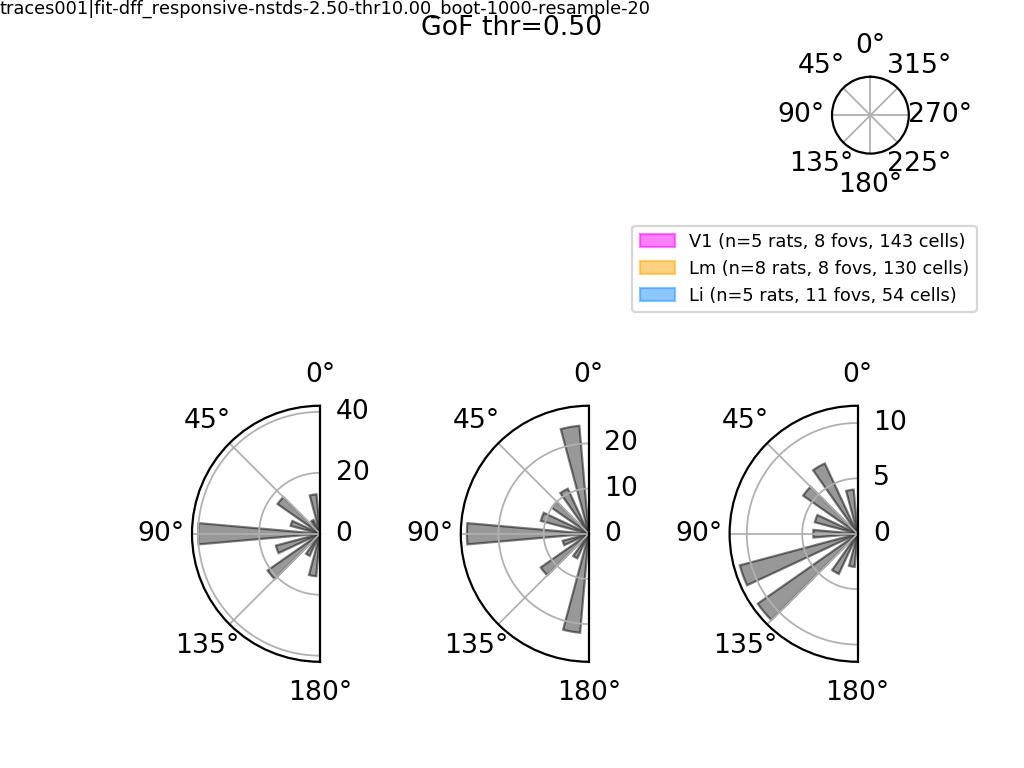

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'polar_distn_ASI_preferred_thetas__gof-0.50_dsi-0.50')


In [103]:

use_gof=True


filter_dsi=True

dsi_thr=0.5
fit_thr=0.5 
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)

if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 


if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
    
polar_legend=True
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = currdata[currdata['visual_area']==visual_area].copy() #get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['asi']>=0.1]

    thetas = np.deg2rad(np.arange(0, 180+45, 45))
    ax.set_xticks(thetas)
    #ax.set_xticklabels([''])
    ax.set_xlim([thetas[0], thetas[-1]])

    degrees = tmpg['theta_pref'].values % 180.

    bin_size = 20. #45.
    a, b =np.histogram(degrees, bins=np.arange(0, 180+bin_size, bin_size))
    centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
    
    ax = pl.subplot(1,3,vi+1, projection='polar')
    ax.bar(centers, a, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    
    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.shape[0]
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")
legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, 
           handles=legend_handles, fontsize=8)

# Label
putils.label_figure(fig, data_id)
fig.suptitle('%s thr=%.2f' % ('GoF' if use_gof else 'R2-comb', fit_thr)) #curr_gof))


figname = 'polar_distn_ASI_preferred_thetas__%s' % (thr_str)
#pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

# Hist (non polar) of preferred theta, assign by tested value

In [104]:
tested_values = np.linspace(0, 360-45., 8)
print(tested_values)
tested_thetas = list(tested_values.copy())
tested_thetas.append(360)

tested_thetas = np.array(tested_thetas)

gdata['tested_theta'] = [tested_thetas[np.where(np.abs(t-tested_thetas)==np.min(np.abs(t-tested_thetas)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
tested_thetas = tested_thetas[0:-1]

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [60]:
for t in gdata['theta_pref']:
    closest_match = int(tested_thetas[np.where(np.abs(t-tested_thetas)== np.min(np.abs(t-tested_thetas)))])
    #print round(t,2), closest_match

<IPython.core.display.Javascript object>


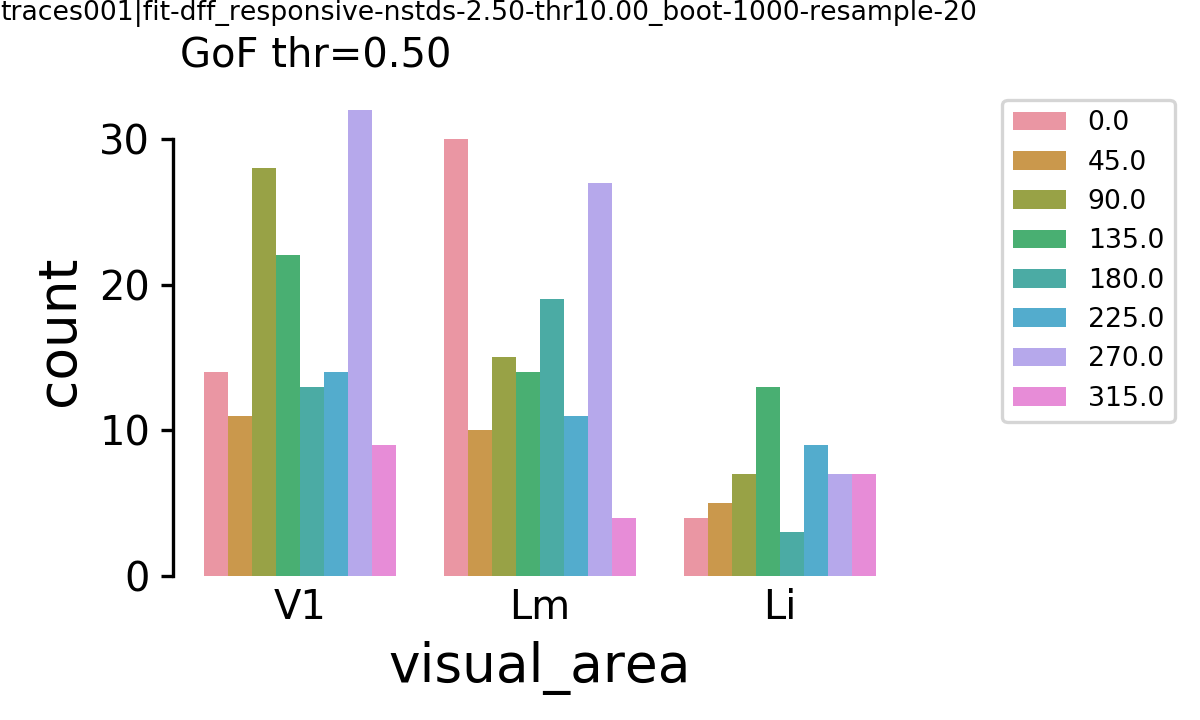

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'hist_tested_thetas__gof-0.50_dsi-0.50')


In [105]:
use_gof=True


filter_dsi=True

dsi_thr=0.5

fit_thr=0.5 
cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=curr_gof)

if use_gof:
    currdata = gdata[gdata['gof'] >= fit_thr].copy()
    thr_str = 'gof-%.2f' % fit_thr 
else:
    currdata = gdata[gdata['r2comb'] >= fit_thr].copy()
    thr_str = 'r2comb-%.2f' % fit_thr 

    
if filter_dsi:
    currdata = currdata[currdata['dsi']>=dsi_thr]
    thr_str = '%s_dsi-%.2f' % (thr_str, dsi_thr)
    
    
polar_legend=True
fig, ax = pl.subplots(figsize=(5,3), dpi=dpi)
sns.countplot(x='visual_area',  hue='tested_theta', data=currdata,
             ax=ax, order=visual_areas)
ax.legend(bbox_to_anchor=(1.4, 1), fontsize=8)
sns.despine(bottom=True, offset=2, trim=True, ax=ax)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.15, right=0.75, bottom=0.2)

putils.label_figure(fig, data_id)
ax.set_title("%s thr=%.2f" % ('GoF' if use_gof else 'R2-comb', fit_thr), loc='left')

figname = 'hist_tested_thetas__%s' % (thr_str)
pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

In [330]:
currdata.shape

(436, 17)

## overlay hists


<IPython.core.display.Javascript object>


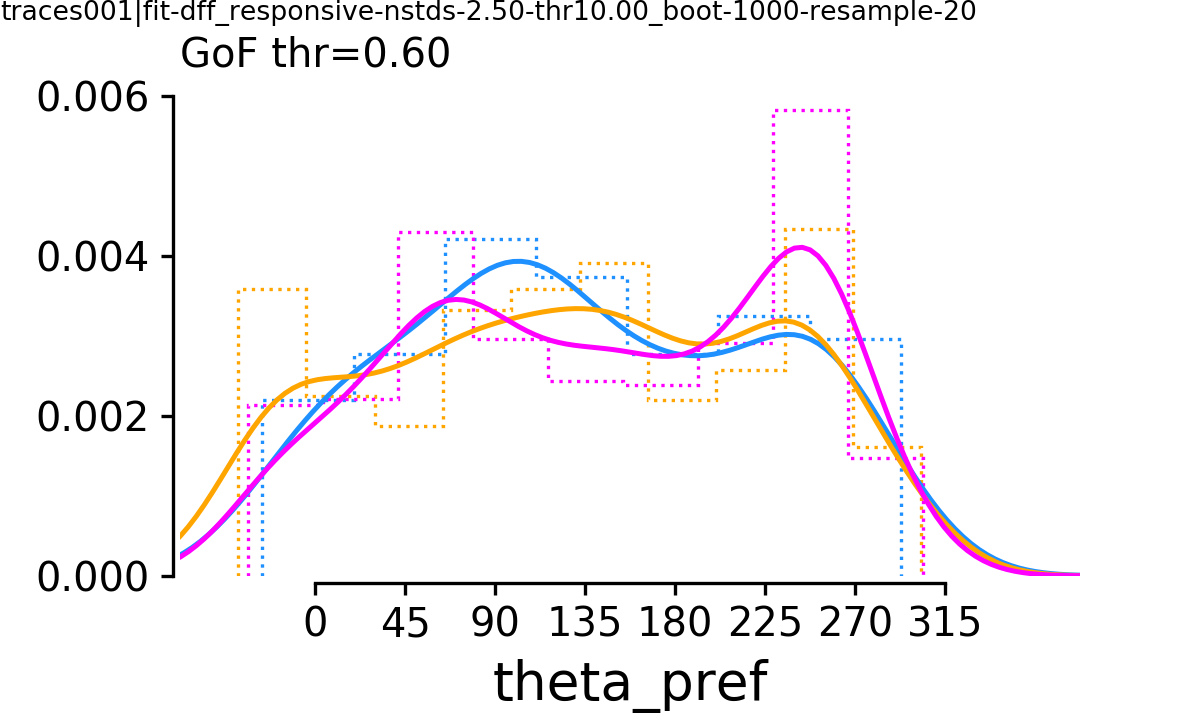

('/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20/general_stats', 'hist-overlay_tested_thetas__gof-0.60')


In [106]:
fig, ax = pl.subplots(figsize=(5,3), dpi=dpi)
for visual_area, g in gdata.groupby(['visual_area']):
    
    sns.distplot(g['theta_pref'], ax=ax, color=area_colors[visual_area],
                 rug=False, hist=True,
                 hist_kws={"histtype": "step", "linewidth": 1, "alpha": 1, "linestyle": ':'})
    
ax.set_xticks(tested_thetas+(45/2.))
ax.set_xticklabels([int(x) for x in tested_thetas])
ax.set_xlim([-45, 360+45])
    
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2)
putils.label_figure(fig, data_id)
ax.set_title("GoF thr=%.2f" % curr_gof, loc='left')
sns.despine(trim=True, offset=2, ax=ax)

figname = 'hist-overlay_tested_thetas__gof-%.2f' % (curr_gof)
pl.savefig(os.path.join(dstdir, '%s.png' % figname))
print(dstdir, figname)

# Receptive fields?

In [60]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf

In [61]:
#sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
rf_dsets = sdata[sdata['experiment'].isin(['rfs', 'rfs10'])]

#assigned_cells = seg.get_cells_by_area(rf_dsets)
#incl = aggr.get_dsets_with_max_rfs(rf_dsets, assigned_cells)
#incl[['visual_area', 'animalid', 'session', 'fov']].drop_duplicates().groupby(['visual_area']).count()
#edata = pd.concat([g for (v, k), g in sdata.groupby(['visual_area', 'datakey']) if k in incl['datakey'].values])

In [62]:
rf_fit_desc = fitrf.get_fit_desc(response_type='dff', do_spherical_correction=False)

aggr_rf_dir =  os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, rf_fit_desc))
df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_None_reliable.pkl') #% ( reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) or get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            r_df = pkl.load(f)
        if isinstance(r_df, dict):
            r_df = r_df['df']
    except Exception as e:
        get_positions = True
print(get_positions)


rf_cells = seg.get_cells_by_area(rf_dsets)
rf_df = aggr.get_rfdata(rf_cells, r_df, verbose=False, average_repeats=True)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False
Segmentation: missing 2 dsets


In [81]:
filter_gratings=False
use_gof=False
gratings_fit_thr=0.0
# ########################

cellcounts = update_gof_cells(updated_counts, gdata, gof_thr=gratings_fit_thr)
if not filter_gratings:
    gratings_df = gdata.copy()
else:
    if use_gof:
        gratings_df = gdata[gdata['gof'] >= gratings_fit_thr].copy()
        gratings_thr_str = 'gof-%.2f' % gratings_fit_thr 
    else:
        gratings_df = gdata[gdata['r2comb'] >= gratings_fit_thr].copy()
        gratings_thr_str = 'r2comb-%.2f' % gratings_fit_thr 

In [82]:
gratings_datakeys = gratings_df['datakey'].unique()
rf_datakeys = r_df['datakey'].unique()
print(len(gratings_datakeys))
print(len(rf_datakeys))

both_datakeys = np.intersect1d(gratings_datakeys, rf_datakeys)
print(len(both_datakeys))

29
61
24


In [83]:
RFS=[]
GFS=[]
for (visual_area, datakey), g_df in gratings_df.groupby(['visual_area', 'datakey']):
    curr_rfdf = rf_df[(rf_df['visual_area']==visual_area) & (rf_df['datakey']==datakey)].copy()
    rf_cells = curr_rfdf['cell'].unique()
    g_cells = g_df['cell'].unique()
    
    common_cells = np.intersect1d(rf_cells, g_cells)
    print('%s: %i cells in common (%s)' % (visual_area, len(common_cells), datakey))
          
    RFS.append(curr_rfdf[curr_rfdf['cell'].isin(common_cells)])
    GFS.append(g_df[g_df['cell'].isin(common_cells)])

RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)


Li: 0 cells in common (20190314_JC070_fov1)
Li: 0 cells in common (20190315_JC070_fov2)
Li: 0 cells in common (20190319_JC067_fov1)
Li: 2 cells in common (20190522_JC089_fov1)
Li: 4 cells in common (20190527_JC092_fov3)
Li: 35 cells in common (20190602_JC091_fov1)
Li: 4 cells in common (20190606_JC091_fov1)
Li: 8 cells in common (20190607_JC091_fov1)
Li: 0 cells in common (20190609_JC099_fov1)
Li: 2 cells in common (20190612_JC099_fov1)
Li: 16 cells in common (20190614_JC091_fov1)
Li: 1 cells in common (20190617_JC099_fov1)
Li: 4 cells in common (20191018_JC113_fov1)
Li: 0 cells in common (20191111_JC120_fov1)
Lm: 0 cells in common (20190306_JC061_fov2)
Lm: 0 cells in common (20190314_JC070_fov2)
Lm: 29 cells in common (20190512_JC083_fov1)
Lm: 18 cells in common (20190513_JC078_fov1)
Lm: 22 cells in common (20190525_JC084_fov1)
Lm: 27 cells in common (20190603_JC080_fov1)
Lm: 5 cells in common (20190618_JC097_fov1)
Lm: 5 cells in common (20190627_JC091_fov1)
V1: 39 cells in common (20

In [84]:
GFS.shape, RFS.shape

((526, 16), (526, 35))

In [85]:
cols_to_use = RFS.columns.difference(GFS.columns)
DF = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')

In [86]:
DF.shape

(526, 45)

<IPython.core.display.Javascript object>


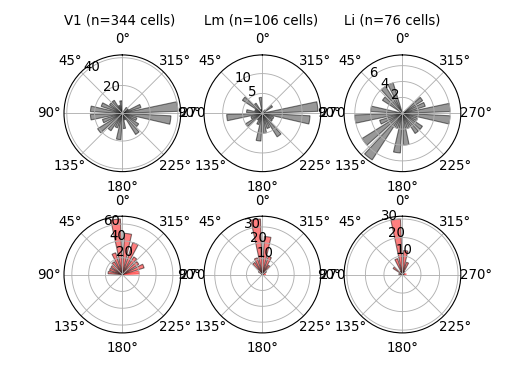

In [87]:
bar_width=10.
bin_size = 15
ori_bins = np.arange(0, 360+bin_size, bin_size)
rf_bins = np.arange(-90, 90+bin_size, bin_size)

fig = pl.figure()

vi=0
visual_area='V1'

i=0
for vi, visual_area in enumerate(visual_areas):

    
    # First, do PREFERRED THETA
    g = DF[DF['visual_area']==visual_area].copy()

    degrees = g['theta_pref'].values #% 180.
    radians = np.rad2deg(degrees)

    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

    ax = pl.subplot(2, 3, vi+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, color='.2', alpha=0.5, edgecolor='k')
    ax.set_theta_zero_location("N")
    ax.set_rlabel_position(45)
    #ax.set_xticklabels([])
    ax.set_title('%s (n=%i cells)' % (visual_area, g.shape[0]), loc='left', fontsize=12, y=1.2)

    # Now, do RECEPTIVE FIELD angles
    #r = RFS[RFS['visual_area']==visual_area].copy()
    degrees = np.rad2deg(g['theta_Mm_c'].values) #. #- 90.

    bin_counts, bin_vals = np.histogram(degrees, bins=rf_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])
    
    ax = pl.subplot(2, 3, vi+3+1, projection='polar')
    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, color='r', alpha=0.5, edgecolor='r')
    ax.set_theta_zero_location("N")
    
    #ax.set_rlabel_position(45)
    #ax.set_xticklabels([])

    i+=2

In [73]:
degrees.min(), degrees.max()


(-87.63880136750282, 88.29492772050351)

In [88]:
mod_deg = degrees % 180.
for d, m in zip(degrees, mod_deg):
    print('%.2f, %.2f' % (d, m))

-45.37, 134.63
78.04, 78.04
13.50, 13.50
-6.17, 173.83
-1.91, 178.09
-4.62, 175.38
8.55, 8.55
4.14, 4.14
9.11, 9.11
-5.13, 174.87
3.22, 3.22
0.82, 0.82
9.48, 9.48
7.81, 7.81
51.43, 51.43
13.19, 13.19
-79.46, 100.54
54.54, 54.54
56.58, 56.58
-38.99, 141.01
56.81, 56.81
60.32, 60.32
25.31, 25.31
-19.02, 160.98
2.15, 2.15
1.48, 1.48
-9.07, 170.93
-6.57, 173.43
88.29, 88.29
-87.64, 92.36
-29.94, 150.06
14.13, 14.13
0.29, 0.29
-0.10, 179.90
6.12, 6.12
12.40, 12.40
-64.11, 115.89
29.14, 29.14
3.19, 3.19
3.69, 3.69
5.47, 5.47
10.29, 10.29
-7.01, 172.99
15.17, 15.17
-19.87, 160.13
12.66, 12.66
-28.68, 151.32
55.88, 55.88
9.53, 9.53
-21.51, 158.49
8.83, 8.83
37.27, 37.27
8.51, 8.51
7.41, 7.41
19.01, 19.01
12.43, 12.43
19.79, 19.79
54.15, 54.15
-30.53, 149.47
-24.95, 155.05
15.10, 15.10
-5.02, 174.98
-18.87, 161.13
-5.63, 174.37
22.07, 22.07
-1.80, 178.20
34.59, 34.59
22.77, 22.77
-6.64, 173.36
-2.14, 177.86
11.86, 11.86
8.54, 8.54
12.70, 12.70
16.18, 16.18
4.25, 4.25
9.60, 9.60


<IPython.core.display.Javascript object>


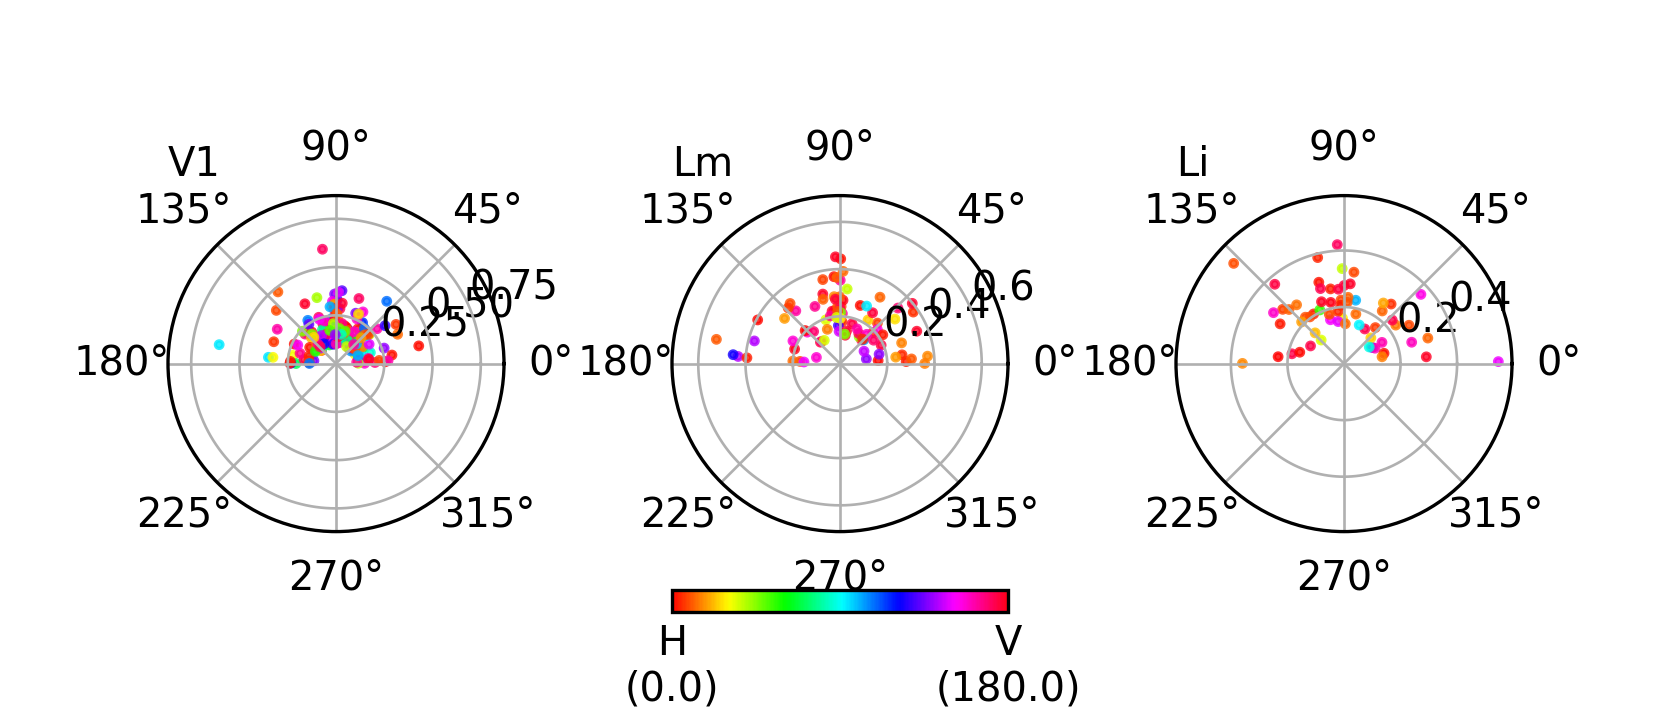

V1:: 214 cells
Lm:: 92 cells
Li:: 64 cells


In [126]:
import matplotlib as mpl
import matplotlib.cm as cm

vmin=0
vmax=180

cmap_name = cm.hsv
aniso_thr=0.1

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = cm.ScalarMappable(norm=norm, cmap=cmap_name)

#if ax is None:
fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

for ax, visual_area in zip(axn.flat, visual_areas):

    df_ = DF[(DF['visual_area']==visual_area) 
            & (DF['anisotropy']>=aniso_thr)].copy()
    print('%s:: %i cells' % (visual_area, df_.shape[0]))
    
    ori_deg = df_['theta_pref'].values
    pref_oris = np.deg2rad(ori_deg) % np.pi
    
    rf_angles = np.rad2deg(df_['theta_Mm_c'].values) % 180.
    vmin=0
    vmax=180
    
    aniso_levels = df_['anisotropy'].values
    aniso_indices = df_['aniso_index'].values
    

    im = ax.scatter(pref_oris, aniso_levels, s=5, c=rf_angles, cmap=cmap_name, 
                    alpha=0.8, vmin=vmin, vmax=vmax)
    ax.set_title(visual_area, loc='left', fontsize=12)


pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9)

# Colorbar
cmap._A = []
cbar_ax = ax.figure.add_axes([0.4, 0.15, 0.2, 0.03])
cbar = ax.figure.colorbar(cmap, cax=cbar_ax, orientation='horizontal', ticks=[vmin, vmax])
xlabel_min = 'H\n(%.1f)' % (vmin) 
xlabel_max= 'V\n(%.1f)' % (vmax) 
cbar.ax.set_xticklabels([xlabel_min, xlabel_max])  # horizontal colorbar
cbar.ax.tick_params(which='both', size=0)


In [120]:
rf_angles

array([1.79208093e+02, 2.35566279e-01, 1.79892270e+02, 1.79966601e+02,
       1.79919424e+02, 1.49166130e-01, 7.23162252e-02, 1.59074220e-01,
       1.79910474e+02, 5.62598204e-02, 1.43783869e-02, 1.65438936e-01,
       1.36270888e-01, 2.30231359e-01, 1.78613194e+02, 4.41742988e-01,
       1.79667965e+02, 3.75734671e-02, 2.59016489e-02, 1.79841629e+02,
       1.79885410e+02, 1.54103720e+00, 1.78470414e+02, 1.79477446e+02,
       2.46684109e-01, 5.06043950e-03, 1.79998315e+02, 1.06828906e-01,
       2.16498576e-01, 5.08524130e-01, 5.57096348e-02, 6.43364461e-02,
       9.55306440e-02, 1.79643270e-01, 1.79877716e+02, 2.64822019e-01,
       1.79653202e+02, 2.20878885e-01, 1.79499354e+02, 1.66284664e-01,
       1.79624619e+02, 1.54171309e-01, 6.50484785e-01, 1.29279796e-01,
       3.31859733e-01, 2.16988187e-01, 3.45399083e-01, 9.45136605e-01,
       1.79467214e+02, 1.79564567e+02, 1.79912318e+02, 1.79670587e+02,
       1.79901689e+02, 1.79968620e+02, 6.03624094e-01, 3.97494658e-01,
      

<IPython.core.display.Javascript object>


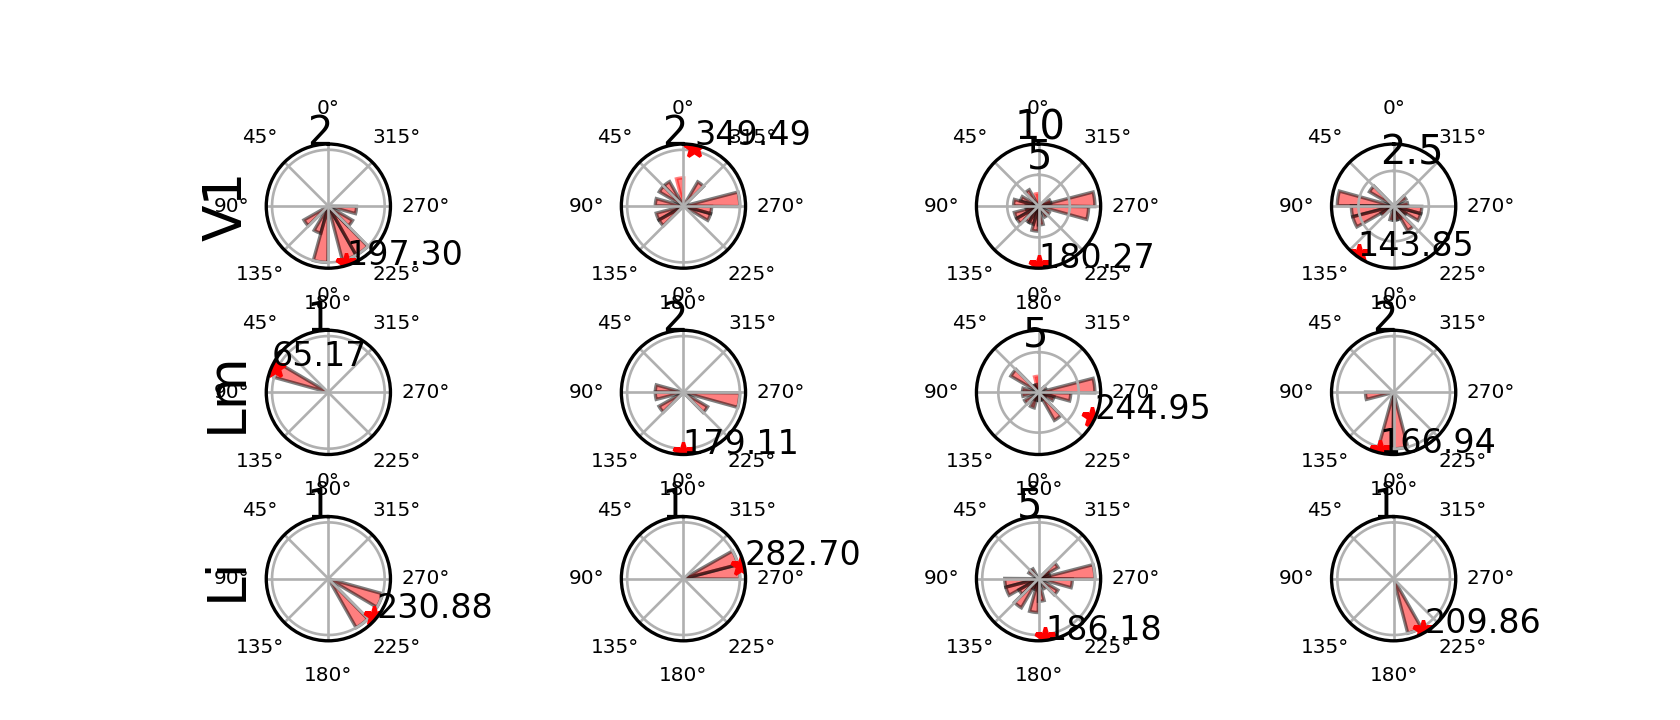

In [127]:
rf_bin_size = 45
rf_bins = np.arange(-90,90+rf_bin_size, rf_bin_size)

##### 
bar_width=15
bin_size = 15

bin_span=10
aniso_thr=0.1
filter_aniso=True

ori_bins = np.arange(0, 360+bin_size, bin_size)


label_unit='degrees'

#if ax is None:
fig, axn = pl.subplots(3, len(rf_bins)-1, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

for vi, visual_area in enumerate(visual_areas):
    df_ = DF[(DF['visual_area']==visual_area)].copy()
    
    if filter_aniso:
        df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()
        
    for i, currbin in enumerate(rf_bins[::-1][0:-1]): #rf_bins[0:-1]):

        ax = axn[vi, i]
        if i==0:
            ax.set_ylabel(visual_area)
    
        bin_min = np.deg2rad(currbin-bin_span) #%180.
        bin_max = np.deg2rad(currbin+bin_span) #%180.
        if currbin==90:
            bin_max = np.deg2rad(-90+ bin_span)
            bin_min = np.deg2rad(90-bin_span)
            curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min)
                             | ( df_['theta_Mm_c'] <= bin_max) ]
        else:
            curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min )
                             & ( df_['theta_Mm_c'] <= bin_max ) ]

        degrees = curr_vs['theta_pref'].values #% 180. #360.
        rads = np.deg2rad(degrees) #% np.pi

        bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
        centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

        ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, color='r', alpha=0.5, edgecolor='r')
        ax.set_theta_zero_location("N")

        mean_theta = spstats.circmean(rads) #, low=-np.pi, high=np.pi)
        ax.plot(mean_theta, ax.get_ylim()[-1], 'r*')
        ax.text(mean_theta, ax.get_ylim()[-1], '%.2f' % np.rad2deg(mean_theta))
        
        # Remove ylabels, they are mostly obstructive and not informative
        #ax.set_yticks([])

        if label_unit == "radians":
            label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                      r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
            ax.set_xticklabels(label)
        ax.tick_params(which='major', axis='x', labelsize=6, pad=0) #fontsize=8)
        
    pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)

<IPython.core.display.Javascript object>


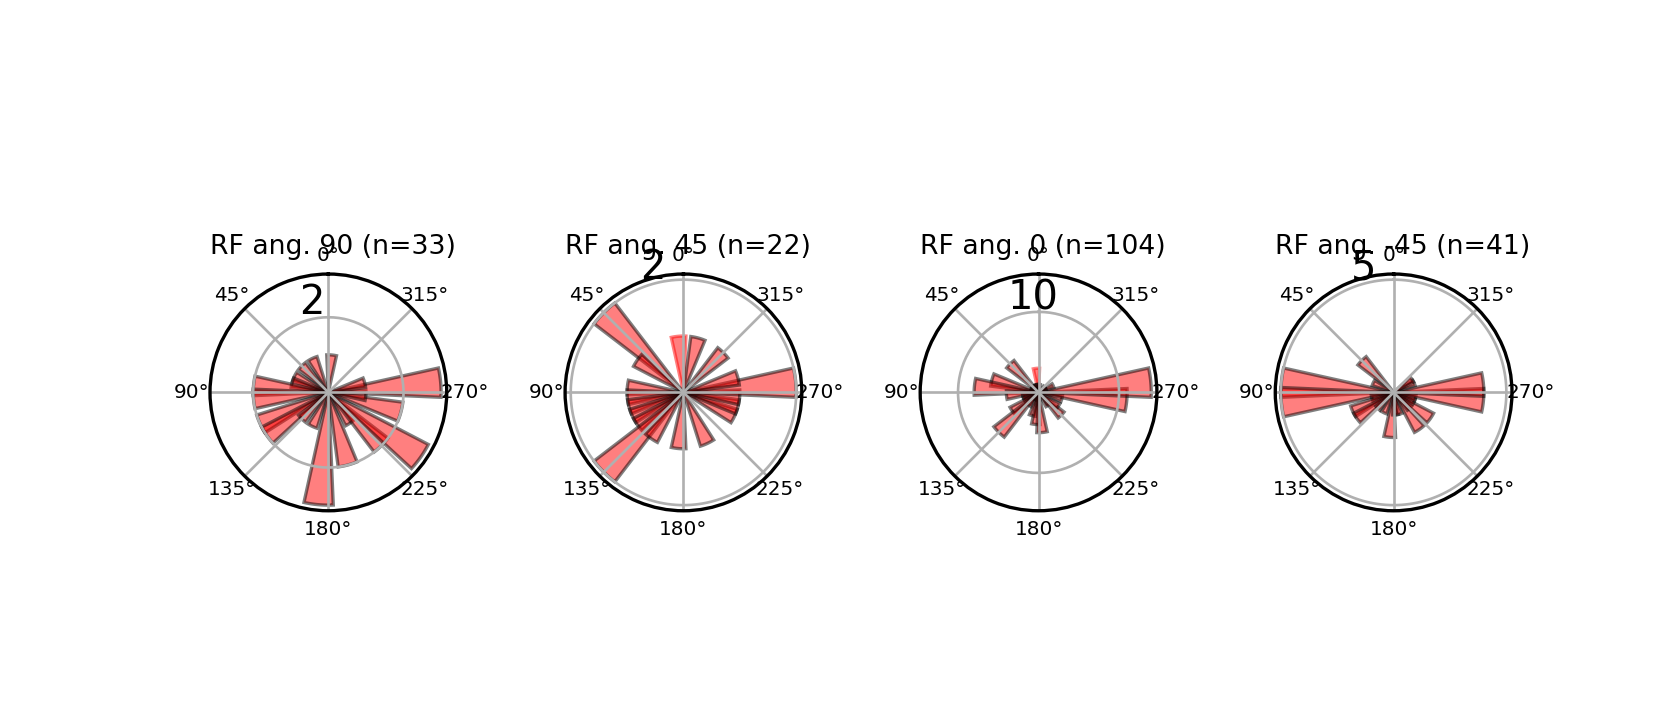

V1:: 344 cells


In [116]:
rf_bin_size = 45
rf_bins = np.arange(-90,90+rf_bin_size, rf_bin_size)

##### 
bar_width=15
bin_size = 10

bin_span=20
aniso_thr=0.1
filter_aniso=True

ori_bins = np.arange(0, 360+bin_size, bin_size)


label_unit='degrees'

#if ax is None:
fig, axn = pl.subplots(1, 4, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)


vi=0
visual_area='V1'

df_ = DF[(DF['visual_area']==visual_area)].copy()
print('%s:: %i cells' % (visual_area, df_.shape[0]))

if filter_aniso:
    df_ = df_[df_['anisotropy']>=aniso_thr] #.copy()

for i, currbin in enumerate(rf_bins[::-1][0:-1]):   
    ax=axn[i]
    
    bin_min = np.deg2rad(currbin-bin_span) #%180.
    bin_max = np.deg2rad(currbin+bin_span) #%180.
    
    if currbin==90:
        bin_max = np.deg2rad(-90+ bin_span)
        bin_min = np.deg2rad(90-bin_span)
        curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min)
                         | ( df_['theta_Mm_c'] <= bin_max) ]
    else:
        curr_vs = df_[ ( df_['theta_Mm_c'] >= bin_min )
                         & ( df_['theta_Mm_c'] <= bin_max ) ]

    ncells = curr_vs.shape[0]
    
    ax.set_title('RF ang. %i (n=%i)' % (currbin, ncells), loc='left', fontsize=8)
    degrees = curr_vs['theta_pref'].values % 360.
    rads = np.deg2rad(degrees) #% np.pi

    bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)
    centers = np.deg2rad(np.ediff1d(bin_vals)//2 + bin_vals[:-1])

    ax.bar(centers, bin_counts, width=np.deg2rad(bar_width), bottom=0.0, color='r', alpha=0.5, edgecolor='r')
    ax.set_theta_zero_location("N")
    #ax.set_title('RF %i (%i cells)' % (currbin, len(degrees)), loc='left', fontsize=8)

    max_ix = np.where(bin_counts==max(bin_counts))[0][0]
    max_theta = np.deg2rad(bin_vals[max_ix])
    #mean_theta = spstats.circmean(rads) #, low=-np.pi, high=np.pi)
    #ax.plot([0, max_theta], [0, ax.get_ylim()[-1]], 'k*', linestyle=':', lw=2)
    #ax.text([0, max_theta], [0, ax.get_ylim()[-1]], '%.2f' % np.rad2deg(max_theta))

    # Remove ylabels, they are mostly obstructive and not informative
    #ax.set_yticks([])

    if label_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)
    ax.tick_params(which='major', axis='x', labelsize=6, pad=-5) #fontsize=8)

pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)

In [205]:
np.rad2deg(spstats.circmean(np.deg2rad(degrees)))

172.00470623593185

In [212]:
np.median(degrees)

175.0530766673429

<IPython.core.display.Javascript object>


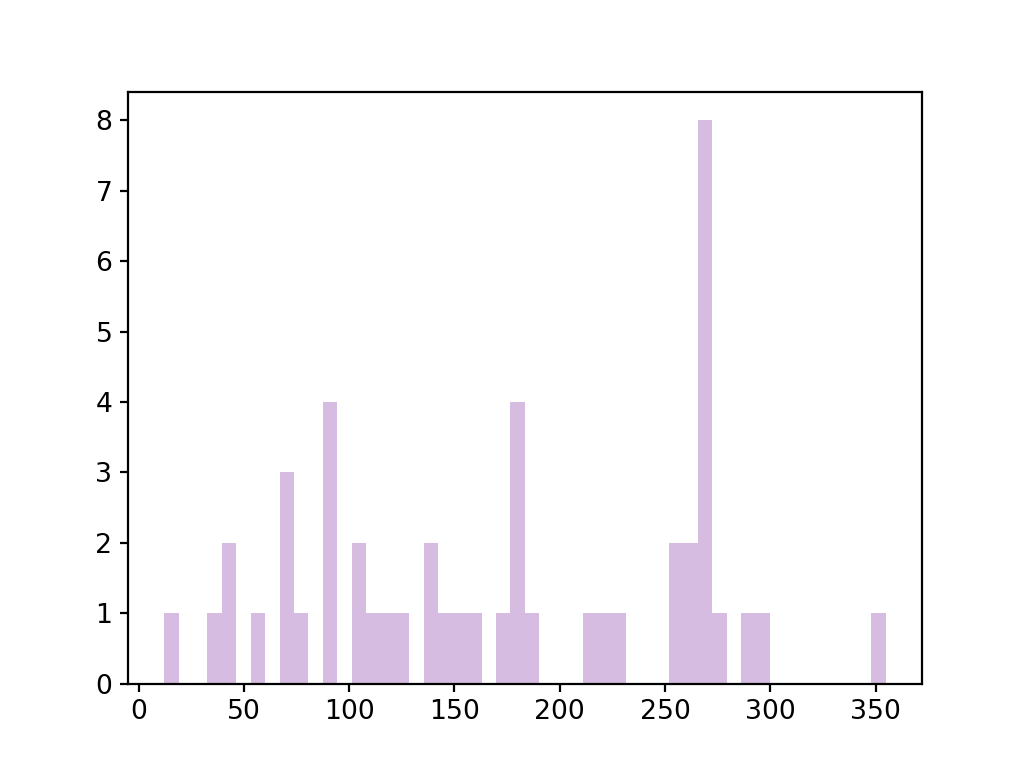

In [214]:
pl.figure()
sns.distplot(degrees, bins=50, kde=False)

In [216]:
bin_counts, bin_vals = np.histogram(degrees, bins=ori_bins)


In [219]:
max_ix = np.where(bin_counts==max(bin_counts))[0][0]
bin_vals[max_ix]
bin_vals

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [220]:
np.median(degrees)

175.0530766673429

<IPython.core.display.Javascript object>


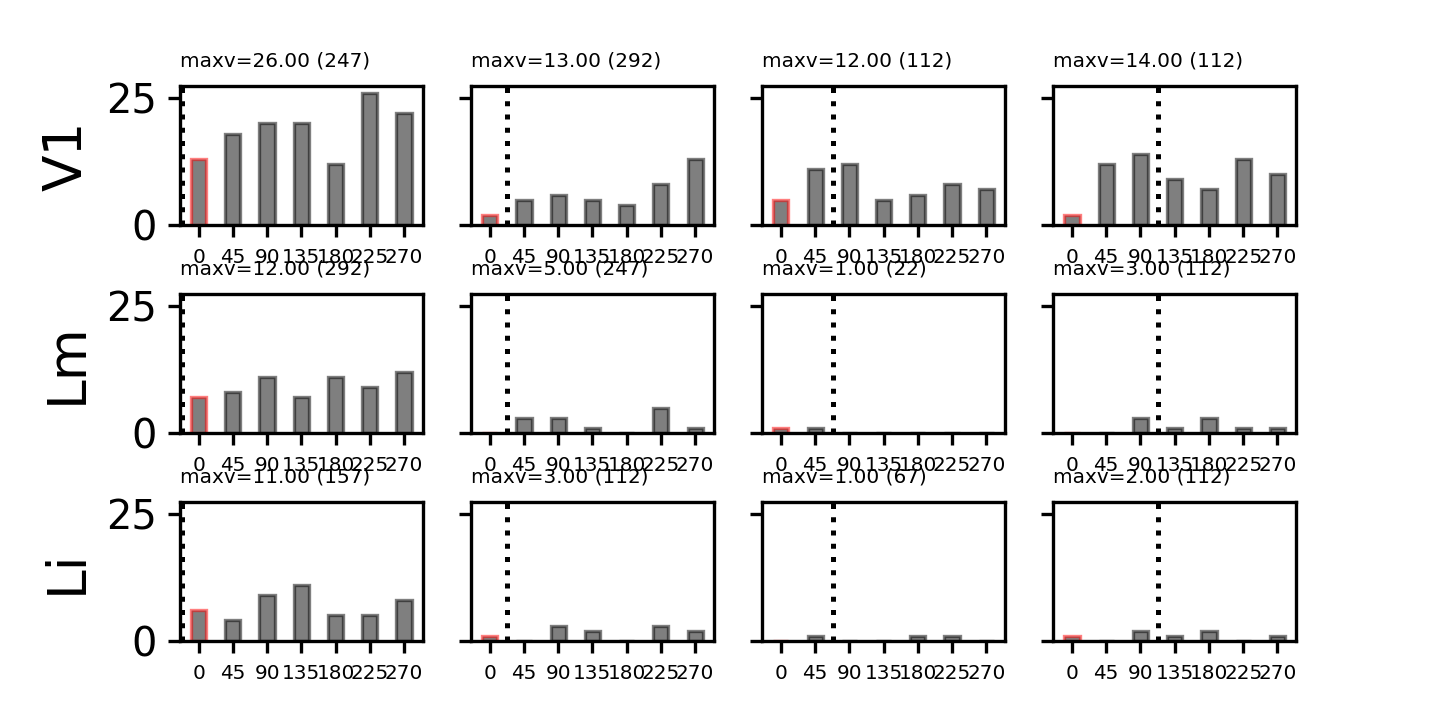

(0, 157.5, 22.5)
('...', 0.41846190365523084, 179.91148542675228)
(45, 22.5, 67.5)
('...', 23.094739615704725, 66.58244253771213)
(90, 67.5, 112.5)
('...', 67.84618502526023, 112.36693727535433)
(135, 112.5, 157.5)
('...', 115.70793069348268, 157.3898892231296)
(0, 157.5, 22.5)
('...', 0.6969493854078541, 179.4706527523751)
(45, 22.5, 67.5)
('...', 25.207676055518547, 47.85188665667125)
(90, 67.5, 112.5)
('...', 94.07074813087914, 103.10377496202698)
(135, 112.5, 157.5)
('...', 123.88322466218767, 155.23424182497325)
(0, 157.5, 22.5)
('...', 0.2899418255503231, 179.9034703641562)
(45, 22.5, 67.5)
('...', 22.774766272835485, 60.322418616777384)
(90, 67.5, 112.5)
('...', 78.04457268019134, 92.36119863249718)
(135, 112.5, 157.5)
('...', 115.8899750564082, 155.05155009406437)


In [142]:
fig, axn = pl.subplots(3, 4, figsize=(6,3), dpi=dpi, sharey=True, sharex=False)
#fig, axn = pl.subplots(2, 3, subplot_kw=dict(projection='polar'), figsize=(7,3), dpi=dpi)

visual_area='V1'

g = GFS[GFS['visual_area']==visual_area].copy()
r = RFS[RFS['visual_area']==visual_area].copy()


for vi, visual_area in enumerate(visual_areas):
    
    g = GFS[GFS['visual_area']==visual_area].copy()
    r = RFS[RFS['visual_area']==visual_area].copy()

    cols_to_use = r.columns.difference(g.columns)
    combodf = pd.merge(g, r[cols_to_use], left_index=True, right_index=True, how='outer')

    
    for i, currbin in enumerate(rf_bins[0:-1]):
        #if currbin not in [0, 90]:
        #    continue
        
        ax = axn[vi, i]
        #ax.set_title('RF angle=%i' % currbin, fontsize=6)
        if i==0:
            ax.set_ylabel(visual_area)
        #ax.set_title("RF angle=%i" % currbin, loc='left')
        #if currbin not in [0]: #, 90]:
        #    continue
                    
        min_angle = (currbin-(rf_bin_size/2.)) % 180.
        max_angle = (currbin+(rf_bin_size/2.)) % 180.
        print(currbin, min_angle, max_angle)
        
        if currbin == 0:
            curr_vs = combodf[ ( (np.rad2deg(combodf['theta_Mm_c'].values) % 180.) >= min_angle)
                         | ( (np.rad2deg(combodf['theta_Mm_c'].values) % 180.) <= max_angle) ]
        else:
            curr_vs = combodf[ ( (np.rad2deg(combodf['theta_Mm_c'].values) % 180.) >= min_angle)
                         & ( (np.rad2deg(combodf['theta_Mm_c'].values) % 180.) <= max_angle) ]
        
        print("...", min((np.rad2deg(curr_vs['theta_Mm_c'].values) % 180.)), 
              max((np.rad2deg(curr_vs['theta_Mm_c'].values) % 180.)))
        
        
        degrees = curr_vs['theta_pref'].values % 360.
        ori_bins = np.arange(0, 360, 45)
        bcounts, bvals = np.histogram(degrees, bins=ori_bins)
        #bcenters = np.deg2rad(np.ediff1d(bvals)//2 + bvals[:-1])
        #print(currbin, np.median(degrees))
        bcenters = np.ediff1d(bvals)//2 + bvals[:-1]

        #ax.hist(degrees, label='%s, RFs=%i' % (visual_area, currbin), lw=2, 
        #     histtype='step', color=col_dict[currbin], bins=bcenters, alpha=0.5)
        ax.bar(bcenters, bcounts, width=20, bottom=0.0, color='k', alpha=0.5, edgecolor='r')
        #ax.set_theta_zero_location("N")
        
        #ax.set_xticks(np.arange(0, 360, 45))
        ax.set_xticks(bcenters)
        ax.set_xticklabels(bvals, fontsize=6)
        #ax.set_xticklabels([b if bi%2==0 else '' for bi, b in enumerate(bvals)], fontsize=6)

        ax.axvline(x=currbin, ls=':', color='k')
        max_bin = np.where(bcounts==max(bcounts))[0][0]
        max_val = max(bcounts)
        max_str = 'maxv=%.2f (%i)' % (max_val, bcenters[max_bin])
        ax.set_title(max_str, fontsize=6, loc='left') #(currbin, ax.get_ylim()[-1], , fontsize=6)
        
pl.legend()
pl.subplots_adjust(hspace=0.5, wspace=0.2)

In [605]:
270.%180.

90.0

In [612]:
np.where(bcounts==max(bcounts))[0][0]

4

<IPython.core.display.Javascript object>


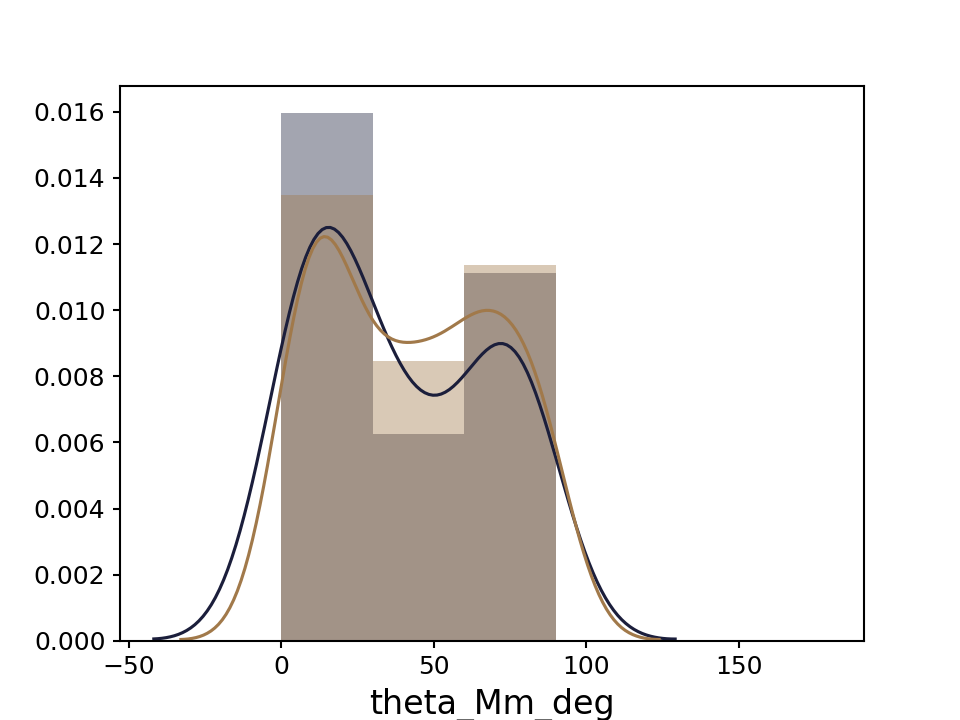

In [265]:
i = 0
f, ax = pl.subplots()
curr_bin_oris = g[ ((g['theta_pref'] % 180.) > bin_vals[i]) 
                 & ((g['theta_pref'] % 180.) < bin_vals[i+1]) ]
curr_bin_rfs = r[r['cell'].isin(curr_bin_oris['cell'].unique())].copy()


sns.distplot(curr_bin_rfs['theta_Mm_deg'] % 90., kde=True, bins=bins, ax=ax, 
             color=col_dict[bin_vals[i]])

i=3
curr_bin_oris = g[ ((g['theta_pref'] % 180.) > bin_vals[i]) 
                 & ((g['theta_pref'] % 180.) < bin_vals[i+1]) ]
curr_bin_rfs = r[r['cell'].isin(curr_bin_oris['cell'].unique())].copy()


sns.distplot(curr_bin_rfs['theta_Mm_deg'] % 90., kde=True, bins=bins, ax=ax, 
             color=col_dict[bin_vals[i]])

    

In [128]:
curr_bin_rfs['theta_Mm_deg']

Series([], Name: theta_Mm_deg, dtype: float64)

In [129]:
bin_counts

array([14, 10, 21, 20, 17, 39, 46, 20, 15, 15,  9, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [102]:
rf_angle.min(), rf_angle.max()

(3.2688107655715015, 179.8988497524265)

<IPython.core.display.Javascript object>


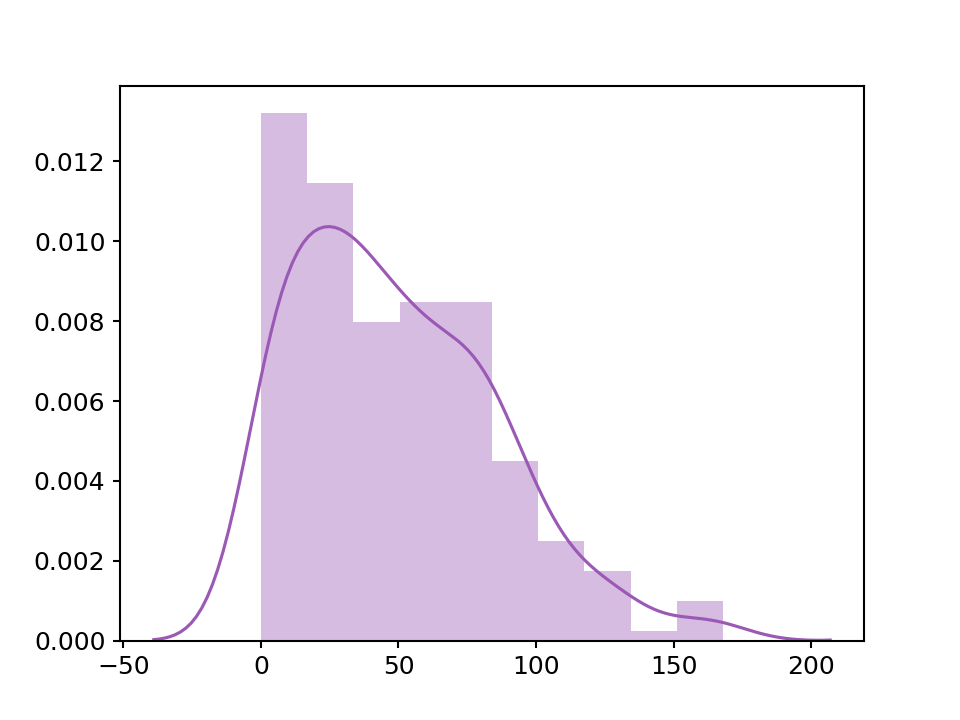

In [99]:
fig, ax = pl.subplots()
angle_diffs = abs(pref_ori - rf_angle)
sns.distplot(angle_diffs, ax=ax)


In [261]:
# for x, y in zip(g.sort_values(by=['cell'])['theta_pref'].values % 180., r.sort_values(by=['cell'])['theta_Mm_deg'].values):
#     print(x,y)

In [225]:
r.shape, g.shape

((237, 35), (237, 17))

In [235]:
r['theta_Mm_deg'].values.max() % 180.

179.50074654511474

In [90]:
r.columns

Index([u'animalid', u'datakey', u'session', u'fov_xpos', u'fov_ypos',
       u'ml_pos', u'ap_pos', u'cell', u'r2', u'fwhm_x', u'fwhm_y', u'theta',
       u'x0', u'y0', u'fovnum', u'std_x', u'std_y', u'fwhm_avg', u'std_avg',
       u'area', u'datakey_ix', u'fov_xpos_pix', u'fov_ypos_pix',
       u'visual_area', u'experiment', u'fx', u'fy', u'ratio_xy', u'theta_c',
       u'theta_Mm_deg', u'major_axis', u'minor_axis', u'anisotropy',
       u'theta_Mm_c', u'aniso_index'],
      dtype='object')

In [ ]:
rfdf['ml_proj'] = ''
rfdf['ap_proj'] = ''

rfdf = rfdf.reset_index(drop=True)
n_dsets = len(rfdf.groupby(['datakey', 'experiment']).groups)

for di, ((visual_area, datakey, exp), rd) in enumerate(rfdf.groupby(['visual_area', 'datakey', 'experiment'])):
    if di % 10 == 0 or di==(n_dsets-1):
        print("%i of %i gradient result files loaded." % (int(di+1), n_dsets))

    p_df = projdf[(projdf['datakey']==datakey) & (projdf['visual_area']==visual_area)]
    if  len(p_df['fpath'].unique())==0:
        print("...missing: [%s] %s, %s" % (visual_area, datakey, exp))
        continue
    assert len(p_df['fpath'].unique())==1, "No unique retino path found: %s" % str(p_df['fpath'].unique())
    fpath = p_df['fpath'].unique()[0]
    gpath = os.path.join(os.path.split(fpath)[0], 'vectors_%s.pkl' % visual_area)
    with open(gpath, 'rb') as f:
        gresults = pkl.load(f)

    # Project FOV coordinates
    rfdf['ml_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])
    rfdf['ap_proj'][rd.index] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                          for ap, ml in rd[['ap_pos', 'ml_pos']].values])